In [102]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob


In [103]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Read in data (2015, 2016, and 2017 currently)

<span style="color:red">Some caution here: Reading everything in below will be slow and consume a decent amount of memory. If you just want the selected variables that are relevant/plotted, and height cooridnates as the vertical, then scroll down and read in the datasets that were saved out as a .nc files previously. Still need to read in the non-CAM files though. </span>

In [4]:
## Now read in those files to avoid a lot overhead

saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

HMGcamDS_local = xr.open_dataset(saveDir+'HMGcamDS_2015thru18jja_localTime_heightCoords_20210819.nc', decode_times=True)
HTGcamDS_local = xr.open_dataset(saveDir+'HTGcamDS_2015thru18jja_localTime_heightCoords_20210819.nc', decode_times=True)



In [4]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
###

dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2015jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2015jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2015-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2015-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2015-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2015-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2015-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2015-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2015-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2015-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2015-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2015-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2015-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2015-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2015-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2015-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2015-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2015-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2015-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2015-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        print('Length of CAM file times: ', len(HTGcamDS.time.values))
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        print('Length of CLM file times: ', len(HTGclmDS.time.values))
        HTGclmDS['time'] = HTGcamDS.time

    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time

        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time

    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time

    
    if iFile==0:
        HTGcamDS_all2015 = HTGcamDS 
        HMGcamDS_all2015 = HMGcamDS
        HTGclmDS_all2015 = HTGclmDS
        HMGclmDS_all2015 = HMGclmDS 
        HTGclmDSpatch_all2015 = HTGclmDS_patch
        HMGclmDSpatch_all2015 = HMGclmDS_patch
    else: 
        HTGcamDS_all2015 = xr.concat([HTGcamDS_all2015, HTGcamDS], dim='time')
        HMGcamDS_all2015 = xr.concat([HMGcamDS_all2015, HMGcamDS], dim='time')
        HTGclmDS_all2015 = xr.concat([HTGclmDS_all2015,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2015 = xr.concat([HMGclmDS_all2015,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2015 = xr.concat([HTGclmDSpatch_all2015,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2015 = xr.concat([HMGclmDSpatch_all2015,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Length of CAM file times:  2500
Length of CLM file times:  2500
Done reading in file 1 of 3
Length of CAM file times:  2500
Length of CLM file times:  2500
Done reading in file 2 of 3
Length of CAM file times:  1409
Length of CLM file times:  1409
Done reading in file 3 of 3


In [5]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2016
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja'
## Files with temperature relaxation on:
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2016jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2016jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2016-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2016-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2016-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2016-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2016-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2016-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2016-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2016-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2016-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2016-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2016-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2016-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2016-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2016-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2016-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2016-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2016-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2016-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time.values
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time.values
    
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2016 = HTGcamDS 
        HMGcamDS_all2016 = HMGcamDS
        HTGclmDS_all2016 = HTGclmDS
        HMGclmDS_all2016 = HMGclmDS 
        HTGclmDSpatch_all2016 = HTGclmDS_patch
        HMGclmDSpatch_all2016 = HMGclmDS_patch
    else: 
        HTGcamDS_all2016 = xr.concat([HTGcamDS_all2016, HTGcamDS], dim='time')
        HMGcamDS_all2016 = xr.concat([HMGcamDS_all2016, HMGcamDS], dim='time')
        HTGclmDS_all2016 = xr.concat([HTGclmDS_all2016,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2016 = xr.concat([HMGclmDS_all2016,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2016 = xr.concat([HTGclmDSpatch_all2016,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2016 = xr.concat([HMGclmDSpatch_all2016,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [6]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2017
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja'
## Files with temperature relaxation on:
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2017jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2017jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2017-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2017-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2017-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2017-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2017-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2017-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2017-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2017-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2017-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2017-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2017-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2017-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2017-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2017-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2017-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2017-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2017-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2017-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2017 = HTGcamDS 
        HMGcamDS_all2017 = HMGcamDS
        HTGclmDS_all2017 = HTGclmDS
        HMGclmDS_all2017 = HMGclmDS 
        HTGclmDSpatch_all2017 = HTGclmDS_patch
        HMGclmDSpatch_all2017 = HMGclmDS_patch
    else: 
        HTGcamDS_all2017 = xr.concat([HTGcamDS_all2017, HTGcamDS], dim='time')
        HMGcamDS_all2017 = xr.concat([HMGcamDS_all2017, HMGcamDS], dim='time')
        HTGclmDS_all2017 = xr.concat([HTGclmDS_all2017,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2017 = xr.concat([HMGclmDS_all2017,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2017 = xr.concat([HTGclmDSpatch_all2017,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2017 = xr.concat([HMGclmDSpatch_all2017,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [7]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2018
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2018jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2018jja'
## Files with temperature relaxation on:
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2018jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2018jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2018-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2018-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2018-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2018-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2018-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2018-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2018-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2018-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2018-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2018-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2018-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2018-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2018-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2018-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2018-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2018-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2018-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2018-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2018 = HTGcamDS 
        HMGcamDS_all2018 = HMGcamDS
        HTGclmDS_all2018 = HTGclmDS
        HMGclmDS_all2018 = HMGclmDS 
        HTGclmDSpatch_all2018 = HTGclmDS_patch
        HMGclmDSpatch_all2018 = HMGclmDS_patch
    else: 
        HTGcamDS_all2018 = xr.concat([HTGcamDS_all2018, HTGcamDS], dim='time')
        HMGcamDS_all2018 = xr.concat([HMGcamDS_all2018, HMGcamDS], dim='time')
        HTGclmDS_all2018 = xr.concat([HTGclmDS_all2018,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2018 = xr.concat([HMGclmDS_all2018,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2018 = xr.concat([HTGclmDSpatch_all2018,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2018 = xr.concat([HMGclmDSpatch_all2018,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [8]:
#selYear = 2017
selYear = 'all'

if selYear==2015: 
    HTGcamDS_all = HTGcamDS_all2015
    HMGcamDS_all = HMGcamDS_all2015
    HTGclmDS_all = HTGclmDS_all2015
    HMGclmDS_all = HMGclmDS_all2015
elif selYear==2016:
    HTGcamDS_all = HTGcamDS_all2016
    HMGcamDS_all = HMGcamDS_all2016
    HTGclmDS_all = HTGclmDS_all2016
    HMGclmDS_all = HMGclmDS_all2016    
elif selYear==2017:
    HTGcamDS_all = HTGcamDS_all2017
    HMGcamDS_all = HMGcamDS_all2017
    HTGclmDS_all = HTGclmDS_all2017
    HMGclmDS_all = HMGclmDS_all2017 
elif selYear==2018:
    HTGcamDS_all = HTGcamDS_all2018
    HMGcamDS_all = HMGcamDS_all2018
    HTGclmDS_all = HTGclmDS_all2018
    HMGclmDS_all = HMGclmDS_all2018 
elif selYear=='all': 
    ## Discard spin up days 
    iTimeStart   = np.where(HTGcamDS_all2015.time.values >= (HTGcamDS_all2015.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2015.time.values))

    HTGcamDS_all2015 = HTGcamDS_all2015.isel(time=timeArr)
    HTGclmDS_all2015 = HTGclmDS_all2015.isel(time=timeArr)
    HMGcamDS_all2015 = HMGcamDS_all2015.isel(time=timeArr)
    HMGclmDS_all2015 = HMGclmDS_all2015.isel(time=timeArr)
    HTGclmDSpatch_all2015 = HTGclmDSpatch_all2015.isel(time=timeArr)
    HMGclmDSpatch_all2015 = HMGclmDSpatch_all2015.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2016.time.values >= (HTGcamDS_all2016.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2016.time.values))

    HTGcamDS_all2016 = HTGcamDS_all2016.isel(time=timeArr)
    HTGclmDS_all2016 = HTGclmDS_all2016.isel(time=timeArr)
    HMGcamDS_all2016 = HMGcamDS_all2016.isel(time=timeArr)
    HMGclmDS_all2016 = HMGclmDS_all2016.isel(time=timeArr)
    HTGclmDSpatch_all2016 = HTGclmDSpatch_all2016.isel(time=timeArr)
    HMGclmDSpatch_all2016 = HMGclmDSpatch_all2016.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2017.time.values >= (HTGcamDS_all2017.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2017.time.values))

    HTGcamDS_all2017 = HTGcamDS_all2017.isel(time=timeArr)
    HTGclmDS_all2017 = HTGclmDS_all2017.isel(time=timeArr)
    HMGcamDS_all2017 = HMGcamDS_all2017.isel(time=timeArr)
    HMGclmDS_all2017 = HMGclmDS_all2017.isel(time=timeArr)
    HTGclmDSpatch_all2017 = HTGclmDSpatch_all2017.isel(time=timeArr)
    HMGclmDSpatch_all2017 = HMGclmDSpatch_all2017.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2018.time.values >= (HTGcamDS_all2018.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2018.time.values))

    HTGcamDS_all2018 = HTGcamDS_all2018.isel(time=timeArr)
    HTGclmDS_all2018 = HTGclmDS_all2018.isel(time=timeArr)
    HMGcamDS_all2018 = HMGcamDS_all2018.isel(time=timeArr)
    HMGclmDS_all2018 = HMGclmDS_all2018.isel(time=timeArr)
    HTGclmDSpatch_all2018 = HTGclmDSpatch_all2018.isel(time=timeArr)
    HMGclmDSpatch_all2018 = HMGclmDSpatch_all2018.isel(time=timeArr)

    ## Concat into one giant DS
    HTGcamDS_all = xr.concat([HTGcamDS_all2015, HTGcamDS_all2016, HTGcamDS_all2017, HTGcamDS_all2018], dim='time')
    HMGcamDS_all = xr.concat([HMGcamDS_all2015, HMGcamDS_all2016, HMGcamDS_all2017, HMGcamDS_all2018], dim='time')
    HTGclmDS_all = xr.concat([HTGclmDS_all2015, HTGclmDS_all2016, HTGclmDS_all2017, HTGclmDS_all2018], dim='time')
    HMGclmDS_all = xr.concat([HMGclmDS_all2015, HMGclmDS_all2016, HMGclmDS_all2017, HMGclmDS_all2018], dim='time')
    
    HTGclmDS_allPatch = xr.concat([HTGclmDSpatch_all2015, HTGclmDSpatch_all2016, HTGclmDSpatch_all2017, HTGclmDSpatch_all2018], dim='time')
    HMGclmDS_allPatch = xr.concat([HMGclmDSpatch_all2015, HMGclmDSpatch_all2016, HMGclmDSpatch_all2017, HMGclmDSpatch_all2018], dim='time')
    

In [9]:
del HTGcamDS_all2015
del HTGcamDS_all2016
del HTGcamDS_all2017
del HTGcamDS_all2018

del HMGcamDS_all2015
del HMGcamDS_all2016
del HMGcamDS_all2017
del HMGcamDS_all2018


del HTGclmDS_all2015
del HTGclmDS_all2016
del HTGclmDS_all2017
del HTGclmDS_all2018

del HMGclmDS_all2015
del HMGclmDS_all2016
del HMGclmDS_all2017
del HMGclmDS_all2018


del HTGclmDSpatch_all2015
del HTGclmDSpatch_all2016
del HTGclmDSpatch_all2017
del HTGclmDSpatch_all2018

del HMGclmDSpatch_all2015
del HMGclmDSpatch_all2016
del HMGclmDSpatch_all2017
del HMGclmDSpatch_all2018


## Start processing the data

**Let's keep just the important variables we think we'll care about**

In [104]:
HTGcamDS_all

<xarray.Dataset>
Dimensions:             (ilev: 65, lat: 1, lev: 64, lon: 1, nbnd: 2, time: 25056)
Coordinates:
  * lat                 (lat) float64 36.61
  * lon                 (lon) float64 262.5
  * lev                 (lev) float64 2.949 4.338 6.313 ... 980.7 988.8 996.3
  * ilev                (ilev) float64 2.255 3.643 5.032 ... 985.1 992.6 1e+03
  * time                (time) datetime64[ns] 2015-06-02T23:39:45 ... 2018-08...
Dimensions without coordinates: nbnd
Data variables:
    ntrk                (time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    ntrn                (time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    ntrm                (time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    gw                  (time, lat) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    hyam                (time, lev) float64 0.002949 0.004338 ... 0.0 0.0
    hybm                (time, lev) float64 0.0 0.0 0.0 ... 0.9797 0.9888 0.9963
    P0                  (time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    hyai                (time, ilev) float64 0.002255 0.003643 ... 0.0 0.0
    hybi                (time, ilev) float64 0.0 0.0 0.0 ... 0.9851 0.9926 1.0
    date                (time) int32 20150602 20150603 ... 20180828 20180828
    datesec             (time) int32 85785 585 1785 2985 ... 82185 83385 84585
    time_bnds           (time, nbnd) object 2015-06-02 23:29:45 ... 2018-08-2...
    date_written        (time) |S8 b'08/05/21' b'08/05/21' ... b'08/16/21'
    time_written        (time) |S8 b'11:47:24' b'11:47:24' ... b'08:15:59'
    ndbase              (time) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nsbase              (time) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nbdate              (time) int32 20150531 20150531 ... 20180531 20180531
    nbsec               (time) int32 84585 84585 84585 ... 84585 84585 84585
    mdt                 (time) int32 1200 1200 1200 1200 ... 1200 1200 1200 1200
    ndcur               (time) int32 2 2 2 2 2 2 2 2 ... 88 88 88 88 88 88 88 89
    nscur               (time) int32 1200 2400 3600 4800 ... 82800 84000 85200 0
    co2vmr              (time) float64 0.0003728 0.0003728 ... 0.0003671
    ch4vmr              (time) float64 1.841e-06 1.841e-06 ... 1.839e-06
    n2ovmr              (time) float64 3.16e-07 3.16e-07 ... 3.159e-07 3.159e-07
    f11vmr              (time) float64 7.088e-10 7.088e-10 ... 7.077e-10
    f12vmr              (time) float64 5.414e-10 5.414e-10 ... 5.414e-10
    sol_tsi             (time) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    nsteph              (time) int32 145 146 147 148 149 ... 6405 6406 6407 6408
    ADRAIN              (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    ADSNOW              (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AEROD_v             (time, lat, lon) float32 0.1136 nan nan ... nan nan
    ANRAIN              (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    ANSNOW              (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AODDUST             (time, lat, lon) float32 0.006373 nan nan ... nan nan
    AODDUST1            (time, lat, lon) float32 0.0006731 nan nan ... nan nan
    AODDUST3            (time, lat, lon) float32 0.004949 nan nan ... nan nan
    AODVIS              (time, lat, lon) float32 0.1108 nan nan ... nan nan
    AQRAIN              (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AQSNOW              (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AREI                (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AREL                (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AWNC                (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AWNI                (time, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    CAPE                (time, lat, lon) float32 308.2 283.2 270.7 ... 440.7 0.0
    CCN3                (time, lev, lat, lon) float32 0.001221 ... 317.6

In [10]:
keepVars = np.asarray(['LHFLX','SHFLX',
                       'PS','U10',
                       'PBLH','TREFHT','QREFHT','RHREFHT',
                       'PRECT','PRECC','PRECL','PRECZ',
                       'CLDTOT', 'CLDLOW','CLDMED','CLDHGH','CLDBOT','TGCLDLWP','CLDTOP',
                       'CLOUD','RAINQM','CLDLIQ','CONCLD', 'GCLDLWP',
                       'CLOUDCOVER_CLUBB',
                       'CLOUDFRAC_CLUBB',
                       'DCQ', 'QRL', 'QRS',
                       'U', 'V','T',  'Q',
                       'THETAL'
                       'THLP2_CLUBB',
                       'RTP2_CLUBB',
                       'RTPTHLP_CLUBB',
                       'UP2_CLUBB',
                       'VP2_CLUBB',
                       'WP2_CLUBB',
                       'UPWP_CLUBB',
                       'VPWP_CLUBB',
                       'WM_ZT_CLUBB',
                       'WP3_CLUBB',
                       'WPTHVP_CLUBB',
                       'WPRTP_CLUBB',
                       'WPTHLP_CLUBB',
                       'WP2RTP_CLUBB',
                       'WP2THLP_CLUBB',
                       'WPRTP2_CLUBB',
                       'WPTHLP2_CLUBB',
                       'RVMTEND_CLUBB',
                       'STEND_CLUBB',
                       'UTEND_CLUBB',
                       'hyai','hybi','hyam','hybm','P0'])

HTGcamDS_all = HTGcamDS_all[keepVars]
HMGcamDS_all = HMGcamDS_all[keepVars]


In [83]:
HTGcamDS_all.Z3

<xarray.DataArray 'Z3' (time: 25056, lev: 64, lat: 1, lon: 1)>
array([[[[4.00131367e+04]],

        [[3.69914141e+04]],

        [[3.43422227e+04]],

        ...,

        [[1.73836304e+02]],

        [[1.00508484e+02]],

        [[3.34381371e+01]]],


       [[[4.00447812e+04]],

        [[3.70225078e+04]],

        [[3.43728789e+04]],
...
        [[1.79239288e+02]],

        [[1.03644470e+02]],

        [[3.44841957e+01]]],


       [[[4.18101836e+04]],

        [[3.87555508e+04]],

        [[3.60518516e+04]],

        ...,

        [[1.79204590e+02]],

        [[1.03597328e+02]],

        [[3.44605637e+01]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 36.61
  * lon      (lon) float64 262.5
  * lev      (lev) float64 2.949 4.338 6.313 8.876 ... 971.9 980.7 988.8 996.3
  * time     (time) datetime64[ns] 2015-06-02T23:39:45 ... 2018-08-28T23:19:45
Attributes:
    mdims:         1
    units:         m
    long_name:     Geopotential Height (above sea level)
    cell_methods:  time: mean

In [72]:
HTGcamDS_all.Z3.values[:,-1,0,0]

array([33.438137, 33.396286, 33.365093, ..., 34.528706, 34.484196,
       34.460564], dtype=float32)

#### Define evaporative fraction (LH / (LH+SH)) for each dataset

In [10]:
HTG_EF = HTGcamDS_all.LHFLX.values / (HTGcamDS_all.LHFLX.values + HTGcamDS_all.SHFLX.values)
HMG_EF = HMGcamDS_all.LHFLX.values / (HMGcamDS_all.LHFLX.values + HTGcamDS_all.SHFLX.values)

HTGcamDS_all['EvapFraction'] = (('time'), np.squeeze(HTG_EF))
HMGcamDS_all['EvapFraction'] = (('time'), np.squeeze(HMG_EF))


#### Define skw_W not as just w'3 but as w'3/ (w'2**1.5)

In [11]:
skw_W_HTG = HTGcamDS_all.WP3_CLUBB.values / ((HTGcamDS_all.WP2_CLUBB.values)**1.5)
skw_W_HMG = HMGcamDS_all.WP3_CLUBB.values / ((HMGcamDS_all.WP2_CLUBB.values)**1.5)

HTGcamDS_all['Skw_W'] = (('time','ilev'), np.squeeze(skw_W_HTG))
HMGcamDS_all['Skw_W'] = (('time','ilev'), np.squeeze(skw_W_HMG))


#### Get standard deviation of ET as measure of sfc heterogeneity?

Patch types have values:  <br>
  !   0  => not_vegetated <br>
  !   1  => needleleaf_evergreen_temperate_tree <br>
  !   2  => needleleaf_evergreen_boreal_tree <br>
  !   3  => needleleaf_deciduous_boreal_tree <br>
  !   4  => broadleaf_evergreen_tropical_tree <br>
  !   5  => broadleaf_evergreen_temperate_tree <br>
  !   6  => broadleaf_deciduous_tropical_tree <br>
  !   7  => broadleaf_deciduous_temperate_tree <br>
  !   8  => broadleaf_deciduous_boreal_tree <br>
  !   9  => broadleaf_evergreen_shrub <br>
  !   10 => broadleaf_deciduous_temperate_shrub <br>
  !   11 => broadleaf_deciduous_boreal_shrub <br>
  !   12 => c3_arctic_grass <br>
  !   13 => c3_non-arctic_grass <br>
  !   14 => c4_grass <br>
  !   15 => c3_crop <br>
  !   16 => c3_irrigated <br>
<br><br>
Column types have values: <br> 
  !   1  => (istsoil)          soil (vegetated or bare soil)<br> 
  !   2  => (istcrop)          crop (only for crop configuration)<br> 
  !   3  => (UNUSED)           (formerly non-multiple elevation class land ice; currently unused)<br> 
  !   4  => (istice_mec)       land ice (multiple elevation classes)   <br> 
  !   5  => (istdlak)          deep lake<br> 
  !   6  => (istwet)           wetland<br> 
  !   71 => (icol_roof)        urban roof<br> 
  !   72 => (icol_sunwall)     urban sunwall<br> 
  !   73 => (icol_shadewall)   urban shadewall<br> 
  !   74 => (icol_road_imperv) urban impervious road<br> 
  !   75 => (icol_road_perv)   urban pervious road<br> 

In [12]:
## Get information on patch weights and types 

# Weight of each PFT over the gridcell (doesn't change in time here)
PFTwgt = HTGclmDS_allPatch.pfts1d_wtgcell.values[0,:]

# PFT types 
PFTtype = HTGclmDS_allPatch.pfts1d_itype_veg.values[0,:]

# Column types 
colType = HTGclmDS_allPatch.pfts1d_itype_col.values[0,:]

# If want to sort by weight...
indSort     = np.argsort(PFTwgt)

sortWgt     = PFTwgt[indSort[::-1]]
sortPFTtype = PFTtype[indSort[::-1]]
sortColType = colType[indSort[::-1]]

print(' Patch %      PFT_Type      Col_Type')
for iPatch in range(len(PFTwgt)):
    print(' %7.2f %11i %13i' % ((sortWgt[iPatch]/np.sum(sortWgt))*100, sortPFTtype[iPatch], sortColType[iPatch]))
iUrban = np.where((sortColType>70) & (sortColType<80))[0]
print('Percent of urban area in grdicell: %.2f' %( np.sum(sortWgt[iUrban])*100))

 Patch %      PFT_Type      Col_Type
   25.00           0             5
   25.00          13             1
   25.00           7             1
   12.50           0            71
    4.17           0            73
    4.17           0            72
    2.92           0            74
    1.25           0            75
Percent of urban area in grdicell: 25.00


In [13]:
## Also save patch names into an array to use later 

print('Unsorted.... ')
print('  PFT type          Col type')
for iPatch in range(len(PFTwgt)):
    print('%3i %16i '% (PFTtype[iPatch], colType[iPatch]))

patchLabels = np.asarray(['BroadleafDeciduous',
                          'C3 grass',
                          'Urban71',
                          'Urban72',
                          'Urban73',
                          'Urban74',
                          'Urban75',
                          'Lake'])

Unsorted.... 
  PFT type          Col type
  7                1 
 13                1 
  0               71 
  0               72 
  0               73 
  0               74 
  0               75 
  0                5 


In [14]:
# First define ET (LHFLX)
ET_patch_HTG = HTGclmDS_allPatch.QSOIL.values + HTGclmDS_allPatch.QVEGE.values + HTGclmDS_allPatch.QVEGT.values
ET_patch_HMG = HMGclmDS_allPatch.QSOIL.values + HMGclmDS_allPatch.QVEGE.values + HMGclmDS_allPatch.QVEGT.values

HTGclmDS_allPatch['ETtotal'] = (('time','pft'), ET_patch_HTG)
HMGclmDS_allPatch['ETtotal'] = (('time','pft'), ET_patch_HMG)


In [15]:
## Now get variance over the gridcell, but needs to be weighted... so use same scheme we did in CLM module 

# Need gridcell mean 
wgtGridMean_ET_HTG = (np.sum(ET_patch_HTG*PFTwgt,axis=1)/np.sum(PFTwgt))
wgtGridMean_ET_HMG = (np.sum(ET_patch_HMG*PFTwgt,axis=1)/np.sum(PFTwgt))

# Now get each patch's difference from that gridcell mean 
varUnweighted_ET_HTG = np.full([len(HTGclmDS_allPatch.time.values), len(PFTwgt)], np.nan)
varUnweighted_ET_HMG = np.full([len(HMGclmDS_allPatch.time.values), len(PFTwgt)], np.nan)

for iPatch in range(len(PFTwgt)):
    varUnweighted_ET_HTG[:,iPatch] = (ET_patch_HTG[:,iPatch] - wgtGridMean_ET_HTG)**2
    varUnweighted_ET_HMG[:,iPatch] = (ET_patch_HMG[:,iPatch] - wgtGridMean_ET_HMG)**2

# Now get the weighted mean of that across the gridcell
wgtVarianceET_HTG = (np.sum(varUnweighted_ET_HTG*PFTwgt,axis=1)/np.sum(PFTwgt))
wgtVarianceET_HMG = (np.sum(varUnweighted_ET_HMG*PFTwgt,axis=1)/np.sum(PFTwgt))



In [16]:
## Save standard deviation to larger datasets

HTGclmDS_all['stdET'] = (('time'), np.sqrt(wgtVarianceET_HTG))
HMGclmDS_all['stdET'] = (('time'), np.sqrt(wgtVarianceET_HMG))


#### Get PBLH as defined by max d(theta)/dz 

In [105]:
## Need to use metPy conda env
import metpy.calc as mpc
from metpy.units import units

In [106]:
def PBLHasMaxDZ(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth,zlevm

In [19]:
## Get *potential* temperature, not just T 

# So first, get actual pressures 
p0 = HTGcamDS_all['P0'].values[0]
plevmHTG = HTGcamDS_all['hyam']*p0 + HTGcamDS_all['hybm']*HTGcamDS_all['PS'].isel(lat=0,lon=0) # Mid level
plevmHTG.attrs['units'] = "Pa"

p0 = HMGcamDS_all['P0'].values[0]
plevmHMG = HMGcamDS_all['hyam']*p0 + HMGcamDS_all['hybm']*HMGcamDS_all['PS'].isel(lat=0,lon=0) # Mid level
plevmHMG.attrs['units'] = "Pa"

# Now get theta: 
HTG_theta = np.asarray(mpc.potential_temperature(plevmHTG * units.pascals, HTGcamDS_all['T'] * units.kelvin))
HMG_theta = np.asarray(mpc.potential_temperature(plevmHMG * units.pascals, HMGcamDS_all['T'] * units.kelvin))

# Add to existing DS
HTGcamDS_all['theta'] = (('time','lev','lat','lon'), HTG_theta)
HMGcamDS_all['theta'] = (('time','lev','lat','lon'), HMG_theta)

In [20]:
# Height with standard atmosphere
zlevmHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHTG)) # Units of [m] after multiplied 
zlevmHTG      = plevmHTG.copy(deep=True)
zlevmHTG[:,:] = zlevmHTG_vals

zlevmHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHMG)) # Units of [m] after multiplied 
zlevmHMG      = plevmHMG.copy(deep=True)
zlevmHMG[:,:] = zlevmHMG_vals

# HTGcamDS_all['zlevm'] = (('time','lev'), zlevmHTG)
# HMGcamDS_all['zlevm'] = (('time','lev'), zlevmHMG)


(array([  57.,  311., 1424., 4176., 6643., 6798., 4152., 1238.,  216.,
          41.]),
 array([242.07720242, 262.41670456, 282.75620669, 303.09570883,
        323.43521097, 343.77471311, 364.11421525, 384.45371739,
        404.79321953, 425.13272167, 445.47222381]),
 <BarContainer object of 10 artists>)

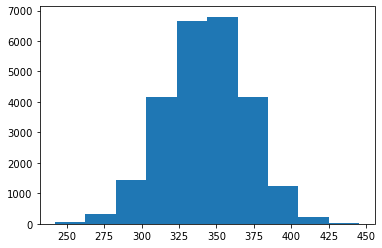

In [95]:
plt.hist(zlevmHMG[:,-1])

In [106]:
HMGcamDS_all.Z3.values[0,:,0,0]

array([4.0014379e+04, 3.6992652e+04, 3.4343473e+04, 3.1886262e+04,
       2.9723211e+04, 2.7715619e+04, 2.5951453e+04, 2.4426635e+04,
       2.3216613e+04, 2.2332588e+04, 2.1752090e+04, 2.1182785e+04,
       2.0626094e+04, 2.0079893e+04, 1.9545197e+04, 1.9019736e+04,
       1.8467637e+04, 1.7892867e+04, 1.7362363e+04, 1.6868748e+04,
       1.6374874e+04, 1.5876845e+04, 1.5371869e+04, 1.4863355e+04,
       1.4353103e+04, 1.3841784e+04, 1.3330303e+04, 1.2819797e+04,
       1.2317231e+04, 1.1818247e+04, 1.1309510e+04, 1.0789277e+04,
       1.0256524e+04, 9.7120586e+03, 9.1559404e+03, 8.5906211e+03,
       8.0153540e+03, 7.4307812e+03, 6.8370508e+03, 6.2350952e+03,
       5.6245308e+03, 5.0056367e+03, 4.4235249e+03, 3.8719854e+03,
       3.3677659e+03, 2.9073135e+03, 2.5000120e+03, 2.1411968e+03,
       1.8372489e+03, 1.5854547e+03, 1.3904554e+03, 1.2498174e+03,
       1.1150648e+03, 9.8605255e+02, 8.6307275e+02, 7.4599835e+02,
       6.3509662e+02, 5.3025275e+02, 4.3171063e+02, 3.3936765e

In [122]:
# Now compute the BL depth
# PBLdepth_hmg,zlevmHMG = PBLHasMaxDZ(HMGcamDS_all, 'theta')
# PBLdepth_htg,zlevmHTG = PBLHasMaxDZ(HTGcamDS_all, 'theta')

# PBLdepth_hmg,zlevmHMG = PBLHasMaxDZ(HMGcamDS_all, 'THETAL')
# PBLdepth_htg,zlevmHTG = PBLHasMaxDZ(HTGcamDS_all, 'THETAL')

PBLdepth_hmg,zlevmHMG = PBLHasMaxDZ(HMGcamDS_all, 'Q')
PBLdepth_htg,zlevmHTG = PBLHasMaxDZ(HTGcamDS_all, 'Q')


(array([  57.,  311., 1424., 4176., 6643., 6798., 4152., 1238.,  216.,
          41.]),
 array([-72.92279758, -52.58329544, -32.24379331, -11.90429117,
          8.43521097,  28.77471311,  49.11421525,  69.45371739,
         89.79321953, 110.13272167, 130.47222381]),
 <BarContainer object of 10 artists>)

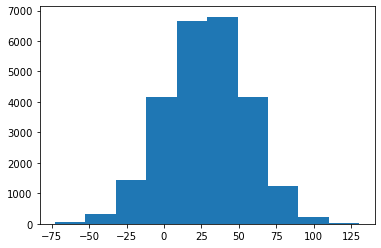

In [128]:
plt.hist(zlevmHMG[:,-1]-315)

In [123]:
# Add above to each dataset
HMGcamDS_all['PBLdepth'] = (('time'), PBLdepth_hmg)
HTGcamDS_all['PBLdepth'] = (('time'), PBLdepth_htg)
                              

**Interpolate to consistent vertical heights**

In [74]:
def interpolateToHeight(DS, heights_m, heights_i, levmGoals, leviGoals):
#     interpDS = DS.copy(deep=True)
    
    nT = len(DS.time.values)
    
    for iT in range(nT):
        selDS = DS.isel(time=iT)
        
        # Replace lev and ilev dimensions
        selDS = selDS.assign_coords({"lev":  heights_m.values[iT,:]})
        selDS = selDS.assign_coords({"ilev": heights_i[iT,:]})
        
        selDS_interp = selDS.interp(lev=levmGoals)
        selDS_interp = selDS_interp.interp(ilev=leviGoals)
        
        if iT==0:
            interpDS = selDS_interp
        else: 
            interpDS = xr.concat([interpDS, selDS_interp], dim='time')
       
        if (iT % 200)==0:
            print('Done with time %i of %i' % (iT, nT))
    
    return interpDS

In [75]:
# Want interface levels to interpolate to as well 
pleviHTG = HTGcamDS_all['hyai']*p0 + HTGcamDS_all['hybi']*HTGcamDS_all['PS'].isel(lat=0,lon=0) # Interface level
pleviHMG = HMGcamDS_all['hyai']*p0 + HMGcamDS_all['hybi']*HMGcamDS_all['PS'].isel(lat=0,lon=0) # Interface level
pleviHTG.attrs['units'] = "Pa"
pleviHMG.attrs['units'] = "Pa"

zleviHTG = 1000.*np.asarray(mpc.pressure_to_height_std(pleviHTG)) # Units of [m] after multiplied 
zleviHMG = 1000.*np.asarray(mpc.pressure_to_height_std(pleviHMG)) # Units of [m] after multiplied 


In [77]:
mpc.pressure_to_height_std(pleviHTG)

<xarray.DataArray (time: 25056, ilev: 65)>
<Quantity([[30.44616279 29.12158713 28.15962067 ...  0.46166394  0.39881946
   0.33635547]
 [30.44616279 29.12158713 28.15962067 ...  0.42966515  0.3667748
   0.30426523]
 [30.44616279 29.12158713 28.15962067 ...  0.43239658  0.36951014
   0.30700446]
 ...
 [30.44616279 29.12158713 28.15962067 ...  0.48979818  0.42699402
   0.36457011]
 [30.44616279 29.12158713 28.15962067 ...  0.46700652  0.4041697
   0.34171332]
 [30.44616279 29.12158713 28.15962067 ...  0.46905241  0.40621852
   0.34376505]], 'kilometer')>
Coordinates:
  * ilev     (ilev) float64 2.255 3.643 5.032 7.595 ... 976.3 985.1 992.6 1e+03
  * time     (time) datetime64[ns] 2015-06-02T23:39:45 ... 2018-08-28T23:19:45
    lat      float64 36.61
    lon      float64 262.5

In [26]:
# Goal levels to interpoalte to 
levmGoals = np.ceil(np.nanmean(zlevmHTG, axis=0))
leviGoals = np.ceil(np.nanmean(zleviHTG, axis=0))

levmGoals[-1] = np.ceil(np.nanpercentile(zlevmHTG,95, axis=0)[-1])
leviGoals[-1] = np.ceil(np.nanpercentile(zleviHTG,95, axis=0)[-1])


356.0


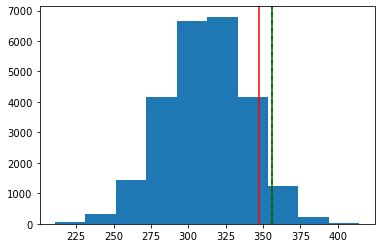

In [27]:
plt.hist(zleviHMG[:,-1])
plt.axvline(leviGoals[-1],color='k', linestyle='--')
plt.axvline(np.ceil(np.nanpercentile(zleviHTG,90, axis=0)[-1]),color='r')
plt.axvline(np.ceil(np.nanpercentile(zleviHTG,95, axis=0)[-1]),color='g')
print(leviGoals[-1])

In [83]:
## Dig in

saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

HMGcamDS_hgt = xr.open_dataset(saveDir+'HMGcamDS_2015thru18jja_localTime_heightCoords_20210819.nc', decode_times=True)
HTGcamDS_hgt = xr.open_dataset(saveDir+'HTGcamDS_2015thru18jja_localTime_heightCoords_20210819.nc', decode_times=True)

iLow  = np.where(zleviHMG[:,-1] < leviGoals[-1])[0]
iHigh = np.where(zleviHMG[:,-1] > leviGoals[-1])[0]



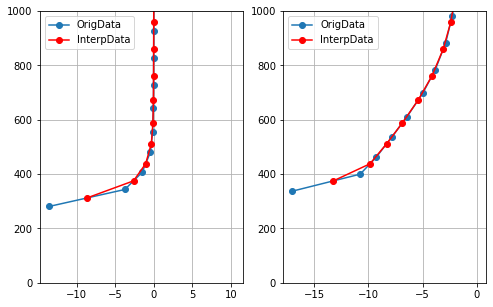

In [103]:
fig,axs = plt.subplots(1,2, figsize=(8,5))
axs     = axs.ravel()

varSel = 'WPTHLP_CLUBB'
chooseDay = 14

axs[0].plot(HMGcamDS_all[varSel].values[iLow[chooseDay],:,0,0], zleviHMG[iLow[chooseDay],:],'-o',label='OrigData')
axs[0].plot(HMGcamDS_hgt[varSel].values[iLow[chooseDay],:,0,0], HMGcamDS_hgt.ilev.values, 'r-o',label='InterpData')
axs[0].legend()
# axs[0].invert_yaxis()
axs[0].set_ylim([0,1000])

chooseDay = 1
axs[1].plot(HMGcamDS_all[varSel].values[iHigh[chooseDay],:,0,0], zleviHMG[iHigh[chooseDay],:],'-o',label='OrigData')
axs[1].plot(HMGcamDS_hgt[varSel].values[iHigh[chooseDay],:,0,0], HMGcamDS_hgt.ilev.values, 'r-o',label='InterpData')
axs[1].legend()
# axs[0].invert_yaxis()
axs[1].set_ylim([0,1000])

axs[0].grid()
axs[1].grid()


In [105]:
HMGcamDS_hgt[varSel].values[iHigh[chooseDay],:,0,0]

array([            nan, -2.14749608e-04, -7.37907945e-04, -1.09911939e-03,
       -1.45567625e-03, -1.78068007e-03, -2.23113506e-03, -2.56374736e-03,
       -2.92081926e-03, -3.14910420e-03, -3.46164092e-03, -3.63004676e-03,
       -3.91382636e-03, -4.09983499e-03, -4.36261470e-03, -4.49089947e-03,
       -4.63077797e-03, -4.92718149e-03, -5.10374091e-03, -5.42403777e-03,
       -6.12076814e-03, -2.28221255e-03, -4.49726893e-03, -6.09492116e-03,
       -6.62388225e-03, -7.02173292e-03, -8.28414024e-03, -9.30704432e-03,
       -8.00002060e-03, -7.89088694e-03,  2.97642107e-03, -7.59939123e-04,
        1.37350599e-03, -1.09307791e-03, -4.45466268e-03, -6.64920552e-03,
       -4.41317159e-03, -7.35754882e-03, -6.90161636e-03, -7.19736384e-03,
       -1.02352993e-02, -9.59968063e-03, -4.28241297e-03, -1.50573782e-03,
        8.51386765e-03, -1.21600905e-02, -1.28937907e-02, -1.16540879e-02,
       -1.35494796e-02, -8.17909305e-02, -2.17787288e-01, -4.24369293e-01,
       -7.13346401e-01, -

In [28]:
## Warning: This takes awhile per DS right now (4 years of JJA)
HMGcamDS_height = interpolateToHeight(HMGcamDS_all, zlevmHMG, zleviHMG, levmGoals, leviGoals)


Done with time 0 of 25056
Done with time 200 of 25056
Done with time 400 of 25056
Done with time 600 of 25056
Done with time 800 of 25056
Done with time 1000 of 25056
Done with time 1200 of 25056
Done with time 1400 of 25056
Done with time 1600 of 25056
Done with time 1800 of 25056
Done with time 2000 of 25056
Done with time 2200 of 25056
Done with time 2400 of 25056
Done with time 2600 of 25056
Done with time 2800 of 25056
Done with time 3000 of 25056
Done with time 3200 of 25056
Done with time 3400 of 25056
Done with time 3600 of 25056
Done with time 3800 of 25056
Done with time 4000 of 25056
Done with time 4200 of 25056
Done with time 4400 of 25056
Done with time 4600 of 25056
Done with time 4800 of 25056
Done with time 5000 of 25056
Done with time 5200 of 25056
Done with time 5400 of 25056
Done with time 5600 of 25056
Done with time 5800 of 25056
Done with time 6000 of 25056
Done with time 6200 of 25056
Done with time 6400 of 25056
Done with time 6600 of 25056
Done with time 6800 o

In [59]:
# # Add above to each dataset
# HMGcamDS_height['PBLdepth'] = (('time'), PBLdepth_hmg)


In [29]:
## Warning: This takes awhile per DS right now (4 years of JJA)
HTGcamDS_height = interpolateToHeight(HTGcamDS_all, zlevmHMG, zleviHMG, levmGoals, leviGoals)


Done with time 0 of 25056
Done with time 200 of 25056
Done with time 400 of 25056
Done with time 600 of 25056
Done with time 800 of 25056
Done with time 1000 of 25056
Done with time 1200 of 25056
Done with time 1400 of 25056
Done with time 1600 of 25056
Done with time 1800 of 25056
Done with time 2000 of 25056
Done with time 2200 of 25056
Done with time 2400 of 25056
Done with time 2600 of 25056
Done with time 2800 of 25056
Done with time 3000 of 25056
Done with time 3200 of 25056
Done with time 3400 of 25056
Done with time 3600 of 25056
Done with time 3800 of 25056
Done with time 4000 of 25056
Done with time 4200 of 25056
Done with time 4400 of 25056
Done with time 4600 of 25056
Done with time 4800 of 25056
Done with time 5000 of 25056
Done with time 5200 of 25056
Done with time 5400 of 25056
Done with time 5600 of 25056
Done with time 5800 of 25056
Done with time 6000 of 25056
Done with time 6200 of 25056
Done with time 6400 of 25056
Done with time 6600 of 25056
Done with time 6800 o

In [30]:
## Select a time
testDS = HMGcamDS_all.copy(deep=True)

daySel = testDS.isel(time=0)

# Replace time dimension with local time
daySel = daySel.assign_coords({"lev": zlevmHMG.values[0,:]})

daySel_interp = daySel.interp(lev=levGoals)

NameError: name 'levGoals' is not defined

In [ ]:
plt.plot(np.squeeze(daySel['T'].values), daySel['lev'].values,'k-o')
plt.plot(np.squeeze(daySel_interp['T'].values), daySel['lev'].values,'r-o')
plt.ylim([0,5000])


In [ ]:
varSel = 'T'

heights_m = zlevmHMG.values
var_hPa   = np.squeeze(HMGcamDS_all[varSel].values)
lev_hPa   = HMGcamDS_all['lev'].values

nT        = np.shape(var_hPa)[0]

interpVar = np.full([nT, len(levGoals)], np.nan)

for iT in range(len(nT)):
    numpy.interp(var_hPa[nT,:],array_x,array_y)
    


In [ ]:
rawDat    = np.flip(var_hPa[0,:])
interpDat = np.interp(np.flip(levGoals), np.flip(heights_m[0,:]), np.flip(var_hPa[0,:]))
rawLev = np.flip(heights_m[0,:])
interpLev = np.flip(levGoals)

print('     origHgt --> new Hgt       origT --> newT ')
for iLev in range(len(levGoals)):
    print(' %10.2f %11.2f   %10.3f %9.3f' % (rawLev[iLev], interpLev[iLev],
                                             rawDat[iLev], interpDat[iLev]) )


####  Convert datasets to local time

In [124]:
## Convert to local times...
HMGcamDS_local       = HMGcamDS_all.copy(deep=True)
HTGcamDS_local       = HTGcamDS_all.copy(deep=True)
# HMGcamDS_local       = HMGcamDS_height.copy(deep=True)
# HTGcamDS_local       = HTGcamDS_height.copy(deep=True)
HMGclmDS_local       = HMGclmDS_all.copy(deep=True)
HTGclmDS_local       = HTGclmDS_all.copy(deep=True)
HMGclmDS_patch_local = HMGclmDS_allPatch.copy(deep=True)
HTGclmDS_patch_local = HTGclmDS_allPatch.copy(deep=True)


# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_all['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})
HMGclmDS_local = HMGclmDS_local.assign_coords({"time": localTimes})
HTGclmDS_local = HTGclmDS_local.assign_coords({"time": localTimes})
HMGclmDS_patch_local = HMGclmDS_patch_local.assign_coords({"time": localTimes})
HTGclmDS_patch_local = HTGclmDS_patch_local.assign_coords({"time": localTimes})


print('First four times in UTC:\n', HMGcamDS_all.time.values[0:5])
print('Now in local time (CDT):\n', HMGcamDS_local.time.values[0:5])


First four times in UTC:
 ['2015-06-02T23:39:45.000000000' '2015-06-02T23:59:45.000000000'
 '2015-06-03T00:19:45.000000000' '2015-06-03T00:39:45.000000000'
 '2015-06-03T00:59:45.000000000']
Now in local time (CDT):
 ['2015-06-02T18:39:45.000000000' '2015-06-02T18:59:45.000000000'
 '2015-06-02T19:19:45.000000000' '2015-06-02T19:39:45.000000000'
 '2015-06-02T19:59:45.000000000']


**All this can take such a long time to run and read, so save out as netCDF file**

In [32]:
# saveDir  = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'
# fileName = saveDir+'HMGcamDS_2015thru18jja_localTime_heightCoords_UpdateLowestLev_20210819.nc'

# HMGcamDS_local.to_netcdf(fileName, mode='w')

In [33]:
# saveDir  = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'
# fileName = saveDir+'HTGcamDS_2015thru18jja_localTime_heightCoords_UpdateLowestLev_20210819.nc'

# HTGcamDS_local.to_netcdf(fileName, mode='w')



In [72]:
## Now read in those files to avoid a lot overhead

saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

# HMGcamDS_local = xr.open_dataset(saveDir+'HMGcamDS_2015thru18jja_localTime_heightCoords_20210819.nc', decode_times=True)
# HTGcamDS_local = xr.open_dataset(saveDir+'HTGcamDS_2015thru18jja_localTime_heightCoords_20210819.nc', decode_times=True)


**Add month-day index**

In [125]:
# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_local['time.year'].values,
                                                                HMGcamDS_local['time.month'].values, 
                                                                HMGcamDS_local['time.day'].values])
HMGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_patch_local.coords['year_month_day'] = ('time', month_day_idx)

month_day_idx                      = pd.MultiIndex.from_arrays([HTGcamDS_local['time.year'].values,
                                                                HTGcamDS_local['time.month'].values, 
                                                                HTGcamDS_local['time.day'].values])
HTGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_patch_local.coords['year_month_day'] = ('time', month_day_idx)


In [45]:
diffSH_HMG = (HMGcamDS_local.SHFLX.values - HMGcamDS_local.WPTHLP_CLUBB.values[:,-1,:,:])
diffSH_HTG = (HTGcamDS_local.SHFLX.values - HTGcamDS_local.WPTHLP_CLUBB.values[:,-1,:,:])


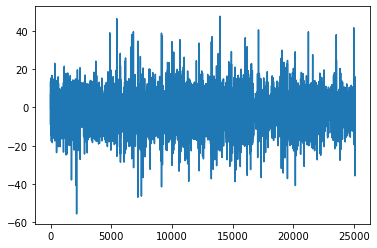

In [46]:
plt.plot(np.squeeze(diffSH_HMG))

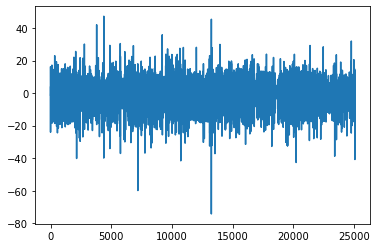

In [65]:
plt.plot(np.squeeze(diffSH_HTG))

### Now explore plotting and further analysis options

(1000.0, 100.0)

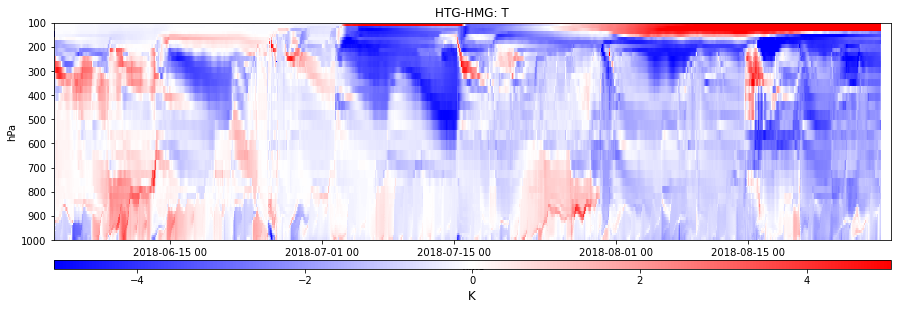

In [83]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time, HTGcamDS_all.lev.values, 
                                np.transpose(np.squeeze(HTGcamDS_all.T.values - HMGcamDS_all.T.values)),
                               vmin=-5, vmax=5,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all.T.units,fontsize=12)

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()

axs.set_title('HTG-HMG: T', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')
axs.set_ylim([1000,100])



(0.0, 15000.0)

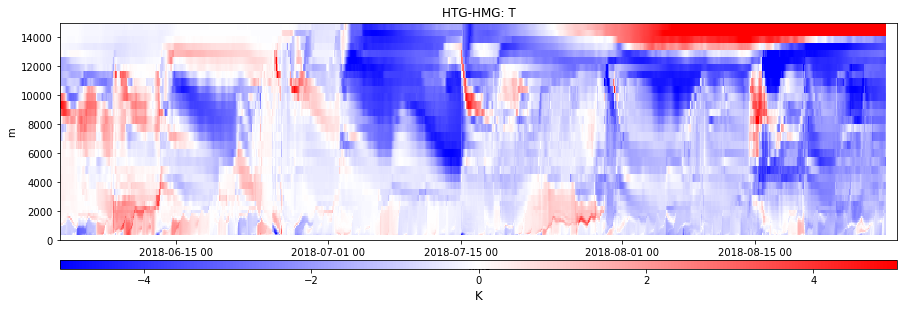

In [86]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_local.time, HTGcamDS_local.lev.values, 
                                np.transpose(np.squeeze(HTGcamDS_local.T.values - HMGcamDS_local.T.values)),
                               vmin=-5, vmax=5,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all.T.units,fontsize=12)

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

# axs.invert_yaxis()

axs.set_title('HTG-HMG: T', fontsize=12)
# axs.set_ylabel('hPa')
axs.set_ylabel('m')
axs.set_xlabel('Time')
# axs.set_ylim([1000,100])
axs.set_ylim([0,15000])



(1000.0, 100.0)

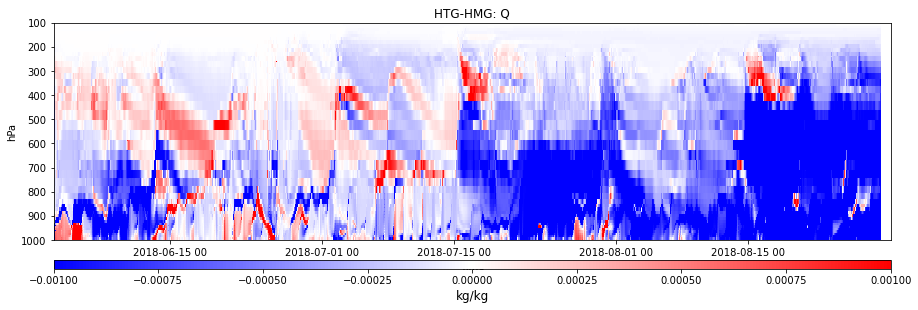

In [28]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGcamDS_all.time, HTGcamDS_all.lev.values, 
                                np.transpose(np.squeeze(HTGcamDS_all.Q.values - HMGcamDS_all.Q.values)),
                               vmin=-0.001, vmax=0.001,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HTGcamDS_all.Q.units,fontsize=12)

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()

axs.set_title('HTG-HMG: Q', fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')
axs.set_ylim([1000,100])




(3.0, 0.0)

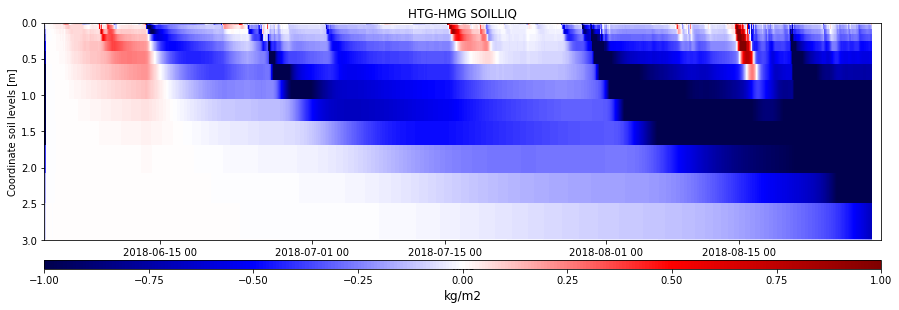

In [29]:
varPlot = 'SOILLIQ'
diffVar = HTGclmDS_all[varPlot].values[:,:,0] - HMGclmDS_all[varPlot].values[:,:,0]

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(HTGclmDS_all.time.values, HTGclmDS_all.levsoi.values, np.transpose(diffVar),
                                vmin=-1, vmax=1,
                                #levels=np.arange(-1,1.1,0.1),
                       cmap = 'seismic')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGclmDS_all[varPlot].units,fontsize=12)

startDay   = 2
startMonth = 6
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])

# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
    
axs.invert_yaxis()

axs.set_title('HTG-HMG '+varPlot, fontsize=12)
axs.set_ylabel('Coordinate soil levels [m]')
axs.set_xlabel('Time')
axs.set_ylim([3,0])




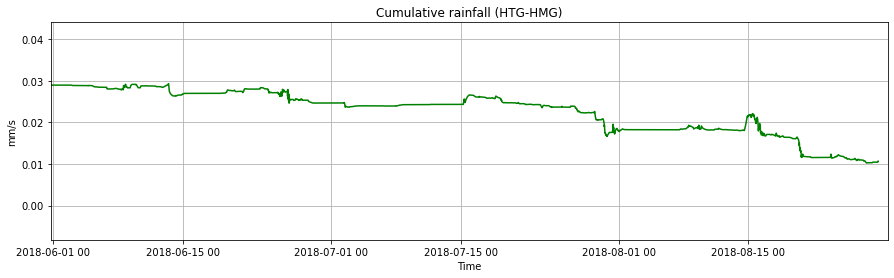

In [30]:
## CDF of rainfall over the summer 
fig,axs = plt.subplots(1,1, figsize=(15,4))

# axs.plot(HTGclmDS_all.time.values, HTGclmDS_all.RAIN.cumsum(dim='time'),'b-',label='HTG')
# axs.plot(HMGclmDS_all.time.values, HMGclmDS_all.RAIN.cumsum(dim='time'),'r-',label='HMG')

axs.plot(HTGclmDS_all.time.values, HTGclmDS_all.RAIN.cumsum(dim='time')-HMGclmDS_all.RAIN.cumsum(dim='time'),
         'g-',label='HTG-HMG')


startDay   = 31
startMonth = 5
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])


 # Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
    

axs.set_title('Cumulative rainfall (HTG-HMG)', fontsize=12)
axs.set_ylabel(HTGclmDS_all.RAIN.units)
axs.set_xlabel('Time')

axs.grid()



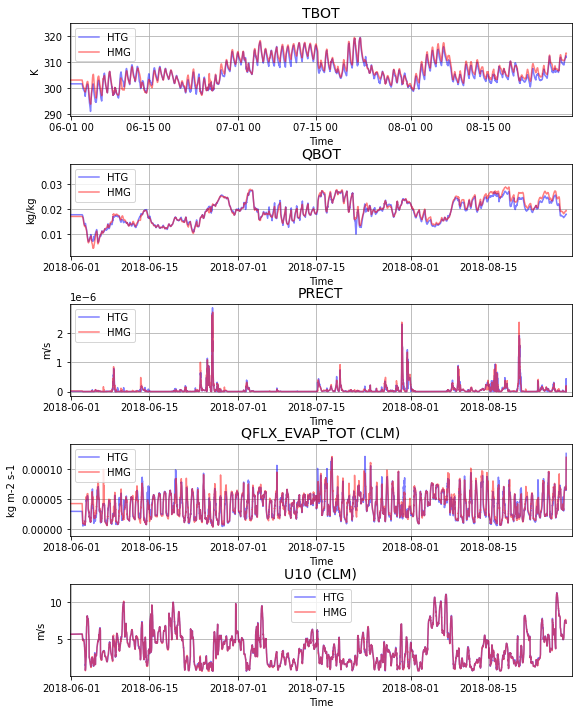

In [31]:
fig,axs = plt.subplots(5,1, figsize=(9,12))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.52)

axs[0].plot(HTGcamDS_all.time.values, HTGcamDS_all['T'].values[:,-1,0,0], 'b-', alpha=0.5, label='HTG')
axs[0].plot(HMGcamDS_all.time.values, HMGcamDS_all['T'].values[:,-1,0,0], 'r-', alpha=0.5, label='HMG')
axs[0].legend()
axs[0].set_title('TBOT', fontsize=14)
axs[0].set_ylabel(HTGcamDS_all['T'].units)

axs[1].plot(HTGcamDS_all.time.values, HTGcamDS_all['Q'].values[:,-1,0,0], 'b-', alpha=0.5, label='HTG')
axs[1].plot(HMGcamDS_all.time.values, HMGcamDS_all['Q'].values[:,-1,0,0], 'r-', alpha=0.5, label='HMG')
axs[1].legend()
axs[1].set_title('QBOT', fontsize=14)
axs[1].set_ylabel(HTGcamDS_all['Q'].units)

axs[2].plot(HTGcamDS_all.time.values, HTGcamDS_all['PRECT'].values[:,0,0], 'b-', alpha=0.5, label='HTG')
axs[2].plot(HMGcamDS_all.time.values, HMGcamDS_all['PRECT'].values[:,0,0], 'r-', alpha=0.5, label='HMG')
axs[2].legend()
axs[2].set_title('PRECT', fontsize=14)
axs[2].set_ylabel(HTGcamDS_all['PRECT'].units)

axs[3].plot(HTGclmDS_all.time.values, HTGclmDS_all['QFLX_EVAP_TOT'].values, 'b-', alpha=0.5, label='HTG')
axs[3].plot(HMGclmDS_all.time.values, HMGclmDS_all['QFLX_EVAP_TOT'].values, 'r-', alpha=0.5, label='HMG')
axs[3].legend()
axs[3].set_title('QFLX_EVAP_TOT (CLM)', fontsize=14)
axs[3].set_ylabel(HTGclmDS_all['QFLX_EVAP_TOT'].units)

axs[4].plot(HTGclmDS_all.time.values, HTGclmDS_all['U10'].values, 'b-', alpha=0.5, label='HTG')
axs[4].plot(HMGclmDS_all.time.values, HMGclmDS_all['U10'].values, 'r-', alpha=0.5, label='HMG')
axs[4].legend()
axs[4].set_title('U10 (CLM)', fontsize=14)
axs[4].set_ylabel(HTGclmDS_all['U10'].units)

# Set the options that are consistent across subplots
axs[0].set_xlabel('Time')
axs[1].set_xlabel('Time')
axs[2].set_xlabel('Time')
axs[3].set_xlabel('Time')
axs[4].set_xlabel('Time')

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()

startDay   = 31
startMonth = 5
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs[0].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])  
axs[1].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])  
axs[2].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])  
axs[3].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])  
axs[4].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])  

# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H')) 

# axs.set_xlim([datetime.date(2015,5,31), datetime.date(2015,6,4)])
# axs[0].set_xlim([datetime.date(2016,5,31), datetime.date(2016,6,3)])
# axs.set_ylim([15,30])





In [32]:
nateForcingFileHTG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-htg.nc'
nateDS_HTG = xr.open_dataset(nateForcingFileHTG, decode_times='True')

nateForcingFileHMG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.nc'
nateDS_HMG = xr.open_dataset(nateForcingFileHMG, decode_times='True')


nateDS_HMG

<xarray.Dataset>
Dimensions:       (lev: 37, time: 33600)
Coordinates:
  * time          (time) datetime64[ns] 2015-01-01 ... 2018-10-31T22:49:25.42...
  * lev           (lev) float32 1e+03 975.0 950.0 925.0 ... 150.0 125.0 100.0
Data variables:
    base_time     datetime64[ns] ...
    time_offset   (time) datetime64[ns] ...
    year          (time) float64 ...
    month         (time) float64 ...
    day           (time) float64 ...
    hour          (time) float64 ...
    minute        (time) float64 ...
    lat           float32 ...
    lon           float32 ...
    alt           float32 ...
    phis          float32 ...
    T             (time, lev) float32 ...
    q             (time, lev) float32 ...
    u             (time, lev) float32 ...
    v             (time, lev) float32 ...
    omega         (time, lev) float32 ...
    div           (time, lev) float32 ...
    T_adv_h       (time, lev) float32 ...
    T_adv_v       (time, lev) float32 ...
    q_adv_h       (time, lev) float32 ...
    q_adv_v       (time, lev) float32 ...
    s             (time, lev) float32 ...
    s_adv_h       (time, lev) float32 ...
    s_adv_v       (time, lev) float32 ...
    dsdt          (time, lev) float32 ...
    dTdt          (time, lev) float32 ...
    dqdt          (time, lev) float32 ...
    q1            (time, lev) float32 ...
    q2            (time, lev) float32 ...
    prec_srf      (time) float32 ...
    LH            (time) float32 ...
    SH            (time) float32 ...
    p_srf_aver    (time) float32 ...
    p_srf_center  (time) float32 ...
    T_srf         (time) float32 ...
    T_soil        (time) float32 ...
    RH_srf        (time) float32 ...
    wspd_srf      (time) float32 ...
    u_srf         (time) float32 ...
    v_srf         (time) float32 ...
    rad_net_srf   (time) float32 ...
    lw_net_toa    (time) float32 ...
    sw_net_toa    (time) float32 ...
    sw_dn_toa     (time) float32 ...
    cld_low       (time) float32 ...
    cld_mid       (time) float32 ...
    cld_high      (time) float32 ...
    cld_tot       (time) float32 ...
    cld_thick     (time) float32 ...
    cld_top       (time) float32 ...
    LWP           (time) float32 ...
    dh2odt_col    (time) float32 ...
    h2o_adv_col   (time) float32 ...
    evap_srf      (time) float32 ...
    dsdt_col      (time) float32 ...
    s_adv_col     (time) float32 ...
    rad_heat_col  (time) float32 ...
    LH_col        (time) float32 ...
    omega_srf     (time) float32 ...
    q_srf         (time) float32 ...
    s_srf         (time) float32 ...
    PW            (time) float32 ...
    lw_up_srf     (time) float32 ...
    lw_dn_srf     (time) float32 ...
    sw_up_srf     (time) float32 ...
    sw_dn_srf     (time) float32 ...
    T_skin        (time) float32 ...
    TEST          (time) float64 ...
    wpqtp_sfc     (time) float32 ...
    wpthlp_sfc    (time) float32 ...
    qp2           (time) float32 ...
    thlp2         (time) float32 ...
    thlpqp        (time) float32 ...
    wp2           (time) float32 ...
    wp4           (time) float32 ...
    wp2thetap     (time) float32 ...
    wp2qp         (time) float32 ...
    wpqp2         (time) float32 ...
    wpthetap2     (time) float32 ...
    wpthetapqp    (time) float32 ...
    wp3           (time) float32 ...
    upwp          (time) float32 ...
    vpwp          (time) float32 ...
Attributes:
    Conventions:   CF-1.7
    title:         VarAna 1hr RAP_Based v2: SGP 2015-01
    history:       Mon Feb 17 20:27:23 2020: ncrcat sgp60varanarapC1.c1.20150...
    update:        surface LH and SH are merged from ECOR and EBBR instruments
    date_created:  Thu Apr 13 20:12:17 2017
    contact:       Shuaiqi Tang: tang32@llnl.gov, Qi Tang: tang30@llnl.gov, Y...
    program_name:  proc_output_nwp.pro
    institution:   Lawrence Livermore National Laboratory, CA, USA
    references:    https://www.arm.gov/data/data-sources/varanal-29
    note:          Data below the surface are set to lowest a

(17682.75, 17773.0)

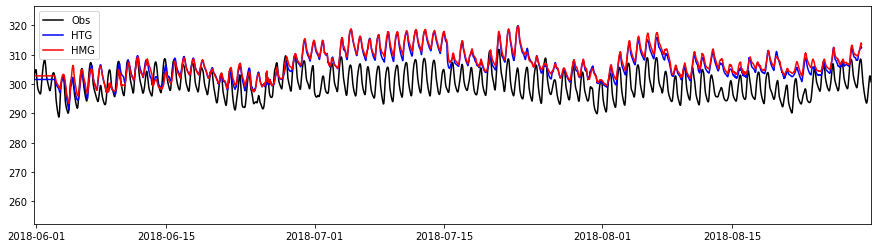

In [34]:
fig,axs = plt.subplots(1,1, figsize=(15,4))
axs.plot(nateDS_HMG.time.values, nateDS_HMG.T_srf.values+273.15,'k-',label='Obs')
axs.plot(HTGcamDS_all.time.values, np.squeeze(HTGcamDS_all.TREFHT.values),'b-', label='HTG')
axs.plot(HMGcamDS_all.time.values, np.squeeze(HMGcamDS_all.TREFHT.values),'r-', label='HMG')

axs.legend()

startDay   = 31
startMonth = 5
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])


#### Mean diurnal cycles

In [126]:
# Get means a function of hour of day
hourlyMean_HMG = HMGcamDS_local.groupby("time.hour").mean()
hourlyMean_HTG = HTGcamDS_local.groupby("time.hour").mean()

hourlyMeanCLM_HMG = HMGclmDS_local.groupby("time.hour").mean()
hourlyMeanCLM_HTG = HTGclmDS_local.groupby("time.hour").mean()

hourlyMeanCLMpatch_HMG = HMGclmDS_patch_local.groupby("time.hour").mean()
hourlyMeanCLMpatch_HTG = HTGclmDS_patch_local.groupby("time.hour").mean()


In [110]:
## Test out getting standard deviation for each hour, not just mean too...
hourlyStd_HMG = HMGcamDS_local.groupby("time.hour").std(dim='time')
hourlyStd_HTG = HTGcamDS_local.groupby("time.hour").std(dim='time')

# Want to use standar *error*, which is the std divided by the sqrt of the number of samples
#   So first, let s get the number of samples per hour 
nTimes = np.full([24], np.nan)

for iHr in range(len(nTimes)): 
    nTimes[iHr] = len(np.where(HMGcamDS_local["time.hour"]==iHr)[0])

hourlyMean_HMG['SampleCount']         = (('hour'), nTimes)
hourlyMean_HTG['SampleCount']         = (('hour'), nTimes)
hourlyMeanCLM_HMG['SampleCount']      = (('hour'), nTimes)
hourlyMeanCLM_HTG['SampleCount']      = (('hour'), nTimes)
hourlyMeanCLMpatch_HMG['SampleCount'] = (('hour'), nTimes)
hourlyMeanCLMpatch_HTG['SampleCount'] = (('hour'), nTimes)


# ## Sanity check that xarray .std does what I think it does: (checks out)
# iHour = np.where(HMGcamDS_local["time.hour"].values==8)[0]
# meanPBLH = np.nanmean(HMGcamDS_local.PBLdepth.values[(iHour)],axis=0)

# sumStd = 0.0
# countLen = 0.0
# for iTime in range(len(iHour)):
#     sumStd = sumStd + ((HMGcamDS_local.PBLdepth.values[iHour[iTime]] - meanPBLH)**2.0)
#     countLen = countLen+1

# stdPBLH = np.sqrt(sumStd/countLen)

# print('Mean by hand = %.3f' % meanPBLH)
# print('Mean by xr   = %.3f' % hourlyMean_HMG.PBLdepth.values[8])
# print('\nStd by hand = %.3f' % stdPBLH)
# print('Std by xr   = %.3f' % hourlyStd_HMG.PBLdepth.values[8])


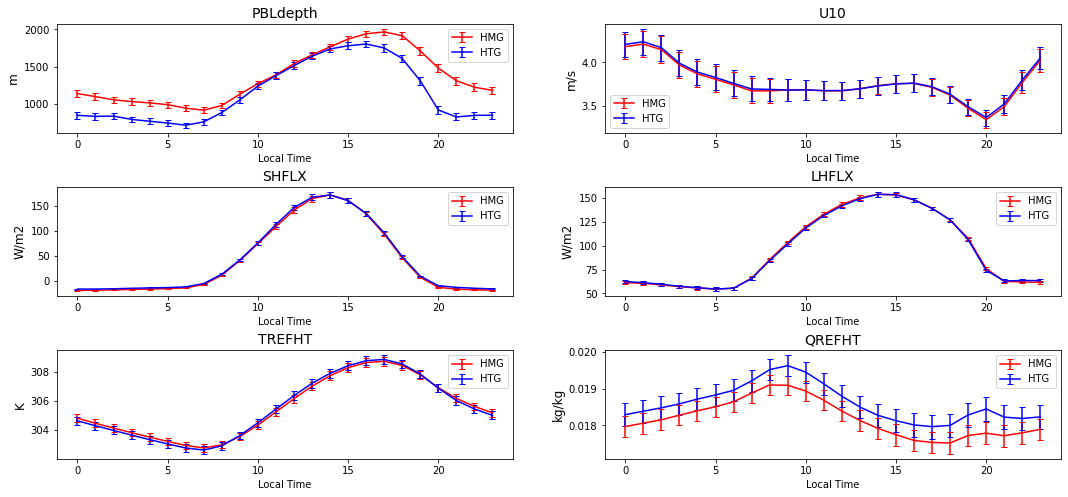

In [111]:
fig,axs = plt.subplots(3,2, figsize=(18,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLdepth','U10','SHFLX','LHFLX','TREFHT','QREFHT'])
# ATM_varNames = np.asarray(['TGCLDLWP','U10','SHFLX','LHFLX','TREFHT','RHREFHT'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):       
    axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
                       yerr = 2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values)/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                      fmt='r-',capsize=3,label='HMG')
    axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
                       yerr = 2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values)/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                      fmt='b-',capsize=3,label='HTG')
    
#     axs[iVar].plot(hourlyMean_HMG['hour'].values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
#                   'r-', alpha=0.7, label='CAM-HMG')
#     axs[iVar].plot(hourlyMean_HTG['hour'].values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
#                   'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]=='TBOT':
        axs[iVar].set_ylabel(HMGcamDS['T'].units, fontsize=12)
    elif ATM_varNames[iVar]=='PBLdepth':
        axs[iVar].set_ylabel(HMGcamDS['PBLH'].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
        

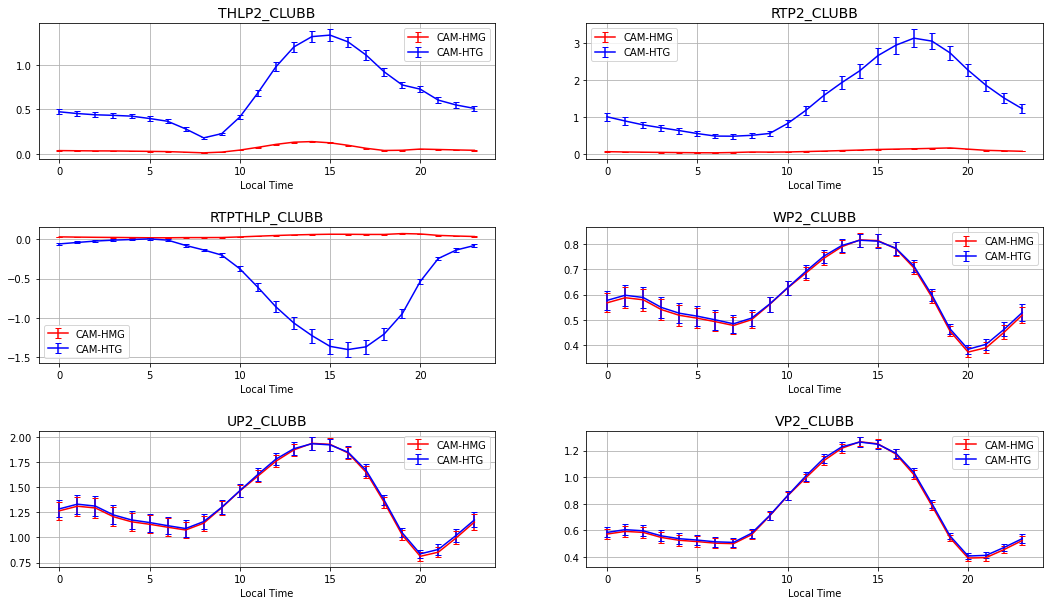

In [39]:
fig,axs = plt.subplots(3,2, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
    # Make it show in local time 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')
    
    else: 
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    axs[iVar].grid()
    
        

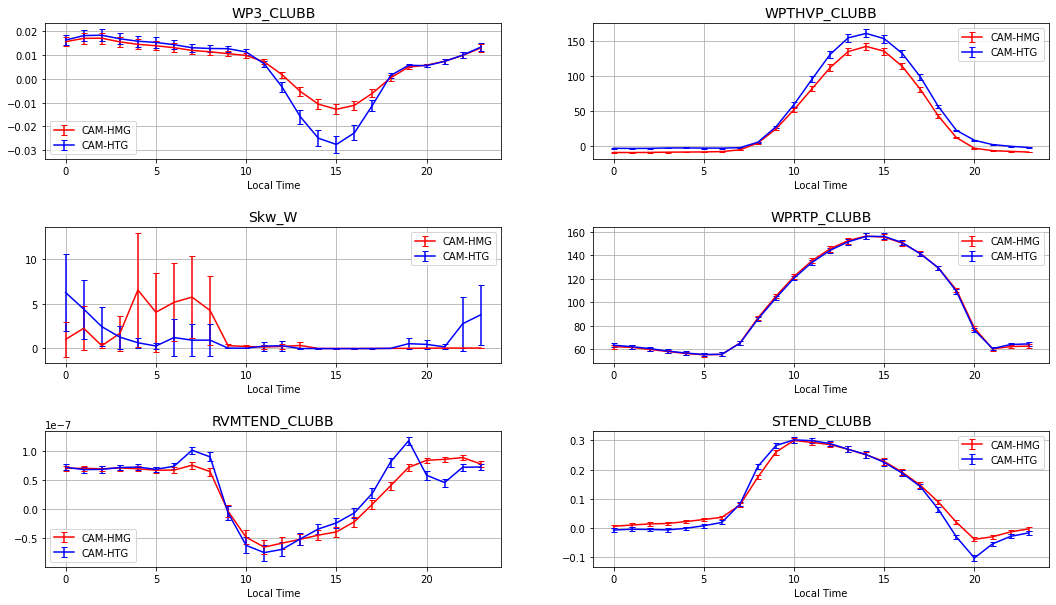

In [28]:
fig,axs = plt.subplots(3,2, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','Skw_W','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
    # Make it show in local time 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-2,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-2,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')
        
    elif ATM_varNames[iVar]=='Skw_W':
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-2]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-2])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-2]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-2])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')
    
    else: 
        axs[iVar].errorbar(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HMG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HMG['SampleCount'].values),
                  fmt='r-', capsize=3, label='CAM-HMG')
        axs[iVar].errorbar(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-1,:,:]),
                           yerr=2*np.squeeze(hourlyStd_HTG[ATM_varNames[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_HTG['SampleCount'].values),
                  fmt='b-', capsize=3, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    axs[iVar].grid()
        

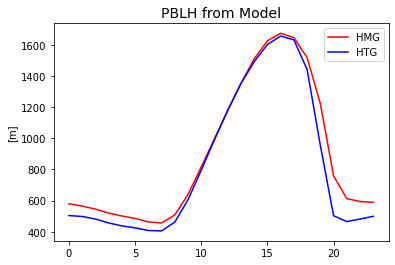

In [43]:
plt.plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG.PBLH.values), 'r', label='HMG')
plt.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG.PBLH.values), 'b', label='HTG')
# plt.title('PBLH diagnosed from maximum dQ/dz',fontsize=14)
plt.title('PBLH from Model',fontsize=14)
plt.ylabel('[m]')
plt.legend()



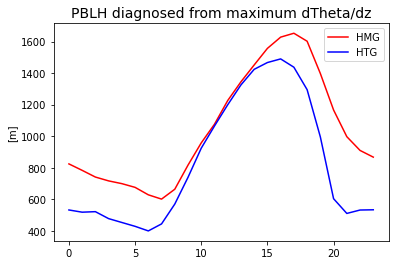

In [134]:
plt.plot(hourlyMean_HMG.hour.values, hourlyMean_HMG.PBLdepth.values-315, 'r', label='HMG')
plt.plot(hourlyMean_HTG.hour.values, hourlyMean_HTG.PBLdepth.values-315, 'b', label='HTG')
# plt.title('PBLH diagnosed from maximum dQ/dz',fontsize=14)
plt.title('PBLH diagnosed from maximum dTheta/dz',fontsize=14)
plt.ylabel('[m]')
plt.legend()


Text(0.5, 1.0, 'std(ET) from patch level')

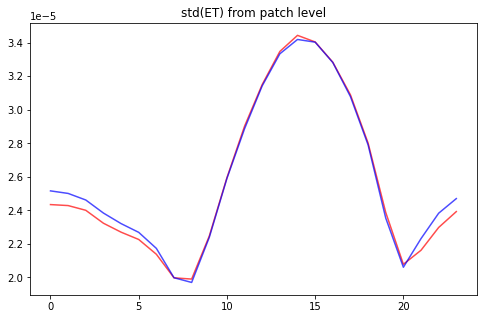

In [44]:
## Are there patches that have peaks in ET that might match above 

fig,axs = plt.subplots(1,1, figsize=(8,5))

axs.plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMeanCLM_HMG['stdET'].values),
          'r-', alpha=0.7, label='CAM-HMG')
axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLM_HTG['stdET'].values),
          'b-', alpha=0.7, label='CAM-HTG')

axs.set_title('std(ET) from patch level')


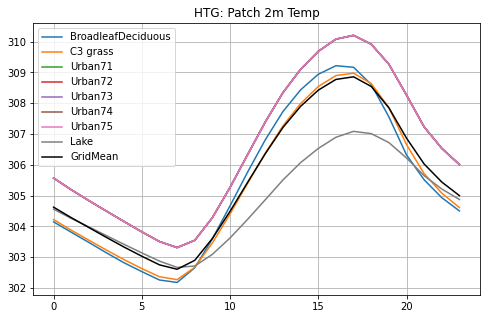

In [45]:
fig,axs = plt.subplots(1,1, figsize=(8,5))

for iPatch in range(len(hourlyMeanCLMpatch_HTG.pft.values)):
    axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLMpatch_HTG['TSA'].values[:, iPatch]),
             label=patchLabels[iPatch])
    
axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLM_HTG['TSA'].values),'k-', label='GridMean')

axs.set_title('HTG: Patch 2m Temp')
axs.legend()

axs.grid()


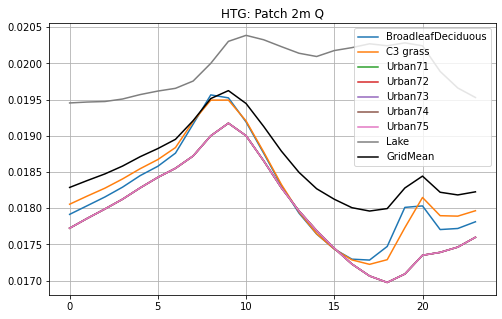

In [46]:
fig,axs = plt.subplots(1,1, figsize=(8,5))

for iPatch in range(len(hourlyMeanCLMpatch_HTG.pft.values)):
    axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLMpatch_HTG['Q2M'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLM_HTG['Q2M'].values),'k-', label='GridMean')

axs.set_title('HTG: Patch 2m Q')
axs.legend()

axs.grid()



Text(0, 0.5, 'hPa')

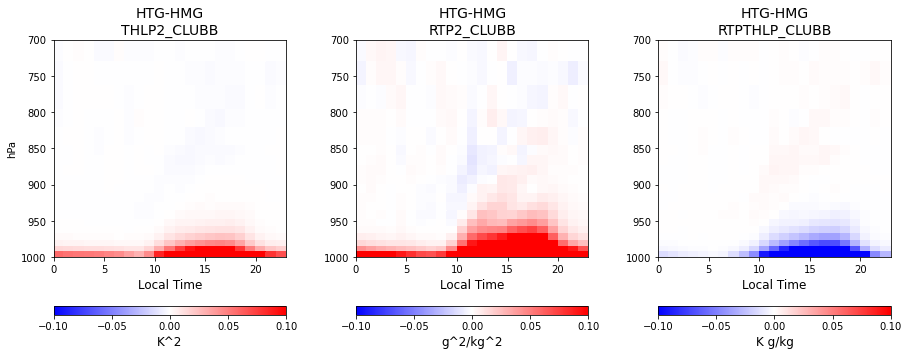

In [30]:
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.3)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(3):
    diffVar = hourlyMean_HTG[ATM_varNames[iVar]].values - hourlyMean_HMG[ATM_varNames[iVar]].values

    contour_plot = axs[iVar].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              np.squeeze(diffVar.transpose()),
                             vmin=-0.1, vmax=0.1, cmap='bwr')
    # Add colorbar 
    ax_position = axs[iVar].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(HMGcamDS_local[ATM_varNames[iVar]].units,fontsize=12)

    axs[iVar].invert_yaxis()
    axs[iVar].set_xlabel('Local Hour', fontsize=12)
    axs[iVar].set_title('HTG-HMG\n'+ATM_varNames[iVar], fontsize=14)
    axs[iVar].set_xlabel('Local Time',fontsize=12)
    axs[iVar].set_ylim([1000,700])

axs[0].set_ylabel('hPa')


Text(0, 0.5, 'hPa')

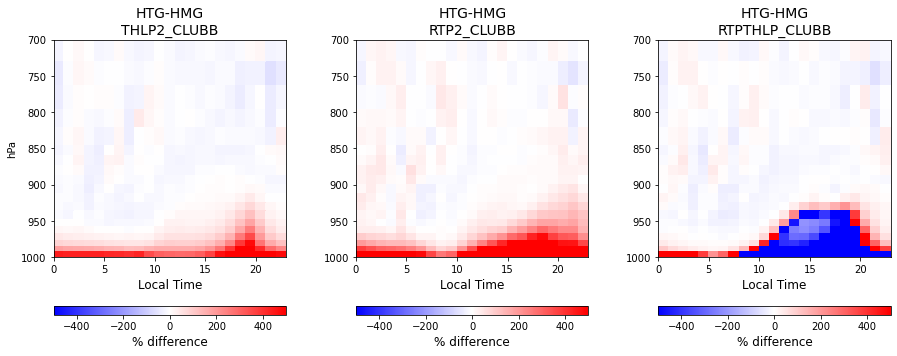

In [48]:
## Plot as percent difference rather than raw difference as above

fig,axs = plt.subplots(1,3, figsize=(15,4))
axs = axs.ravel()
fig.subplots_adjust(wspace=0.3)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(3):
    diffVar = (hourlyMean_HTG[ATM_varNames[iVar]].values - hourlyMean_HMG[ATM_varNames[iVar]].values)/hourlyMean_HMG[ATM_varNames[iVar]].values

    contour_plot = axs[iVar].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              np.squeeze((diffVar*100.0).transpose()),
                             vmin=-500, vmax=500, cmap='bwr')
    # Add colorbar 
    ax_position = axs[iVar].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label('% difference',fontsize=12)

    axs[iVar].invert_yaxis()
    axs[iVar].set_xlabel('Local Hour', fontsize=12)
    axs[iVar].set_title('HTG-HMG\n'+ATM_varNames[iVar], fontsize=14)
    axs[iVar].set_xlabel('Local Time',fontsize=12)
    axs[iVar].set_ylim([1000,700])

axs[0].set_ylabel('hPa')



Text(0, 0.5, 'hPa')

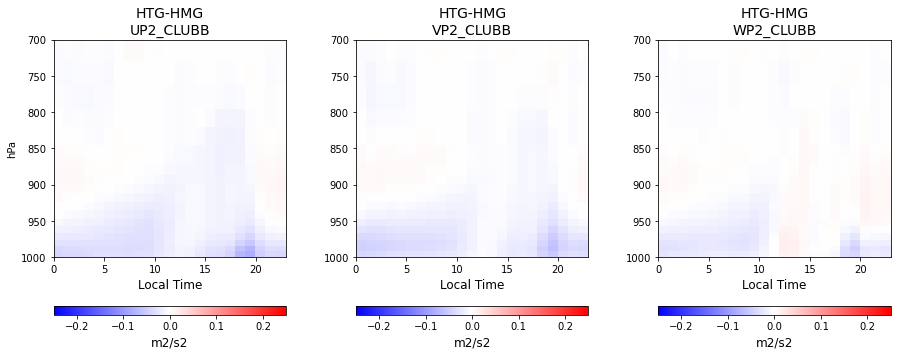

In [49]:
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs = axs.ravel()
fig.subplots_adjust(wspace=0.3)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['UP2_CLUBB','VP2_CLUBB','WP2_CLUBB'])

for iVar in range(3):
    diffVar = (hourlyMean_HTG[ATM_varNames[iVar]].values - hourlyMean_HMG[ATM_varNames[iVar]].values)

    contour_plot = axs[iVar].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              np.squeeze((diffVar).transpose()),
                             vmin=-0.25, vmax=0.25, cmap='bwr')
    # Add colorbar 
    ax_position = axs[iVar].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=12)

    axs[iVar].invert_yaxis()
    axs[iVar].set_xlabel('Local Hour', fontsize=12)
    axs[iVar].set_title('HTG-HMG\n'+ATM_varNames[iVar], fontsize=14)
    axs[iVar].set_xlabel('Local Time',fontsize=12)
    axs[iVar].set_ylim([1000,700])

axs[0].set_ylabel('hPa')



#### Bin by some controlling variable (i.e., precip or soil moisture along x axis), then plot profiles of different things that way

**Would this all view better with actual profiles??** <br>
*Use DAILY MEANS*

In [26]:
## Get daily means
HMGcamDS_localDailyMean = HMGcamDS_local.groupby('year_month_day').mean()
HTGcamDS_localDailyMean = HTGcamDS_local.groupby('year_month_day').mean()

HMGclmDS_localDailyMean = HMGclmDS_local.groupby('year_month_day').mean()
HTGclmDS_localDailyMean = HTGclmDS_local.groupby('year_month_day').mean()

## Add in daily total rain for fun... 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()

# Add to daily mean arrays above
HMGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySum['PRECT_mmPerDT'].values)
HTGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySum['PRECT_mmPerDT'].values)


In [51]:
# So what if we take, say, percentiles of a controlVar 
controlVar = 'SOILWATER_10CM'
# controlVar = 'stdET'
pctSel     = np.arange(10,100,10) 

HTG_pctCtrlValues = np.percentile(HTGclmDS_localDailyMean[controlVar].values, pctSel)
HMG_pctCtrlValues = np.percentile(HMGclmDS_localDailyMean[controlVar].values, pctSel)

pctSelThirds     = np.asarray([33.33, 66.66]) 
HTG_pctCtrlValuesThirds = np.percentile(HTGclmDS_localDailyMean[controlVar].values, pctSelThirds)
HMG_pctCtrlValuesThirds = np.percentile(HMGclmDS_localDailyMean[controlVar].values, pctSelThirds)

# ## controlVar in CAM
# controlVar = 'PRECTdailySum'
# pctSel     = np.arange(10,100,10) 

# HTG_pctCtrlValues = np.percentile(HTGcamDS_localDailyMean[controlVar].values, pctSel)
# HMG_pctCtrlValues = np.percentile(HMGcamDS_localDailyMean[controlVar].values, pctSel)

# pctSelThirds     = np.asarray([33.33, 66.66]) 
# HTG_pctCtrlValuesThirds = np.percentile(HTGcamDS_localDailyMean[controlVar].values, pctSelThirds)
# HMG_pctCtrlValuesThirds = np.percentile(HMGcamDS_localDailyMean[controlVar].values, pctSelThirds)



In [346]:
## Maybe we do want consistent bin definitions, at least? 
binSelSame = np.full([len(pctSel)], np.nan)
for iBin in range(len(pctSel)):
    binSelSame[iBin] = np.nanmean([HTG_pctCtrlValues[iBin], HMG_pctCtrlValues[iBin]])
    
## Maybe we do want consistent bin definitions, at least? 
# for Thirds...
binSelSameThirds = np.full([len(pctSelThirds)], np.nan)
for iBin in range(len(pctSelThirds)):
    binSelSameThirds[iBin] = np.nanmean([HTG_pctCtrlValuesThirds[iBin], HMG_pctCtrlValuesThirds[iBin]])

print('Bottom third cutoff: %.2f' % (binSelSameThirds[0]))
print('Top third cutoff: %.2f' % (binSelSameThirds[1]))  

Bottom third cutoff: 25.32
Top third cutoff: 30.15


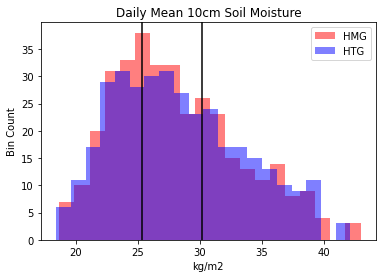

In [355]:
plt.hist((HMGclmDS_localDailyMean[controlVar].values).reshape([len(HMGclmDS_localDailyMean.year_month_day.values)]), 
         bins=20, facecolor='r',alpha=0.5)
plt.hist((HTGclmDS_localDailyMean[controlVar].values).reshape([len(HTGclmDS_localDailyMean.year_month_day.values)]), 
         bins=20, facecolor='b',alpha=0.5)
plt.legend(['HMG','HTG'])
plt.title('Daily Mean 10cm Soil Moisture')
plt.ylabel('Bin Count')
plt.xlabel(HMGclmDS_all[controlVar].units)

plt.axvline(binSelSameThirds[0], color='k')
plt.axvline(binSelSameThirds[1], color='k')

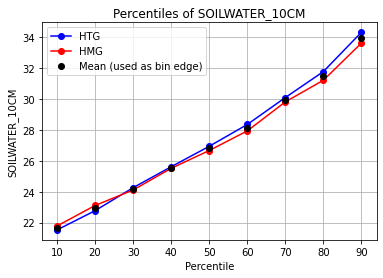

In [46]:
plt.plot(pctSel, HTG_pctCtrlValues, 'b-o', label='HTG')
plt.plot(pctSel, HMG_pctCtrlValues, 'r-o', label='HMG')
plt.plot(pctSel, binSelSame, 'ko', label='Mean (used as bin edge)')
plt.xlabel('Percentile')
plt.ylabel(controlVar)
plt.title('Percentiles of '+controlVar)
plt.legend()
plt.grid()

Now isolate arrays that correspond to those percentiles...

In [53]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnPercentile(fullDS, pctDS):
    iTimes = []
    
    for iTime in range(len(pctDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==pctDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==pctDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==pctDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayPct = fullDS.isel(time=iTimes)
    
    return(DS_dayPct)


In [54]:
# Now get all the times where daily mean controlVar falls into each bin
binSel = binSelSameThirds
HMGbin_bot30 = np.where((HMGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]
HMGbin_top30 = np.where((HMGclmDS_localDailyMean[controlVar].values > binSel[1]))[0]

HTGbin_bot30 = np.where((HTGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]
HTGbin_top30 = np.where((HTGclmDS_localDailyMean[controlVar].values > binSel[1]))[0]



In [280]:
# ## ControlVar in CAM 

# binSel = binSelSameThirds
# HMGbin_bot30 = np.where((HMGcamDS_localDailyMean[controlVar].values <= binSel[0]))[0]
# HMGbin_top30 = np.where((HMGcamDS_localDailyMean[controlVar].values > binSel[1]))[0]

# HTGbin_bot30 = np.where((HTGcamDS_localDailyMean[controlVar].values <= binSel[0]))[0]
# HTGbin_top30 = np.where((HTGcamDS_localDailyMean[controlVar].values > binSel[1]))[0]



In [55]:
## Want to use the same days in HMG and HTG bins (at least for wet/dry singular bins)

setHTG_bot30 = set(HTGbin_bot30)
setHMG_bot30 = set(HMGbin_bot30)
iKeep_bot30  = list(setHTG_bot30 & setHMG_bot30)

setHTG_top30 = set(HTGbin_top30)
setHMG_top30 = set(HMGbin_top30)
iKeep_top30  = list(setHTG_top30 & setHMG_top30)

print('Number of days with low soil moisture: ', len(iKeep_bot30))
print('Number of days with high soil moisture: ', len(iKeep_top30))


Number of days with low soil moisture:  110
Number of days with high soil moisture:  107


In [56]:
HMGcam_bot30 = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=iKeep_bot30))
HMGclm_bot30 = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=iKeep_bot30))

HTGcam_bot30 = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=iKeep_bot30))
HTGclm_bot30 = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=iKeep_bot30))


HMGcam_top30 = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=iKeep_top30))
HMGclm_top30 = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=iKeep_top30))

HTGcam_top30 = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=iKeep_top30))
HTGclm_top30 = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=iKeep_top30))



**What if we look at a few bins for their average daily response**

In [57]:
hourlyMeanBot30_HTG = HTGcam_bot30.groupby("time.hour").mean()
hourlyMeanTop30_HTG = HTGcam_top30.groupby("time.hour").mean()

hourlyMeanBot30_HMG = HMGcam_bot30.groupby("time.hour").mean()
hourlyMeanTop30_HMG = HMGcam_top30.groupby("time.hour").mean()

## Also be able to get std error 
hourlyStdBot30_HTG = HTGcam_bot30.groupby("time.hour").std(dim='time')
hourlyStdTop30_HTG = HTGcam_top30.groupby("time.hour").std(dim='time')

hourlyStdBot30_HMG = HMGcam_bot30.groupby("time.hour").std(dim='time')
hourlyStdTop30_HMG = HMGcam_top30.groupby("time.hour").std(dim='time')

nSampleHrs_bot30 = np.full([24], np.nan)
nSampleHrs_top30 = np.full([24], np.nan)
for iHr in range(24):
    iSelHour_bot30 = np.where(HTGcam_bot30['time.hour'].values==iHr)[0]
    iSelHour_top30 = np.where(HTGcam_top30['time.hour'].values==iHr)[0]

    nSampleHrs_bot30[iHr] = len(iSelHour_bot30)
    nSampleHrs_top30[iHr] = len(iSelHour_top30)
    

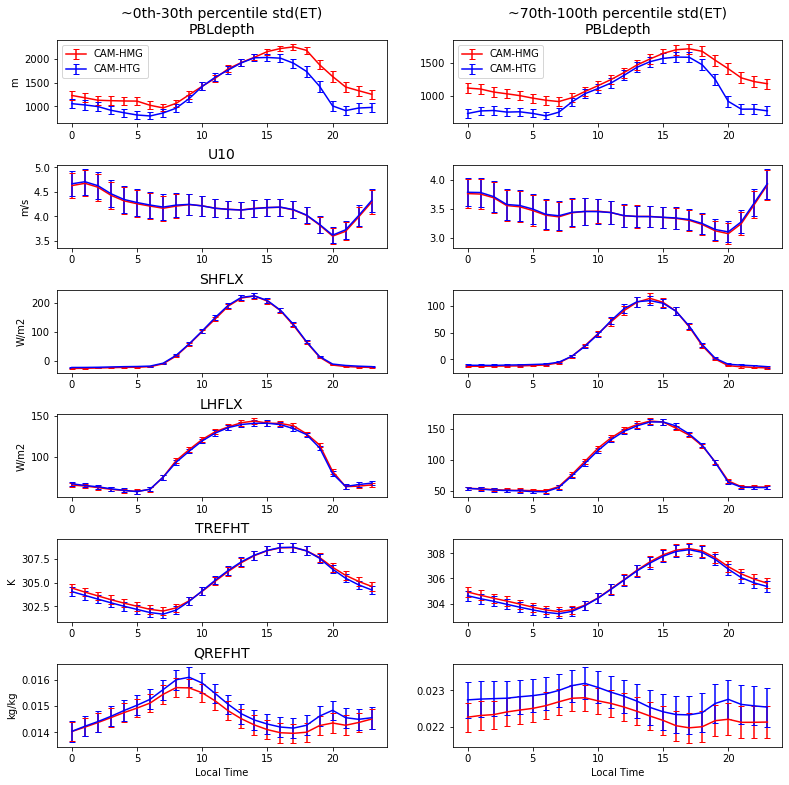

In [63]:
fig,axs = plt.subplots(6,2, figsize=(13,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLdepth','U10','SHFLX','LHFLX','TREFHT','QREFHT'])

yMax = np.asarray([2400, 5.5, 250, 200, 310, 0.026])
yMin = np.asarray([ 100, 3,   -40, -5,  300, 0.013])

iPlot = 0
for iVar in range(6): 
    
    ## Plot 0-30th percentile bin
    axs[iPlot].errorbar(hourlyMeanBot30_HMG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values),
                        yerr =2*np.squeeze(hourlyStdBot30_HMG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_bot30),
                        fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot].errorbar(hourlyMeanBot30_HTG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values),
                        yerr = 2*np.squeeze(hourlyStdBot30_HTG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_bot30),
                        fmt='b-', capsize=3, label='CAM-HTG') 
#     axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 70-100th percentile bin
    axs[iPlot+1].errorbar(hourlyMeanTop30_HMG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values),
                          yerr=2*np.squeeze(hourlyStdTop30_HMG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_top30),
                          fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot+1].errorbar(hourlyMeanTop30_HTG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values),
                          yerr=2*np.squeeze(hourlyStdTop30_HTG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_top30),
                          fmt='b-', capsize=3, label='CAM-HTG') 
#     axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    if ATM_varNames[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HMGcamDS_local['PBLH'].units)
    else:
        axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~0th-30th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~70th-100th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()

    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
        

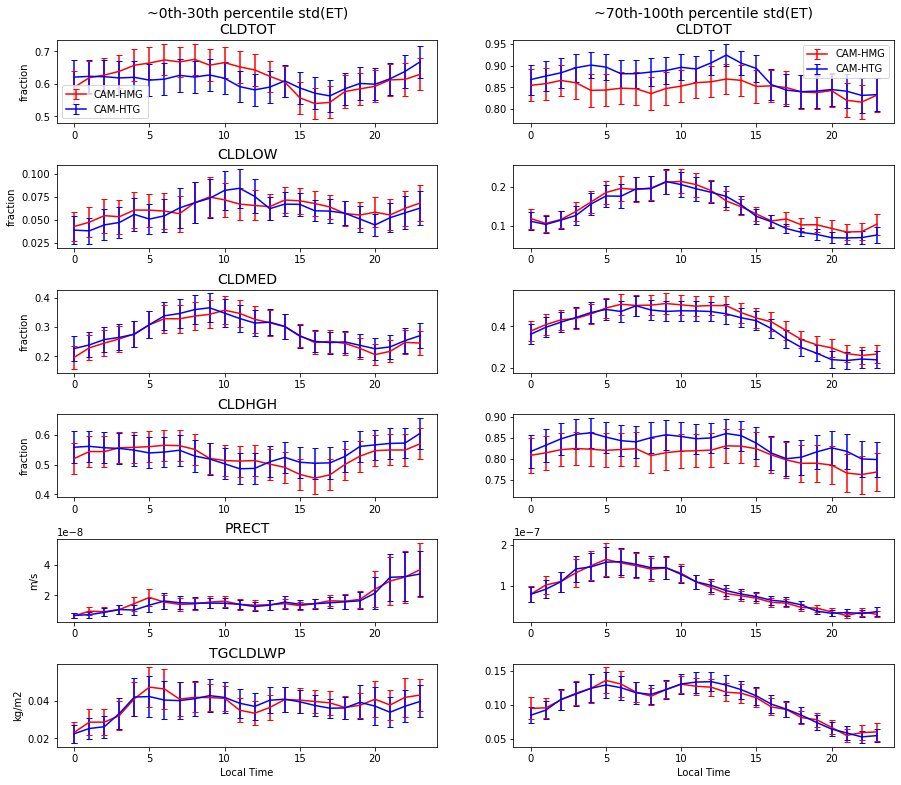

In [64]:
fig,axs = plt.subplots(6,2, figsize=(15,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['CLDTOT','CLDLOW','CLDMED','CLDHGH','PRECT','TGCLDLWP'])

yMax = np.asarray([2300, 7, 300, 300, 315, 0.025])
yMin = np.asarray([ 100, 2, -40, -40, 295, 0.001])

iPlot = 0
for iVar in range(6): 
    
    ## Plot 0-30th percentile bin
    axs[iPlot].errorbar(hourlyMeanBot30_HMG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values),
                        yerr =2*np.squeeze(hourlyStdBot30_HMG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_bot30),
                        fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot].errorbar(hourlyMeanBot30_HTG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values),
                        yerr = 2*np.squeeze(hourlyStdBot30_HTG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_bot30),
                        fmt='b-', capsize=3, label='CAM-HTG') 
#     axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 70-100th percentile bin
    axs[iPlot+1].errorbar(hourlyMeanTop30_HMG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values),
                          yerr=2*np.squeeze(hourlyStdTop30_HMG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_top30),
                          fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot+1].errorbar(hourlyMeanTop30_HTG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values),
                          yerr=2*np.squeeze(hourlyStdTop30_HTG[ATM_varNames[iVar]].values)/np.sqrt(nSampleHrs_top30),
                          fmt='b-', capsize=3, label='CAM-HTG') 

#     axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    if ATM_varNames[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HMGcamDS_local['PBLH'].units)
    else:
        axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~0th-30th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~70th-100th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()

    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
        

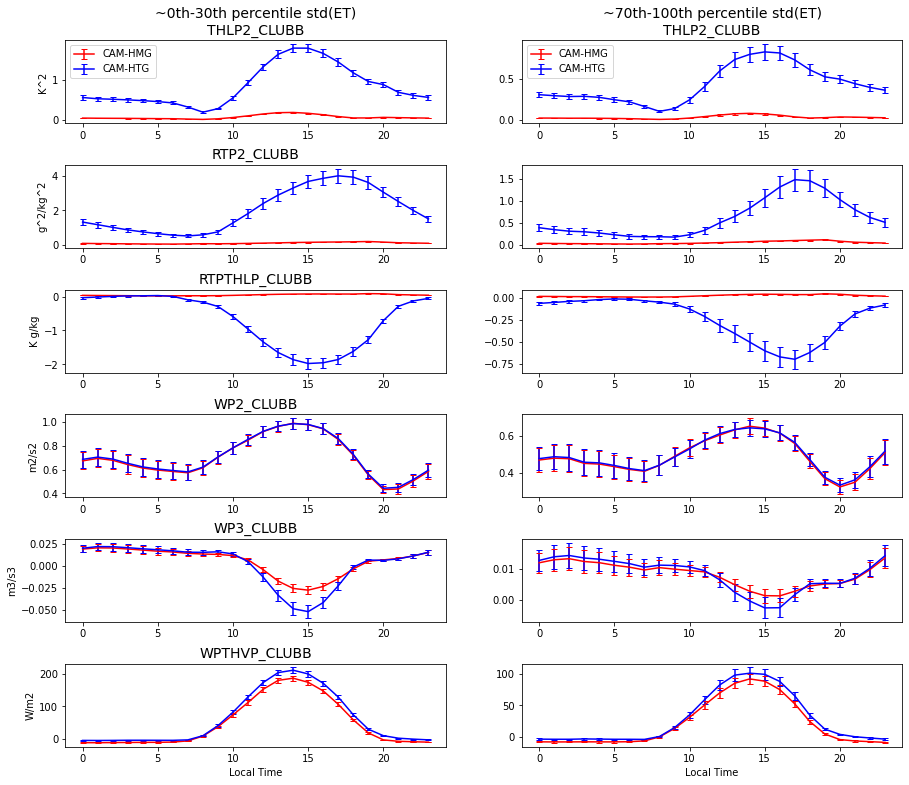

In [65]:
fig,axs = plt.subplots(6,2, figsize=(15,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB','WPTHVP_CLUBB'])
# Define limits on y-axis by variable
ylimMax = np.asarray([2.0, 4.75, 0.1, 1.2,  0.02, 250])
ylimMin = np.asarray([0.0, 0.0, -2.25, 0.0, -0.06, -25])

iPlot = 0
for iVar in range(6): 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        levSel = -2
    else:
        levSel = -1
    
     ## Plot 0-30th percentile bin
    axs[iPlot].errorbar(hourlyMeanBot30_HMG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                        yerr =2*np.squeeze(hourlyStdBot30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:])/np.sqrt(nSampleHrs_bot30),
                        fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot].errorbar(hourlyMeanBot30_HTG.hour.values, 
                        np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                        yerr = 2*np.squeeze(hourlyStdBot30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:])/np.sqrt(nSampleHrs_bot30),
                        fmt='b-', capsize=3, label='CAM-HTG') 
#     axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 70-100th percentile bin
    axs[iPlot+1].errorbar(hourlyMeanTop30_HMG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                          yerr=2*np.squeeze(hourlyStdTop30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:])/np.sqrt(nSampleHrs_top30),
                          fmt='r-', capsize=3, label='CAM-HMG')
    axs[iPlot+1].errorbar(hourlyMeanTop30_HTG.hour.values, 
                          np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                          yerr=2*np.squeeze(hourlyStdTop30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:])/np.sqrt(nSampleHrs_top30),
                          fmt='b-', capsize=3, label='CAM-HTG') 

    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~0th-30th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~70th-100th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')

    
    iPlot = iPlot+2
    

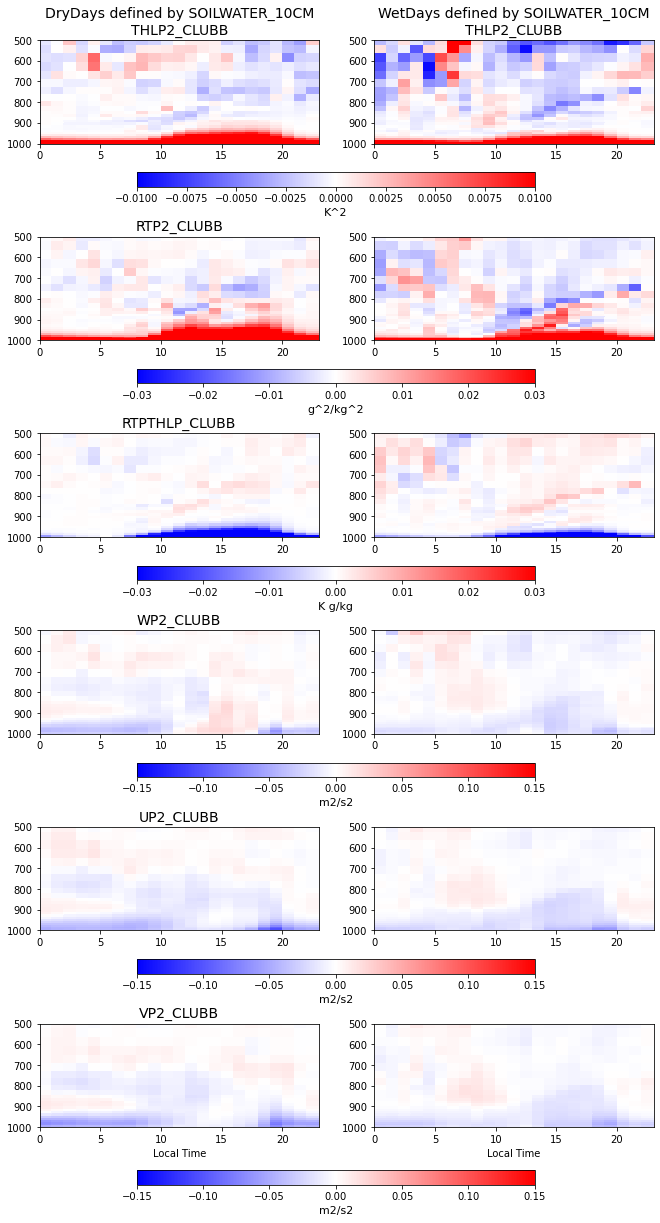

In [66]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 0.03, 0.03, 0.15, 0.15, 0.15])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

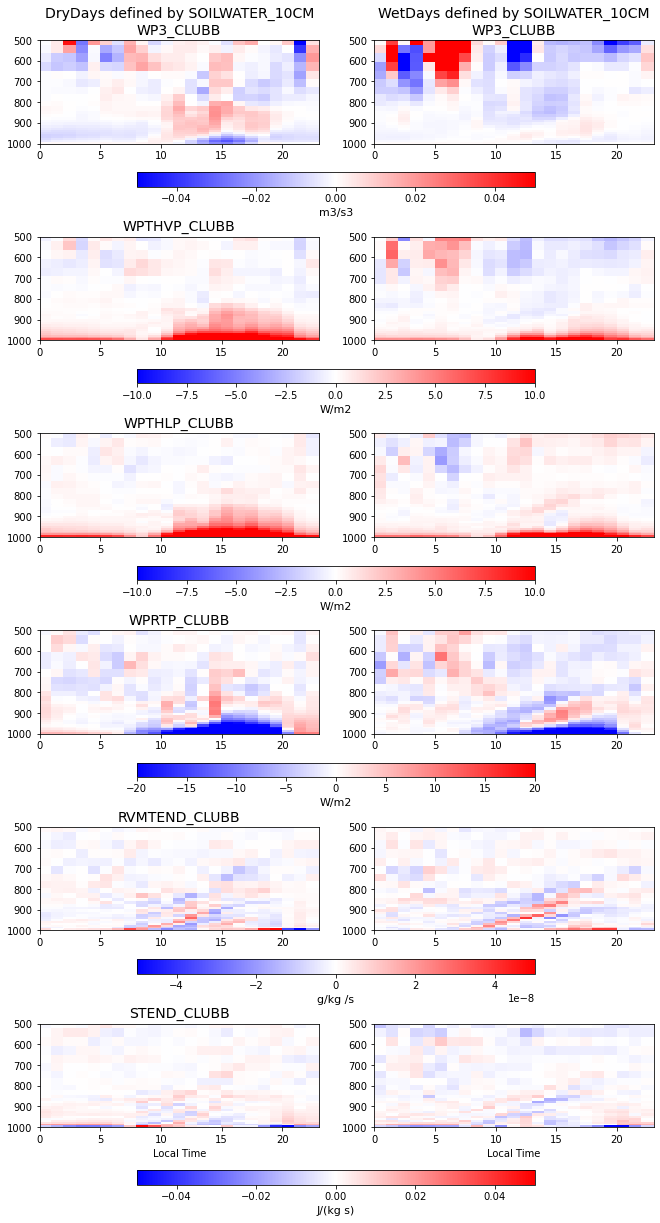

In [67]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.05, 10, 10, 20, 5e-8, 5e-2])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

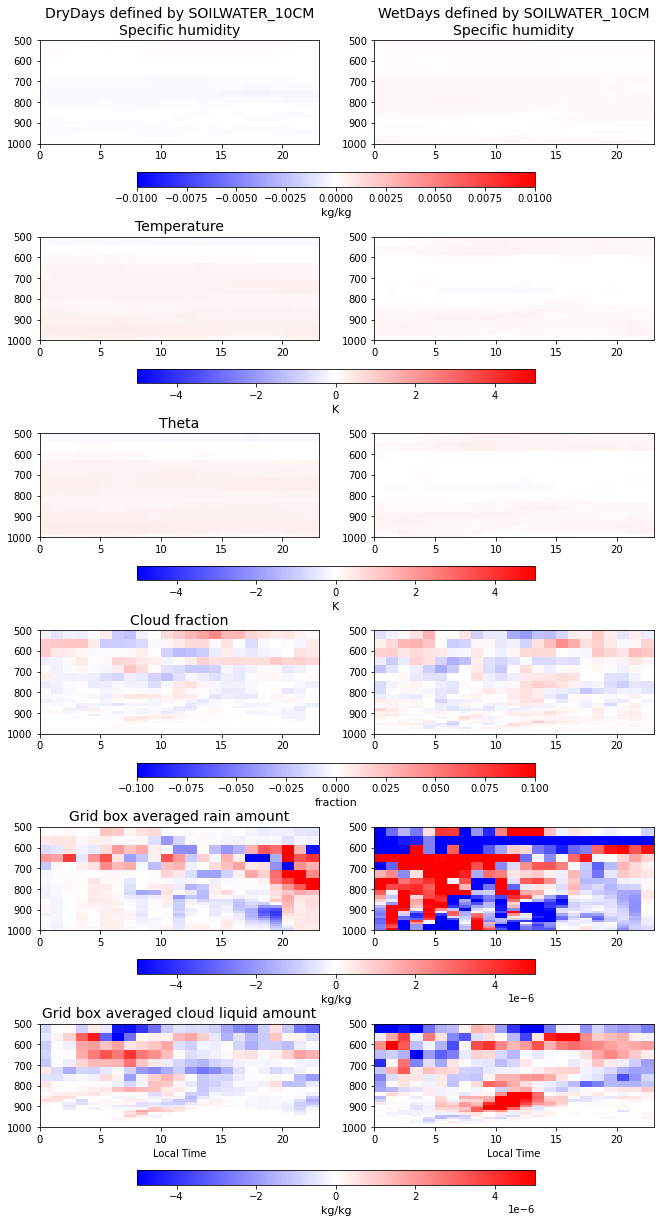

In [68]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['Q','T','theta','CLOUD','RAINQM','CLDLIQ'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 5, 5, 0.1, 0.000005, 0.000005])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.lev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.lev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        if ATM_varNames[iVar]=='theta':
            cbar.set_label('K',fontsize=11)
        else:
            cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        if ATM_varNames[iVar]=='theta':
            cbar.set_label('K',fontsize=11)
        else:
            cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    if ATM_varNames[iVar]=='theta':
        axs[iPlot].set_title('Theta',fontsize=14)
    else: 
        axs[iPlot].set_title(HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

**Now look at the percentiles' mean profiles averaged over a certain time of day**

In [65]:
# def getMeanOverHours(DS, startHr, endHr):
#     hourlyMean = DS.groupby("time.hour").mean()
    
#     # Get mean over some hours 
#     iHours    = np.where((hourlyMean
#                           .hour>=startHr) & (hourlyMean.hour<=endHr))[0]
#     DShrSel   = hourlyMean.isel(hour=iHours)
    
#     return(DShrSel.mean(dim='hour'))

In [368]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, varSel, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- Dry days (defined by bot30) ----------
    iTimeSel_bot30HMG = np.where((HMGcam_bot30["time.hour"].values>=startHr) & 
                                 (HMGcam_bot30["time.hour"].values<=endHr))[0]
    iTimeSel_bot30HTG = np.where((HTGcam_bot30["time.hour"].values>=startHr) & 
                                 (HTGcam_bot30["time.hour"].values<=endHr))[0]
    

    hourlyMean_botTimeSel_HMG = HMGcam_bot30.isel(time=iTimeSel_bot30HMG).mean(dim='time')
    hourlyMean_botTimeSel_HTG = HTGcam_bot30.isel(time=iTimeSel_bot30HTG).mean(dim='time')
    
    hourlyStd_botTimeSel_HMG = HMGcam_bot30.isel(time=iTimeSel_bot30HMG).std(dim='time')
    hourlyStd_botTimeSel_HTG = HTGcam_bot30.isel(time=iTimeSel_bot30HTG).std(dim='time')
    
    stdErr_bot_HMG = np.squeeze(hourlyStd_botTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_bot30HMG))
    stdErr_bot_HTG = np.squeeze(hourlyStd_botTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_bot30HTG))
    


    # ------- Wet days (defined by top30) ----------
    iTimeSel_top30HMG = np.where((HMGcam_top30["time.hour"].values>=startHr) & 
                                 (HMGcam_top30["time.hour"].values<=endHr))[0]
    iTimeSel_top30HTG = np.where((HTGcam_top30["time.hour"].values>=startHr) & 
                                 (HTGcam_top30["time.hour"].values<=endHr))[0]
    
    hourlyMean_topTimeSel_HMG = HMGcam_top30.isel(time=iTimeSel_top30HMG).mean(dim='time')
    hourlyMean_topTimeSel_HTG = HTGcam_top30.isel(time=iTimeSel_top30HTG).mean(dim='time')
    
    hourlyStd_topTimeSel_HMG = HMGcam_top30.isel(time=iTimeSel_top30HMG).std(dim='time')
    hourlyStd_topTimeSel_HTG = HTGcam_top30.isel(time=iTimeSel_top30HTG).std(dim='time')
    
    stdErr_top_HMG = np.squeeze(hourlyStd_topTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_top30HMG))
    stdErr_top_HTG = np.squeeze(hourlyStd_topTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_top30HTG))


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,2, figsize=(9,4))
    axs     = axs.ravel()
    
    # Select which levels array to use
    if np.shape(hourlyMean_topTimeSel_HMG[varSel].values)[0]==len(hourlyMean_topTimeSel_HMG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_topTimeSel_HMG[varSel].values)[0]==len(hourlyMean_topTimeSel_HMG.lev.values):
        levSel = 'lev'
        
    if varSel=='WindMagnitude':
        unitLabel  = HTGcamDS_local['U'].units
    elif varSel=='theta':
        unitLabel = HTGcamDS_local['T'].units
    else: 
        unitLabel  = HTGcamDS_local[varSel].units
    
    # Plot dry days 
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dDry_HMG,
#                     fmt='r-', capsize=3, label='HMG')
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[0].plot(np.squeeze(hourlyMean_botTimeSel_HMG[varSel].values), 
                    hourlyMean_botTimeSel_HMG[levSel].values,
                    'r-',  label='HMG')
    axs[0].plot(np.squeeze(hourlyMean_botTimeSel_HTG[varSel].values), 
                    hourlyMean_botTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[0].legend()
    axs[0].set_title(varSel+'\nDry days defined by '+controlVar+'\n(Hours '+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel('hPa')
    axs[0].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_botTimeSel_HMG[varSel].values) + (2*stdErr_bot_HMG)
    xmin1 = np.squeeze(hourlyMean_botTimeSel_HMG[varSel].values) - (2*stdErr_bot_HMG)
    xmax2 = np.squeeze(hourlyMean_botTimeSel_HTG[varSel].values) + (2*stdErr_bot_HTG)
    xmin2 = np.squeeze(hourlyMean_botTimeSel_HTG[varSel].values) - (2*stdErr_bot_HTG)

    levSig = np.ones([len(hourlyMean_botTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_botTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_botTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_botTimeSel_HTG[varSel].values[iLev]):
                axs[0].plot(hourlyMean_botTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_botTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[0].plot(hourlyMean_botTimeSel_HTG[varSel].values[iLev], 
                        hourlyMean_botTimeSel_HTG[levSel].values[iLev], 
                        'bo')
    
    
    
    

    # Plot Wet days 
#     axs[1].errorbar(np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_wDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wDry_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[1].errorbar(np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_wDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[1].plot(np.squeeze(hourlyMean_topTimeSel_HMG[varSel].values), 
                    hourlyMean_topTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[1].plot(np.squeeze(hourlyMean_topTimeSel_HTG[varSel].values), 
                    hourlyMean_topTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[1].set_title('\nWet days')
    axs[1].set_xlabel(unitLabel)
        # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_topTimeSel_HMG[varSel].values) + (2*stdErr_top_HMG)
    xmin1 = np.squeeze(hourlyMean_topTimeSel_HMG[varSel].values) - (2*stdErr_top_HMG)
    xmax2 = np.squeeze(hourlyMean_topTimeSel_HTG[varSel].values) + (2*stdErr_top_HTG)
    xmin2 = np.squeeze(hourlyMean_topTimeSel_HTG[varSel].values) - (2*stdErr_top_HTG)

    levSig = np.ones([len(hourlyMean_topTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_topTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_topTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_topTimeSel_HTG[varSel].values[iLev]):
                axs[1].plot(hourlyMean_topTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_topTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[1].plot(hourlyMean_topTimeSel_HTG[varSel].values[iLev], 
                            hourlyMean_topTimeSel_HTG[levSel].values[iLev], 
                            'bo')
            
            
    # Consistent settings across subplots 
    axs[0].set_ylim([maxLev,1000])
    axs[1].set_ylim([maxLev,1000])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    
    return

In [359]:
## Add wind speed to underlying DS

windSpeed_botDays_HMG = np.sqrt((HMGcam_bot30.U.values**2.0) + (HMGcam_bot30.V.values**2.0))
windSpeed_botDays_HTG = np.sqrt((HTGcam_bot30.U.values**2.0) + (HTGcam_bot30.V.values**2.0))

windSpeed_topDays_HMG = np.sqrt((HMGcam_top30.U.values**2.0) + (HMGcam_top30.V.values**2.0))
windSpeed_topDays_HTG = np.sqrt((HTGcam_top30.U.values**2.0) + (HTGcam_top30.V.values**2.0))


HMGcam_bot30['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_botDays_HMG))
HTGcam_bot30['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_botDays_HTG))

HMGcam_top30['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_topDays_HMG))
HTGcam_top30['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_topDays_HTG))


Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


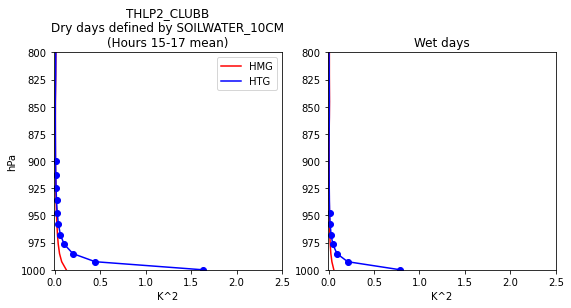

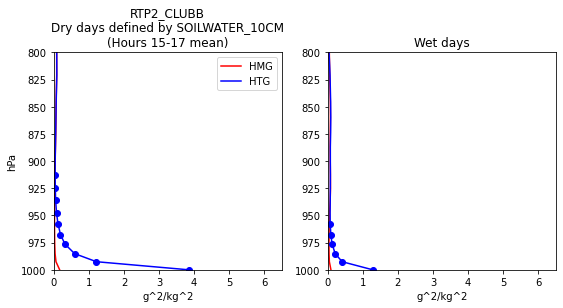

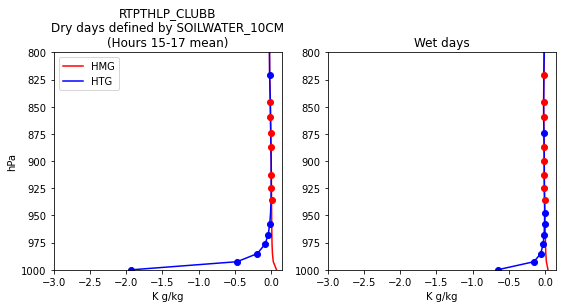

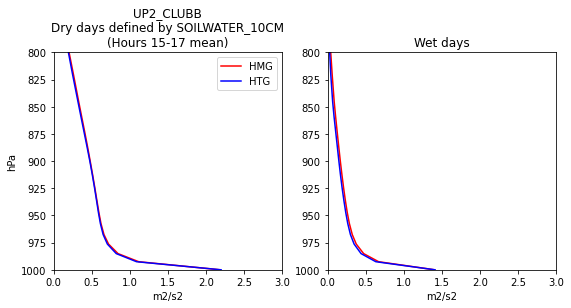

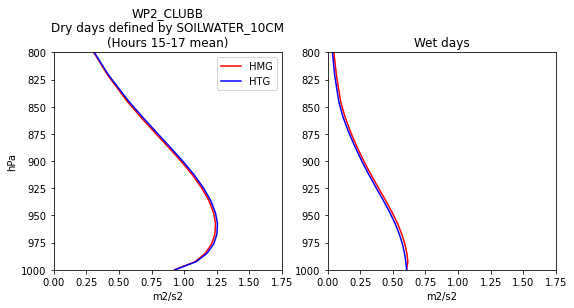

In [369]:
startHr = 15
endHr   = 17
maxLev  = 800

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'THLP2_CLUBB', maxLev, 
#                            -0.01, 0.6)  # 8-10a
                             -0.01, 2.5)  # 3-5p

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'RTP2_CLUBB', maxLev,
#                            0.0, 1.75)
                             0.0, 6.5)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'RTPTHLP_CLUBB', maxLev,
#                            -0.75, 0.15)
                             -3.00, 0.15)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'UP2_CLUBB', maxLev,
#                            0.0, 2.0)
                             0.0, 3.0)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WP2_CLUBB', maxLev,
#                            0.0, 0.8)
                             0.0, 1.75)


Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


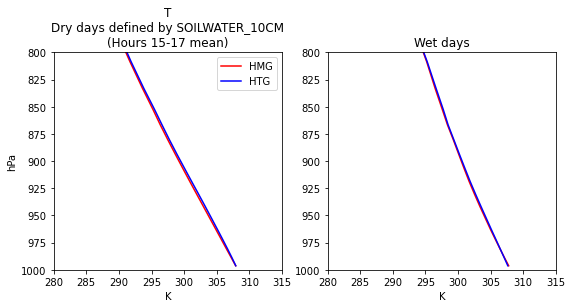

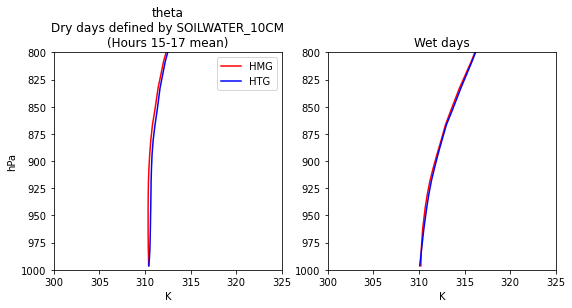

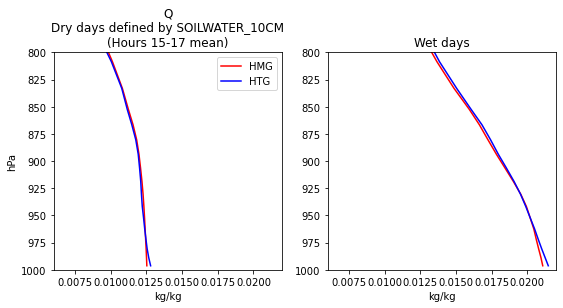

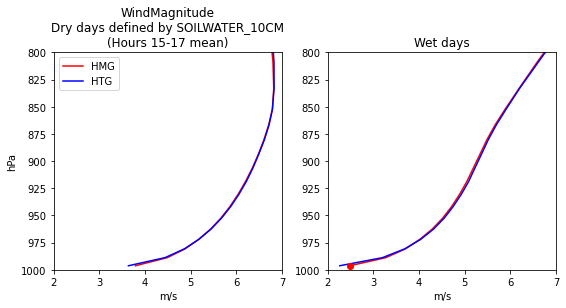

In [372]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'T', maxLev,
#                            280, 310)
                           280, 315)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'theta', maxLev,
#                            280, 310)
                           300, 325)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'Q', maxLev,
#                            0.006, 0.022)
                           0.006, 0.022)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WindMagnitude', maxLev,
#                            0.006, 0.022)
                           2, 7)



Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


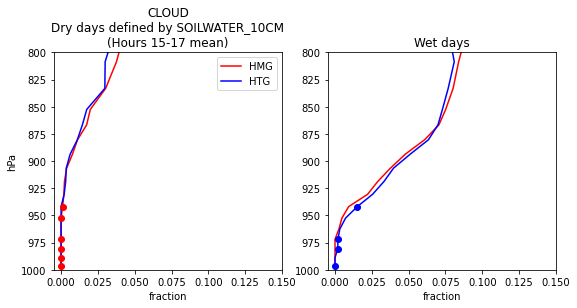

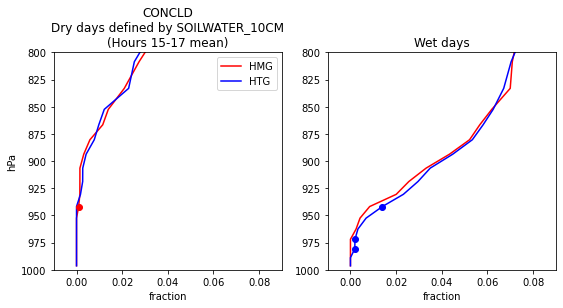

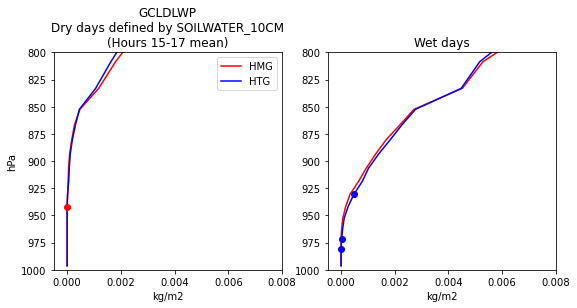

In [375]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'CLOUD', 800,
#                            -0.01, 0.3)
                           -0.005, 0.15)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'CONCLD', 800,
                           -0.01, 0.09)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'GCLDLWP', 800,
                           -0.0005, 0.008)


Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


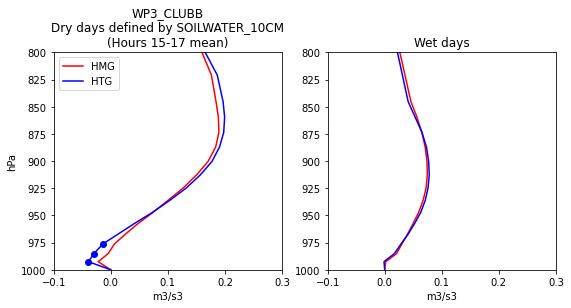

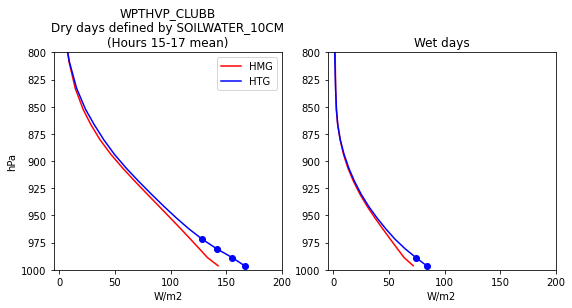

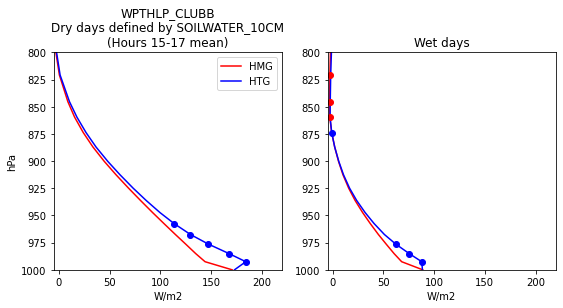

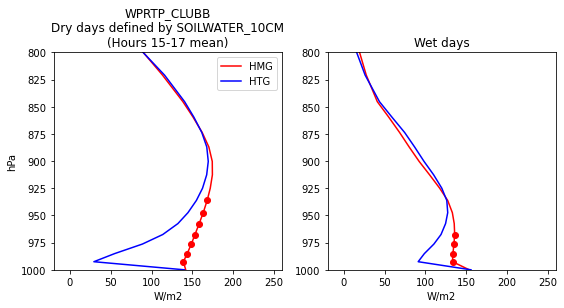

In [374]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WP3_CLUBB', maxLev,
#                            -0.02, 0.1)
                           -0.1, 0.3)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WPTHVP_CLUBB', maxLev,
#                            -5, 60)
                           -5, 200)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WPTHLP_CLUBB', maxLev,
#                            -5, 80)
                           -5, 220)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WPRTP_CLUBB', maxLev,
#                            -10, 120)
                            -20, 260)                                      


#### What about wD/wW/dD/dW day classifications? 

In [127]:
'''
Function to send back which classification each day falls into, 
based on precipitation amount, similar to Burns et al. (2015; 2018).
This version of the function assumes a single column run/input, 
in that only one dimension exists for precip. 

Inputs: 
   time:   An array of times to worry about. 
           Should be a pandas datetime.
   precip: Daily precipitation (summed). Units can be in mm or m, 
           but need to be consistent with the threshold the user
           defines (i.e., no unit conversions done here).
   wetDef: User-defined threshold for defining days as wet vs. dry. 
Outputs:
    classificationArr: Array with one fewer length than time, where
                       the classification falls into four categories:
                       1 :: wWet   (wet day following a wet day)
                       2 :: wDry   (dry day following a wet day)
                       3 :: dWet   (wet day following a dry day)
                       4 :: dDry   (dry day following a dry day)
                       
                       Difference in length due to the first day not having a 
                       "before" day to reference. So time[0] on the 
                       classification array corresponds to time[1]. 

'''

def classifyPrectDays_SCAM(time,precip,wetDef): 
    
    # Define empty arrays of the appropriate length
    nTimes               = len(time)
    classificationArr    = np.empty([len(time)]).astype('str')
    classificationArr[0] = 'n/a'
    
    for iDay in range(nTimes-1): 
        
        # Wet day...
        if precip[iDay]>=wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'wWet'  # Wet day following wet 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'wDry' # Dry day following wet 
        # Dry day...
        elif precip[iDay]<wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'dWet'  # Wet day following dry 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'dDry' # Dry day following dry 

    return(classificationArr)


In [128]:
## First, need to get daily rain amounts 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()



In [129]:
timeArr = []
for iT in range(len(HMGcamDS_localDailySum.year_month_day.values)):
    timeArr = np.append(timeArr, datetime.date(HMGcamDS_localDailySum.year_month_day.values[iT][0],
                                               HMGcamDS_localDailySum.year_month_day.values[iT][1],
                                               HMGcamDS_localDailySum.year_month_day.values[iT][2]))

(0.0, 30.0)

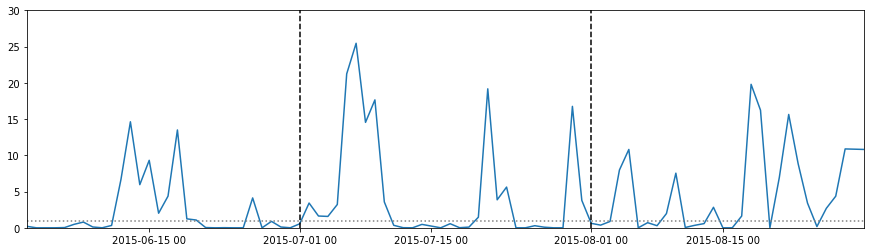

In [73]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(timeArr, np.squeeze(HMGcamDS_localDailySum.PRECT_mmPerDT.values))

startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs.axhline(1, color = 'grey', linestyle = ':')
axs.set_ylim([0,30])

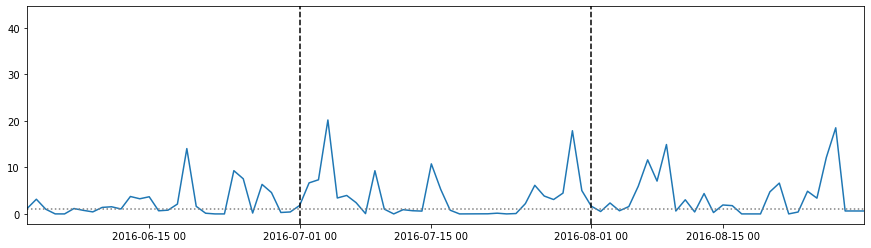

In [65]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(timeArr, np.squeeze(HMGcamDS_localDailySum.PRECT_mmPerDT.values))

startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2016
endYear    = 2016

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs.axhline(1, color = 'grey', linestyle = ':')

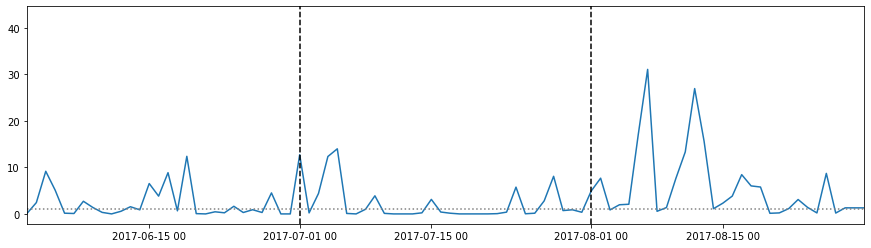

In [64]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(timeArr, np.squeeze(HMGcamDS_localDailySum.PRECT_mmPerDT.values))

startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2017
endYear    = 2017

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs.axhline(1, color = 'grey', linestyle = ':')

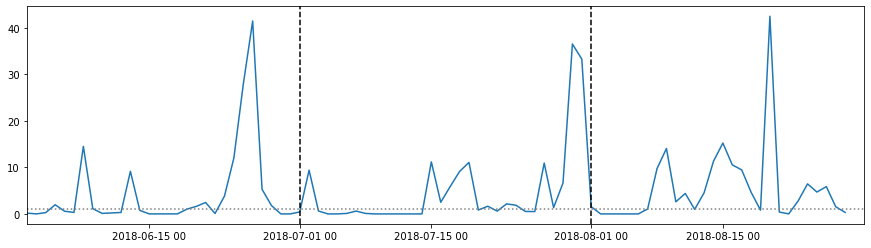

In [63]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

axs.plot(timeArr, np.squeeze(HMGcamDS_localDailySum.PRECT_mmPerDT.values))

startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs.axhline(1, color = 'grey', linestyle = ':')

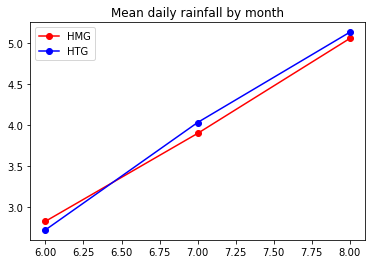

In [71]:
# June mean rain: 
iJune = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==6)[0]
iJuly = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==7)[0]
iAug  = np.where(HMGcamDS_localDailySum.year_month_day_level_1.values==8)[0]

HMGrain_june = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])
HTGrain_june = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])

HMGrain_july = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])
HTGrain_july = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])

HMGrain_aug  = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])
HTGrain_aug  = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])

plt.plot([6,7,8], [HMGrain_june, HMGrain_july, HMGrain_aug],'ro-')
plt.plot([6,7,8], [HTGrain_june, HTGrain_july, HTGrain_aug],'bo-')
plt.title('Mean daily rainfall by month')
plt.legend(['HMG','HTG'])


(1.0, 6.0)

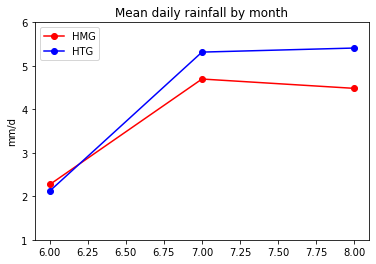

In [77]:
# June mean rain: 
iJune = np.where( (HMGcamDS_localDailySum.year_month_day_level_0.values==2015) &
                  (HMGcamDS_localDailySum.year_month_day_level_1.values==6))[0]
iJuly = np.where( (HMGcamDS_localDailySum.year_month_day_level_0.values==2015) &
                  (HMGcamDS_localDailySum.year_month_day_level_1.values==7))[0]
iAug  = np.where( (HMGcamDS_localDailySum.year_month_day_level_0.values==2015) & 
                  (HMGcamDS_localDailySum.year_month_day_level_1.values==8))[0]

HMGrain_june = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])
HTGrain_june = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJune])

HMGrain_july = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])
HTGrain_july = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iJuly])

HMGrain_aug  = np.nanmean(HMGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])
HTGrain_aug  = np.nanmean(HTGcamDS_localDailySum.PRECT_mmPerDT.values[iAug])

plt.plot([6,7,8], [HMGrain_june, HMGrain_july, HMGrain_aug],'ro-')
plt.plot([6,7,8], [HTGrain_june, HTGrain_july, HTGrain_aug],'bo-')
plt.title('Mean daily rainfall by month')
plt.ylabel('mm/d')
plt.legend(['HMG','HTG'])

plt.ylim([1, 6])

Number of total days in record:   352
Number of dry days (< 1.000):     172
Number of wet days (>= 1.000):    180


Text(0.5, 1.0, 'Wet days by month')

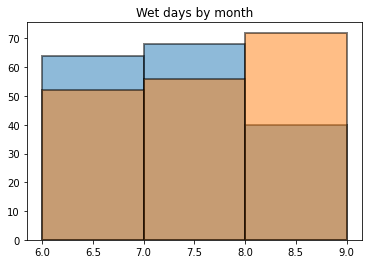

In [39]:
# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1

print('Number of total days in record:   %i' % (len(HMGcamDS_localDailySum.year_month_day.values)) )
print('Number of dry days (< %.3f):     %i' % (prectCutoff, len(np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff)[0])))
print('Number of wet days (>= %.3f):    %i' % (prectCutoff, len(np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff)[0])))


iSelDryDays = np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff)[0]
dryDays_HMG = HMGcamDS_localDailySum.isel(year_month_day=iSelDryDays)
plt.hist(dryDays_HMG.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2, alpha=0.5)
plt.title('Dry days by month')

iSelWetDays = np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff)[0]
wetDays_HMG = HMGcamDS_localDailySum.isel(year_month_day=iSelWetDays)
plt.hist(wetDays_HMG.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2, alpha=0.5)
plt.title('Wet days by month')



In [130]:
# Define classification by day... 

# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1


classArr_HTG = classifyPrectDays_SCAM(HTGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HMG = classifyPrectDays_SCAM(HMGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HMGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 

# Add that classification to larger datasets
HTGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HTG)
HMGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HMG)

# Select based on each classification:
idDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wWet')[0]

# HTG_dDry = HTGcamDS_localDailySum.isel(year_month_day = idDry_HTG)
# HTG_dWet = HTGcamDS_localDailySum.isel(year_month_day = idWet_HTG)
# HTG_wDry = HTGcamDS_localDailySum.isel(year_month_day = iwDry_HTG)
# HTG_wWet = HTGcamDS_localDailySum.isel(year_month_day = iwWet_HTG)


idDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wWet')[0]

# HMG_dDry = HMGcamDS_localDailySum.isel(year_month_day = idDry_HMG)
# HMG_dWet = HMGcamDS_localDailySum.isel(year_month_day = idWet_HMG)
# HMG_wDry = HMGcamDS_localDailySum.isel(year_month_day = iwDry_HMG)
# HMG_wWet = HMGcamDS_localDailySum.isel(year_month_day = iwWet_HMG)

## Keep only days that agree on classification between HMG and HTG
setHMG_dDry = set(idDry_HMG)
setHTG_dDry = set(idDry_HTG)
iKeep_dDry  = list(setHMG_dDry & setHTG_dDry)
HMG_dDry    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_dDry)
HTG_dDry    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_dDry)


setHMG_dWet = set(idWet_HMG)
setHTG_dWet = set(idWet_HTG)
iKeep_dWet  = list(setHMG_dWet & setHTG_dWet)
HMG_dWet    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_dWet)
HTG_dWet    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_dWet)


setHMG_wDry = set(iwDry_HMG)
setHTG_wDry = set(iwDry_HTG)
iKeep_wDry  = list(setHMG_wDry & setHTG_wDry)
HMG_wDry    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_wDry)
HTG_wDry    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_wDry)


setHMG_wWet = set(iwWet_HMG)
setHTG_wWet = set(iwWet_HTG)
iKeep_wWet  = list(setHMG_wWet & setHTG_wWet)
HMG_wWet    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_wWet)
HTG_wWet    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_wWet)



In [131]:
print('   Number of days in each category   ')
print('         HMG              HTG   ')
print('dDry: %6i %16i' % (len(HMG_dDry.year_month_day.values), len(HTG_dDry.year_month_day.values)) )
print('dWet: %6i %16i' % (len(HMG_dWet.year_month_day.values), len(HTG_dWet.year_month_day.values)) )
print('wDry: %6i %16i' % (len(HMG_wDry.year_month_day.values), len(HTG_wDry.year_month_day.values)) )
print('wWet: %6i %16i' % (len(HMG_wWet.year_month_day.values), len(HTG_wWet.year_month_day.values)) )


   Number of days in each category   
         HMG              HTG   
dDry:    102              102
dWet:     49               49
wDry:     49               49
wWet:    106              106


Text(0.5, 1.0, 'dDry days by month')

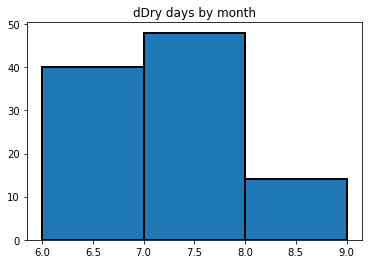

In [75]:
plt.hist(HMG_dDry.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('dDry days by month')

Text(0.5, 1.0, 'wDry days by month')

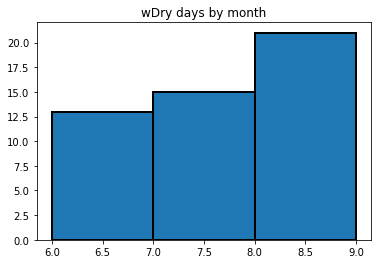

In [76]:
plt.hist(HMG_wDry.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('wDry days by month')

Text(0.5, 1.0, 'dWet days by month')

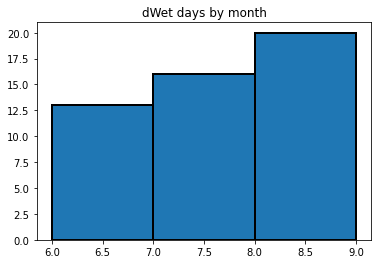

In [77]:
plt.hist(HMG_dWet.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('dWet days by month')

Text(0.5, 1.0, 'wWet days by month')

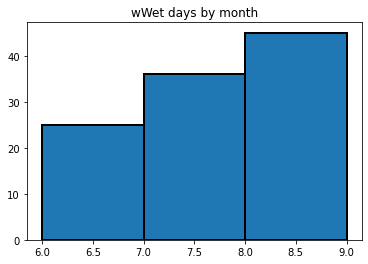

In [78]:
plt.hist(HMG_wWet.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('wWet days by month')

In [132]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDayClass(fullDS, dayClassDS):
    iTimes = []
    
    for iTime in range(len(dayClassDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==dayClassDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==dayClassDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==dayClassDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)

In [133]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dDry)
wDryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wDry)
dWetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dWet)
wWetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wWet)

dDryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dDry)
wDryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wDry)
dWetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dWet)
wWetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wWet)


In [32]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_dDry)
wDryDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_wDry)
dWetDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_dWet)
wWetDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_wWet)

dDryDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_dDry)
wDryDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_wDry)
dWetDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_dWet)
wWetDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_wWet)

In [33]:


# Next, get all the times in the full array that line up with each of those classifications above 

dDryDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_dDry)
wDryDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_wDry)
dWetDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_dWet)
wWetDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_wWet)

dDryDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_dDry)
wDryDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_wDry)
dWetDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_dWet)
wWetDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_wWet)

In [134]:
# Get means a function of hour of day
hourlyMean_dDry_HMG = dDryDays_HMG.groupby("time.hour").mean()
hourlyMean_dDry_HTG = dDryDays_HTG.groupby("time.hour").mean()

hourlyMean_wDry_HMG = wDryDays_HMG.groupby("time.hour").mean()
hourlyMean_wDry_HTG = wDryDays_HTG.groupby("time.hour").mean()

hourlyMean_dWet_HMG = dWetDays_HMG.groupby("time.hour").mean()
hourlyMean_dWet_HTG = dWetDays_HTG.groupby("time.hour").mean()

hourlyMean_wWet_HMG = wWetDays_HMG.groupby("time.hour").mean()
hourlyMean_wWet_HTG = wWetDays_HTG.groupby("time.hour").mean()

# Get std as function of hour of day
hourlyStd_dDry_HMG = dDryDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_dDry_HTG = dDryDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_wDry_HMG = wDryDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_wDry_HTG = wDryDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_dWet_HMG = dWetDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_dWet_HTG = dWetDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_wWet_HMG = wWetDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_wWet_HTG = wWetDays_HTG.groupby("time.hour").std(dim='time')

# Get number of obs going into those hourly means (for error bars)
nTimes_dDry = np.full([24], np.nan)
nTimes_wDry = np.full([24], np.nan)
nTimes_dWet = np.full([24], np.nan)
nTimes_wWet = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_dDry[iHr] = len(np.where(dDryDays_HMG["time.hour"]==iHr)[0])
    nTimes_wDry[iHr] = len(np.where(wDryDays_HMG["time.hour"]==iHr)[0])
    nTimes_dWet[iHr] = len(np.where(dWetDays_HMG["time.hour"]==iHr)[0])
    nTimes_wWet[iHr] = len(np.where(wWetDays_HMG["time.hour"]==iHr)[0])
    
hourlyMean_dDry_HMG['SampleCount']         = (('hour'), nTimes_dDry)
hourlyMean_dDry_HTG['SampleCount']         = (('hour'), nTimes_dDry)

hourlyMean_wDry_HMG['SampleCount']         = (('hour'), nTimes_wDry)
hourlyMean_wDry_HTG['SampleCount']         = (('hour'), nTimes_wDry)

hourlyMean_dWet_HMG['SampleCount']         = (('hour'), nTimes_dWet)
hourlyMean_dWet_HTG['SampleCount']         = (('hour'), nTimes_dWet)

hourlyMean_wWet_HMG['SampleCount']         = (('hour'), nTimes_wWet)
hourlyMean_wWet_HTG['SampleCount']         = (('hour'), nTimes_wWet)



In [35]:
## For some reason, the CLM DS's can't run .std, so just make a function that will do it for a selected var
'''
Get standard error for a CLM variable per hour 

All inputs are a string: varSel is the variable to get SE for (assumed 1D)
                         modelComponent is whether this is a variable in CAM or CLM
                         dayClass is the 4-letter abbreviation of day class (dDry, wDry, etc.)

'''

def get_hourlySE(varSel, modelComponent, dayClass):
    
    # Select data 
    if modelComponent=='CAM':
        
        if dayClass=='dDry':
            dsHMG = dDryDays_HMG
            dsHTG = dDryDays_HTG
        elif dayClass=='wDry':
            dsHMG = wDryDays_HMG
            dsHTG = wDryDays_HTG
        elif dayClass=='dWet':
            dsHMG = dWetDays_HMG
            dsHTG = dWetDays_HTG
        elif dayClass=='wWet':
            dsHMG = wWetDays_HMG
            dsHTG = wWetDays_HTG
        else:
            print('Please select a dayClass with the appropriate 4-letter code: dDry, wDry, dWet, or wWet')
        
        
    elif modelComponent=='CLM':
        
        if dayClass=='dDry':
            dsHMG = dDryDaysCLM_HMG
            dsHTG = dDryDaysCLM_HTG
        elif dayClass=='wDry':
            dsHMG = wDryDaysCLM_HMG
            dsHTG = wDryDaysCLM_HTG
        elif dayClass=='dWet':
            dsHMG = dWetDaysCLM_HMG
            dsHTG = dWetDaysCLM_HTG
        elif dayClass=='wWet':
            dsHMG = wWetDaysCLM_HMG
            dsHTG = wWetDaysCLM_HTG
        else:
            print('Please select a dayClass with the appropriate 4-letter code: dDry, wDry, dWet, or wWet')
        
        
    else: 
        print('Please select either "CAM" or "CLM" as valid model component options')
        
    ## Now get standard error for selected variable
    varSE_HMG = np.full([24], np.nan)
    varSE_HTG = np.full([24], np.nan)
    
    for iHr in range(24):
        iselHr = np.where(dsHMG["time.hour"].values==iHr)[0]
        
        varHr_HMG = np.squeeze(dsHMG[varSel].values[iselHr,:])
        varSE_HMG[iHr] = np.nanstd(varHr_HMG)/np.sqrt(len(varHr_HMG))
        
        varHr_HTG = np.squeeze(dsHTG[varSel].values[iselHr,:])
        varSE_HTG[iHr] = np.nanstd(varHr_HTG)/np.sqrt(len(varHr_HTG))
    
    return(varSE_HMG, varSE_HTG)


In [36]:
# Get means a function of hour of day
hourlyMeanCLM_dDry_HMG = dDryDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_dDry_HTG = dDryDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_wDry_HMG = wDryDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_wDry_HTG = wDryDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_dWet_HMG = dWetDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_dWet_HTG = dWetDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_wWet_HMG = wWetDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_wWet_HTG = wWetDaysCLM_HTG.groupby("time.hour").mean()

# # Get std a function of hour of day
# hourlyStdCLM_dDry_HMG = dDryDaysCLM_HMG.groupby("time.hour").std(dim='time')
# hourlyStdCLM_dDry_HTG = dDryDaysCLM_HTG.groupby("time.hour").std(dim='time')

# hourlyStdCLM_wDry_HMG = wDryDaysCLM_HMG.groupby("time.hour").std(dim='time')
# hourlyStdCLM_wDry_HTG = wDryDaysCLM_HTG.groupby("time.hour").std(dim='time')

# hourlyStdCLM_dWet_HMG = dWetDaysCLM_HMG.groupby("time.hour").std(dim='time')
# hourlyStdCLM_dWet_HTG = dWetDaysCLM_HTG.groupby("time.hour").std(dim='time')

# hourlyStdCLM_wWet_HMG = wWetDaysCLM_HMG.groupby("time.hour").std(dim='time')
# hourlyStdCLM_wWet_HTG = wWetDaysCLM_HTG.groupby("time.hour").std(dim='time')

# # Number of obs going into the means 
# hourlyMeanCLM_dDry_HMG['SampleCount']         = (('hour'), nTimes_dDry)
# hourlyMeanCLM_dDry_HTG['SampleCount']         = (('hour'), nTimes_dDry)

# hourlyMeanCLM_wDry_HMG['SampleCount']         = (('hour'), nTimes_wDry)
# hourlyMeanCLM_wDry_HTG['SampleCount']         = (('hour'), nTimes_wDry)

# hourlyMeanCLM_dWet_HMG['SampleCount']         = (('hour'), nTimes_dWet)
# hourlyMeanCLM_dWet_HTG['SampleCount']         = (('hour'), nTimes_dWet)

# hourlyMeanCLM_wWet_HMG['SampleCount']         = (('hour'), nTimes_wWet)
# hourlyMeanCLM_wWet_HTG['SampleCount']         = (('hour'), nTimes_wWet)


In [37]:

# Get means a function of hour of day
hourlyMeanPatch_dDry_HMG = dDryDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_dDry_HTG = dDryDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_wDry_HMG = wDryDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_wDry_HTG = wDryDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_dWet_HMG = dWetDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_dWet_HTG = dWetDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_wWet_HMG = wWetDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_wWet_HTG = wWetDaysPatch_HTG.groupby("time.hour").mean()

# # Get std a function of hour of day
# hourlyStdPatch_dDry_HMG = dDryDaysPatch_HMG.groupby("time.hour").std(dim='time')
# hourlyStdPatch_dDry_HTG = dDryDaysPatch_HTG.groupby("time.hour").std(dim='time')

# hourlyStdPatch_wDry_HMG = wDryDaysPatch_HMG.groupby("time.hour").std(dim='time')
# hourlyStdPatch_wDry_HTG = wDryDaysPatch_HTG.groupby("time.hour").std(dim='time')

# hourlyStdPatch_dWet_HMG = dWetDaysPatch_HMG.groupby("time.hour").std(dim='time')
# hourlyStdPatch_dWet_HTG = dWetDaysPatch_HTG.groupby("time.hour").std(dim='time')

# hourlyStdPatch_wWet_HMG = wWetDaysPatch_HMG.groupby("time.hour").std(dim='time')
# hourlyStdPatch_wWet_HTG = wWetDaysPatch_HTG.groupby("time.hour").std(dim='time')

# # Number of obs going into the means 
# hourlyMeanPatch_dDry_HMG['SampleCount']         = (('hour'), nTimes_dDry)
# hourlyMeanPatch_dDry_HTG['SampleCount']         = (('hour'), nTimes_dDry)

# hourlyMeanPatch_wDry_HMG['SampleCount']         = (('hour'), nTimes_wDry)
# hourlyMeanPatch_wDry_HTG['SampleCount']         = (('hour'), nTimes_wDry)

# hourlyMeanPatch_dWet_HMG['SampleCount']         = (('hour'), nTimes_dWet)
# hourlyMeanPatch_dWet_HTG['SampleCount']         = (('hour'), nTimes_dWet)

# hourlyMeanPatch_wWet_HMG['SampleCount']         = (('hour'), nTimes_wWet)
# hourlyMeanPatch_wWet_HTG['SampleCount']         = (('hour'), nTimes_wWet)


In [50]:
## Print some summary daily means for each case 

print('                   dDry      wDry      dWet      wWet')
print('                   -----     -----     -----     -----')
print('Daily rain (HMG): %6.2f %8.2f %9.2f %9.2f' % (np.nanmean(HMG_dDry.PRECT_mmPerDT.values), 
                                                     np.nanmean(HMG_wDry.PRECT_mmPerDT.values),
                                                     np.nanmean(HMG_dWet.PRECT_mmPerDT.values),
                                                     np.nanmean(HMG_wWet.PRECT_mmPerDT.values)))
print('           (HTG): %6.2f %8.2f %9.2f %9.2f' % (np.nanmean(HTG_dDry.PRECT_mmPerDT.values), 
                                                     np.nanmean(HTG_wDry.PRECT_mmPerDT.values),
                                                     np.nanmean(HTG_dWet.PRECT_mmPerDT.values),
                                                     np.nanmean(HTG_wWet.PRECT_mmPerDT.values)))
print()
varSel = 'TGCLDLWP'
print('Daily TGCLDLWP (HMG): %4.2e %8.2e %9.2e %9.2e' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('               (HTG): %4.2e %8.2e %9.2e %9.2e' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDTOT'
print('Daily CLDTOT (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDLOW'
print('Daily CLDLOW (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDMED'
print('Daily CLDMED (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))
print()
varSel = 'CLDHGH'
print('Daily CLDHGH (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))
print()
varSel = 'QFLX_EVAP_TOT'
print('Daily ET (HMG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('         (HTG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))

print()
varSel = 'SOILWATER_10CM'
print('Daily SM_10CM (HMG): %4.2f %8.2f %8.2f %8.2f' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('              (HTG): %4.2f %8.2f %8.2f %8.2f' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))





                   dDry      wDry      dWet      wWet
                   -----     -----     -----     -----
Daily rain (HMG):   0.17     0.31      5.44      9.12
           (HTG):   0.19     0.33      5.32      9.28

Daily TGCLDLWP (HMG): 1.73e-02 3.34e-02  9.07e-02  1.18e-01
               (HTG): 1.80e-02 3.28e-02  8.96e-02  1.21e-01

Daily CLDTOT (HMG): 0.52     0.69      0.86      0.92
             (HTG): 0.49     0.75      0.85      0.93

Daily CLDLOW (HMG): 0.02     0.07      0.09      0.17
             (HTG): 0.02     0.06      0.08      0.16

Daily CLDMED (HMG): 0.18     0.22      0.53      0.50
             (HTG): 0.17     0.25      0.53      0.47

Daily CLDHGH (HMG): 0.45     0.61      0.79      0.88
             (HTG): 0.43     0.66      0.79      0.89

Daily ET (HMG):  3.95e-05   3.53e-05   4.19e-05   3.73e-05
         (HTG):  3.94e-05   3.54e-05   4.19e-05   3.70e-05

Daily SM_10CM (HMG): 24.92    28.72    26.92    31.72
              (HTG): 24.95    28.93    27.13    31.9

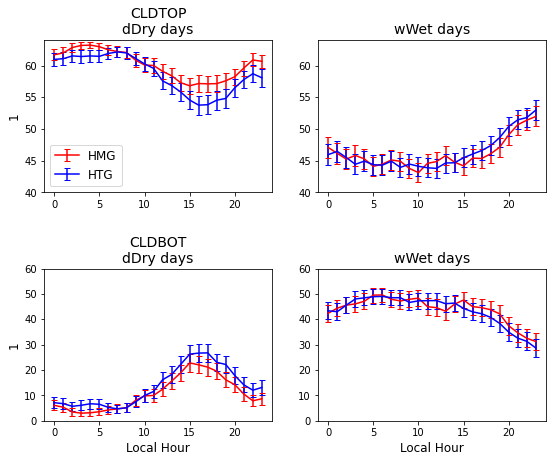

In [44]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['CLDTOP','CLDBOT'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,7))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([64,60])
yMin = np.asarray([40, 0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='lower left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


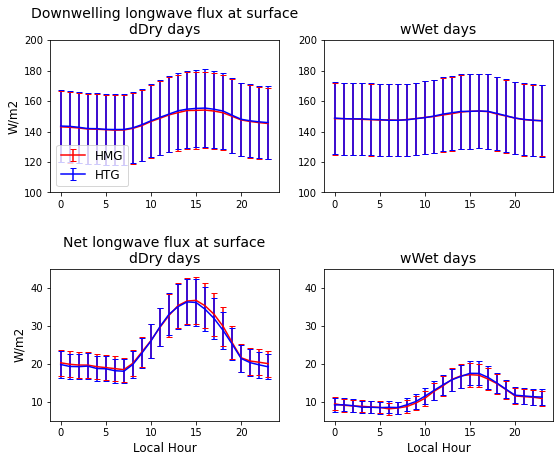

In [71]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['FLDS','FLNS'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,7))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([200, 45])
yMin = np.asarray([100, 5])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='lower left',fontsize=12)
    axs[iPlot+0].set_title(HTGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2



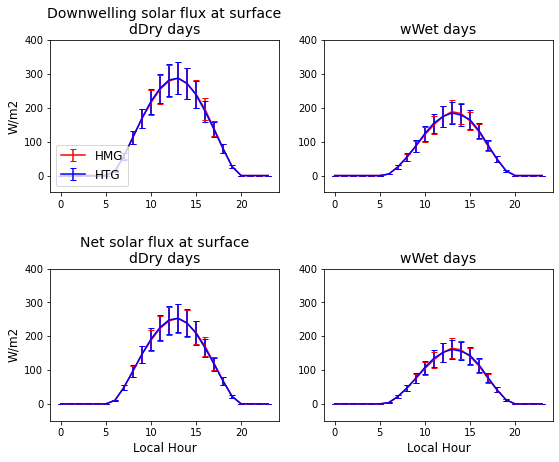

In [70]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['FSDS','FSNS'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,7))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([400, 400])
yMin = np.asarray([-50, -50])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='lower left',fontsize=12)
    axs[iPlot+0].set_title(HTGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2




Text(0.5, 0, 'Local Hour')

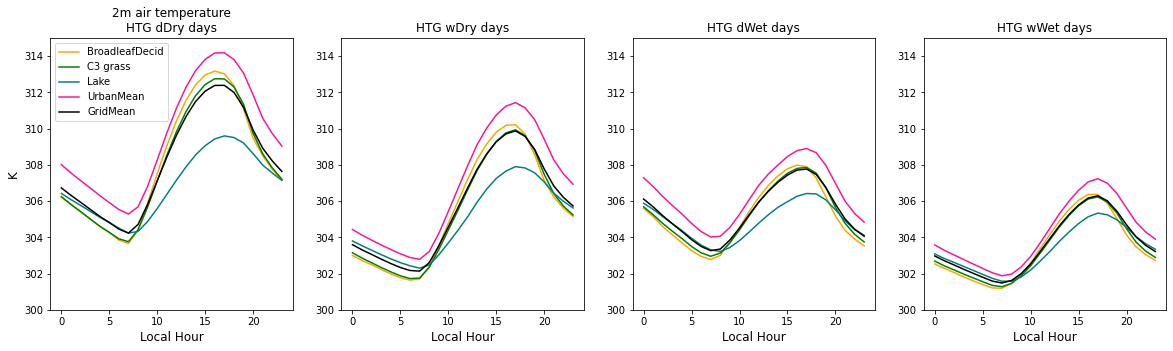

In [88]:

varSel = 'TSA'

## Get urban mean
iUrban = np.where((colType>=70) & (colType<80))[0]

varSel_urban_dDry = np.nansum(hourlyMeanPatch_dDry_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_wDry = np.nansum(hourlyMeanPatch_wDry_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_dWet = np.nansum(hourlyMeanPatch_dWet_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_wWet = np.nansum(hourlyMeanPatch_wWet_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])

patchLabels[0] = 'BroadleafDecid'


yMax = np.asarray([315])
yMin = np.asarray([300])

fig,axs = plt.subplots(1,4, figsize=(20,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

## dDry days 
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, 0]),
         color='orange', label=patchLabels[0])
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, 1]),
         color='green', label=patchLabels[1])
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[0].plot(hourlyMeanCLM_dDry_HTG.hour.values, varSel_urban_dDry,
         color='deeppink',label='UrbanMean')
axs[0].plot(hourlyMeanCLM_dDry_HTG.hour.values, hourlyMeanCLM_dDry_HTG[varSel].values, 'k-',label='GridMean')
axs[0].legend(loc='upper left',fontsize=10)
axs[0].set_title(HTGclmDS_patch_local[varSel].long_name+'\nHTG dDry days')
axs[0].set_ylim([yMin[0], yMax[0]])


## wDry days 
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[1].plot(hourlyMeanCLM_wDry_HTG.hour.values, varSel_urban_wDry,
         color='deeppink',label='UrbanMean')
axs[1].plot(hourlyMeanCLM_wDry_HTG.hour.values, hourlyMeanCLM_wDry_HTG[varSel].values, 'k-',label='GridMean')
axs[1].set_title('\nHTG wDry days')
axs[1].set_ylim([yMin[0], yMax[0]])


## dWet days 
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[2].plot(hourlyMeanCLM_dWet_HTG.hour.values, varSel_urban_dWet,
         color='deeppink',label='UrbanMean')
axs[2].plot(hourlyMeanCLM_dWet_HTG.hour.values, hourlyMeanCLM_dWet_HTG[varSel].values, 'k-',label='GridMean')
axs[2].set_title('\nHTG dWet days')
axs[2].set_ylim([yMin[0], yMax[0]])


## wWet days 
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[3].plot(hourlyMeanCLM_wWet_HTG.hour.values, varSel_urban_wWet,
         color='deeppink',label='UrbanMean')
axs[3].plot(hourlyMeanCLM_wWet_HTG.hour.values, hourlyMeanCLM_wWet_HTG[varSel].values, 'k-',label='GridMean')
axs[3].set_title('\nHTG wWet days')
axs[3].set_ylim([yMin[0], yMax[0]])


axs[0].set_ylabel(HTGclmDS_patch_local[varSel].units, fontsize=12)
axs[0].set_xlabel('Local Hour', fontsize=12)
axs[1].set_xlabel('Local Hour', fontsize=12)
axs[2].set_xlabel('Local Hour', fontsize=12)
axs[3].set_xlabel('Local Hour', fontsize=12)


Text(0.5, 0, 'Local Hour')

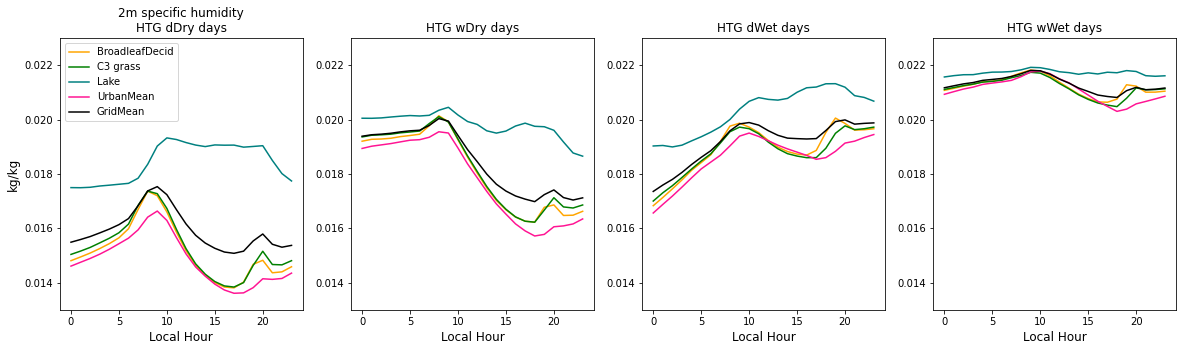

In [91]:
varSel = 'Q2M'

## Get urban mean
iUrban = np.where((colType>=70) & (colType<80))[0]

varSel_urban_dDry = np.nansum(hourlyMeanPatch_dDry_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_wDry = np.nansum(hourlyMeanPatch_wDry_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_dWet = np.nansum(hourlyMeanPatch_dWet_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
varSel_urban_wWet = np.nansum(hourlyMeanPatch_wWet_HTG[varSel].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])


yMax = np.asarray([0.023])
yMin = np.asarray([0.013])

fig,axs = plt.subplots(1,4, figsize=(20,5))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

## dDry days 
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, 0]),
         color='orange', label=patchLabels[0])
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, 1]),
         color='green', label=patchLabels[1])
axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[0].plot(hourlyMeanCLM_dDry_HTG.hour.values, varSel_urban_dDry,
         color='deeppink',label='UrbanMean')
axs[0].plot(hourlyMeanCLM_dDry_HTG.hour.values, hourlyMeanCLM_dDry_HTG[varSel].values, 'k-',label='GridMean')
axs[0].legend(loc='upper left',fontsize=10)
axs[0].set_title(HTGclmDS_patch_local[varSel].long_name+'\nHTG dDry days')
axs[0].set_ylim([yMin[0], yMax[0]])


## wDry days 
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[1].plot(hourlyMeanCLM_wDry_HTG.hour.values, varSel_urban_wDry,
         color='deeppink',label='UrbanMean')
axs[1].plot(hourlyMeanCLM_wDry_HTG.hour.values, hourlyMeanCLM_wDry_HTG[varSel].values, 'k-',label='GridMean')
axs[1].set_title('\nHTG wDry days')
axs[1].set_ylim([yMin[0], yMax[0]])


## dWet days 
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[2].plot(hourlyMeanCLM_dWet_HTG.hour.values, varSel_urban_dWet,
         color='deeppink',label='UrbanMean')
axs[2].plot(hourlyMeanCLM_dWet_HTG.hour.values, hourlyMeanCLM_dWet_HTG[varSel].values, 'k-',label='GridMean')
axs[2].set_title('\nHTG dWet days')
axs[2].set_ylim([yMin[0], yMax[0]])


## wWet days 
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, 0]),
         color='orange',label=patchLabels[0])
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, 1]),
         color='green',label=patchLabels[1])
axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel].values[:, -1]),
         color='teal',label=patchLabels[-1])
axs[3].plot(hourlyMeanCLM_wWet_HTG.hour.values, varSel_urban_wWet,
         color='deeppink',label='UrbanMean')
axs[3].plot(hourlyMeanCLM_wWet_HTG.hour.values, hourlyMeanCLM_wWet_HTG[varSel].values, 'k-',label='GridMean')
axs[3].set_title('\nHTG wWet days')
axs[3].set_ylim([yMin[0], yMax[0]])


axs[0].set_ylabel(HTGclmDS_patch_local[varSel].units, fontsize=12)
axs[0].set_xlabel('Local Hour', fontsize=12)
axs[1].set_xlabel('Local Hour', fontsize=12)
axs[2].set_xlabel('Local Hour', fontsize=12)
axs[3].set_xlabel('Local Hour', fontsize=12)


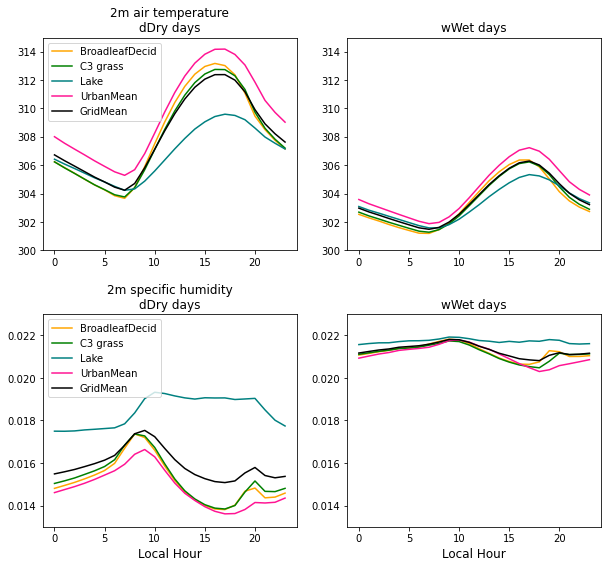

In [416]:
## Figure for manuscript

varSel = np.asarray(['TSA','Q2M'])
patchLabels[0] = 'BroadleafDecid'

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)


yMax = np.asarray([315, 0.023])
yMin = np.asarray([300, 0.013])

iPlot=0
for iVar in range(len(varSel)):
    ## Get urban mean
    iUrban = np.where((colType>=70) & (colType<80))[0]

    varSel_urban_dDry = np.nansum(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
    varSel_urban_wWet = np.nansum(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])

    ## dDry days 
    axs[iPlot].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, 0]),
             color='orange', label=patchLabels[0])
    axs[iPlot].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, 1]),
             color='green', label=patchLabels[1])
    axs[iPlot].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, -1]),
             color='teal',label=patchLabels[-1])
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTG.hour.values, varSel_urban_dDry,
             color='deeppink',label='UrbanMean')
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTG.hour.values, hourlyMeanCLM_dDry_HTG[varSel[iVar]].values, 'k-',label='GridMean')
    axs[iPlot].legend(loc='upper left',fontsize=10)
    axs[iPlot].set_title(HTGclmDS_patch_local[varSel[iVar]].long_name+'\ndDry days')
    axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])


    ## wWet days 
    axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, 0]),
             color='orange',label=patchLabels[0])
    axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, 1]),
             color='green',label=patchLabels[1])
    axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, -1]),
             color='teal',label=patchLabels[-1])
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTG.hour.values, varSel_urban_wWet,
             color='deeppink',label='UrbanMean')
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTG.hour.values, hourlyMeanCLM_wWet_HTG[varSel[iVar]].values, 'k-',label='GridMean')
    axs[iPlot+1].set_title('\nwWet days')
    axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2




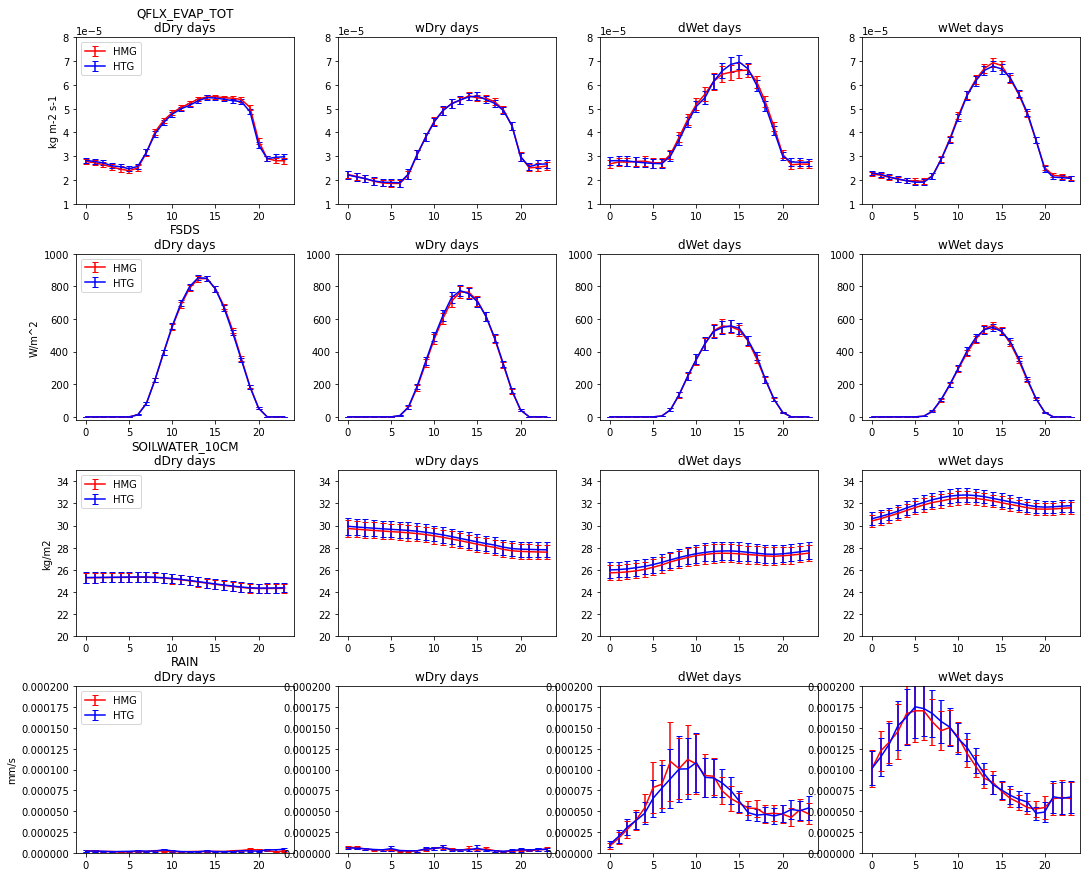

In [376]:
varSel = np.asarray(['QFLX_EVAP_TOT', 'FSDS','SOILWATER_10CM','RAIN'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([8e-5, 1000, 35, 2e-4])
yMin = np.asarray([1e-5, -20,  20, 0])

iPlot=0
for iVar in range(len(varSel)):
    
    # First get SE 
    HMGse_dDry, HTGse_dDry = get_hourlySE(varSel[iVar], 'CLM', 'dDry')
    HMGse_wDry, HTGse_wDry = get_hourlySE(varSel[iVar], 'CLM', 'wDry')
    HMGse_dWet, HTGse_dWet = get_hourlySE(varSel[iVar], 'CLM', 'dWet')
    HMGse_wWet, HTGse_wWet = get_hourlySE(varSel[iVar], 'CLM', 'wWet')
    
    
    axs[iPlot+0].errorbar(hourlyMeanCLM_dDry_HMG.hour.values, np.squeeze(hourlyMeanCLM_dDry_HMG[varSel[iVar]].values),
                          yerr = 2*HMGse_dDry,
                          fmt='r-',capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMeanCLM_dDry_HTG.hour.values, np.squeeze(hourlyMeanCLM_dDry_HTG[varSel[iVar]].values),
                          yerr=2*HTGse_dDry,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[iPlot+0].set_ylabel(HTGclmDS_local['PBLH'].units)
    else: 
        axs[iPlot+0].set_ylabel(HTGclmDS_local[varSel[iVar]].units)
    

    axs[iPlot+1].errorbar(hourlyMeanCLM_wDry_HMG.hour.values, np.squeeze(hourlyMeanCLM_wDry_HMG[varSel[iVar]].values),
                          yerr=2*HMGse_wDry,
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMeanCLM_wDry_HTG.hour.values, np.squeeze(hourlyMeanCLM_wDry_HTG[varSel[iVar]].values),
                          yerr=2*HTGse_wDry,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMeanCLM_dWet_HMG.hour.values, np.squeeze(hourlyMeanCLM_dWet_HMG[varSel[iVar]].values),
                          yerr=2*HMGse_dWet,
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMeanCLM_dWet_HTG.hour.values, np.squeeze(hourlyMeanCLM_dWet_HTG[varSel[iVar]].values),
                          yerr=2*HTGse_dWet,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMeanCLM_wWet_HMG.hour.values, np.squeeze(hourlyMeanCLM_wWet_HMG[varSel[iVar]].values), 
                          yerr=2*HMGse_wWet,
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMeanCLM_wWet_HTG.hour.values, np.squeeze(hourlyMeanCLM_wWet_HTG[varSel[iVar]].values), 
                          yerr=2*HTGse_wWet,
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4

    



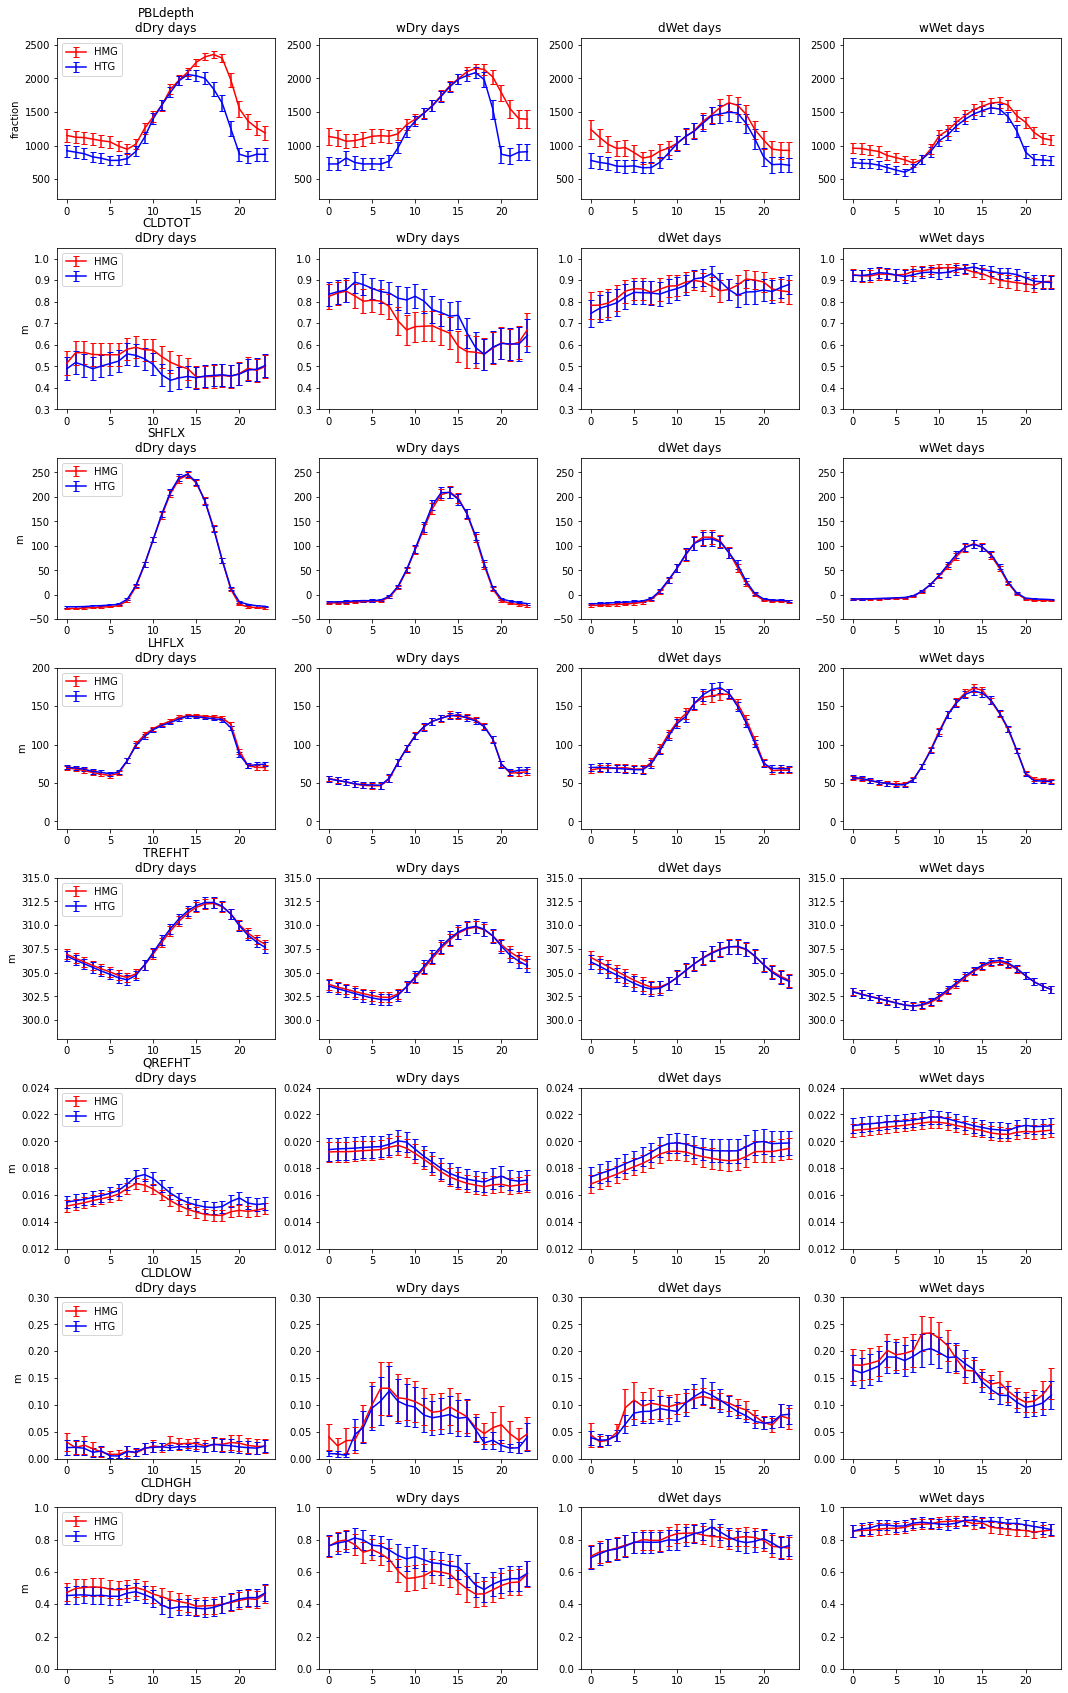

In [299]:
varSel = np.asarray(['PBLdepth','CLDTOT','SHFLX','LHFLX','TREFHT','QREFHT','CLDLOW','CLDHGH'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,30))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2600, 1.05, 280, 200, 315, 0.0240, 0.3, 1.0])
yMin = np.asarray([ 200, 0.3,  -50, -10, 298, 0.0120, 0.0, 0.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b-', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')
#     axs[iPlot+0].grid()


    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4





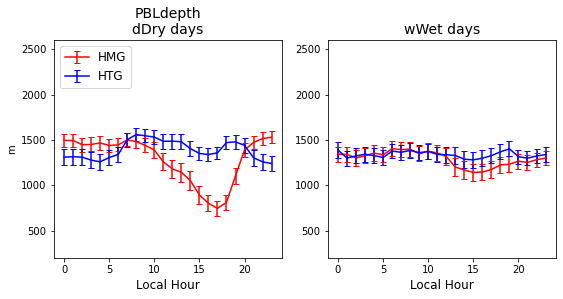

In [135]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['PBLdepth'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([2600])
yMin = np.asarray([ 200])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2







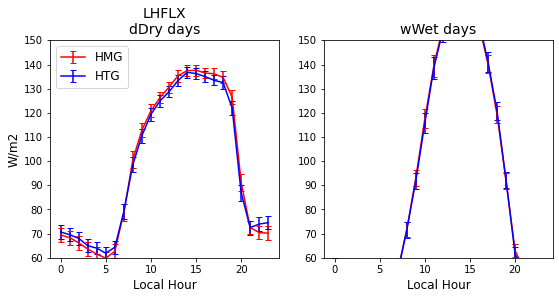

In [67]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['LHFLX'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([150])
yMin = np.asarray([ 60])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2



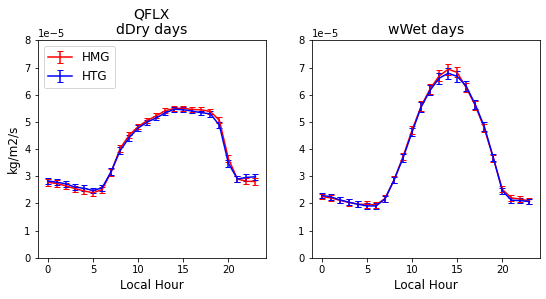

In [82]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['QFLX'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([8e-5])
yMin = np.asarray([0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2




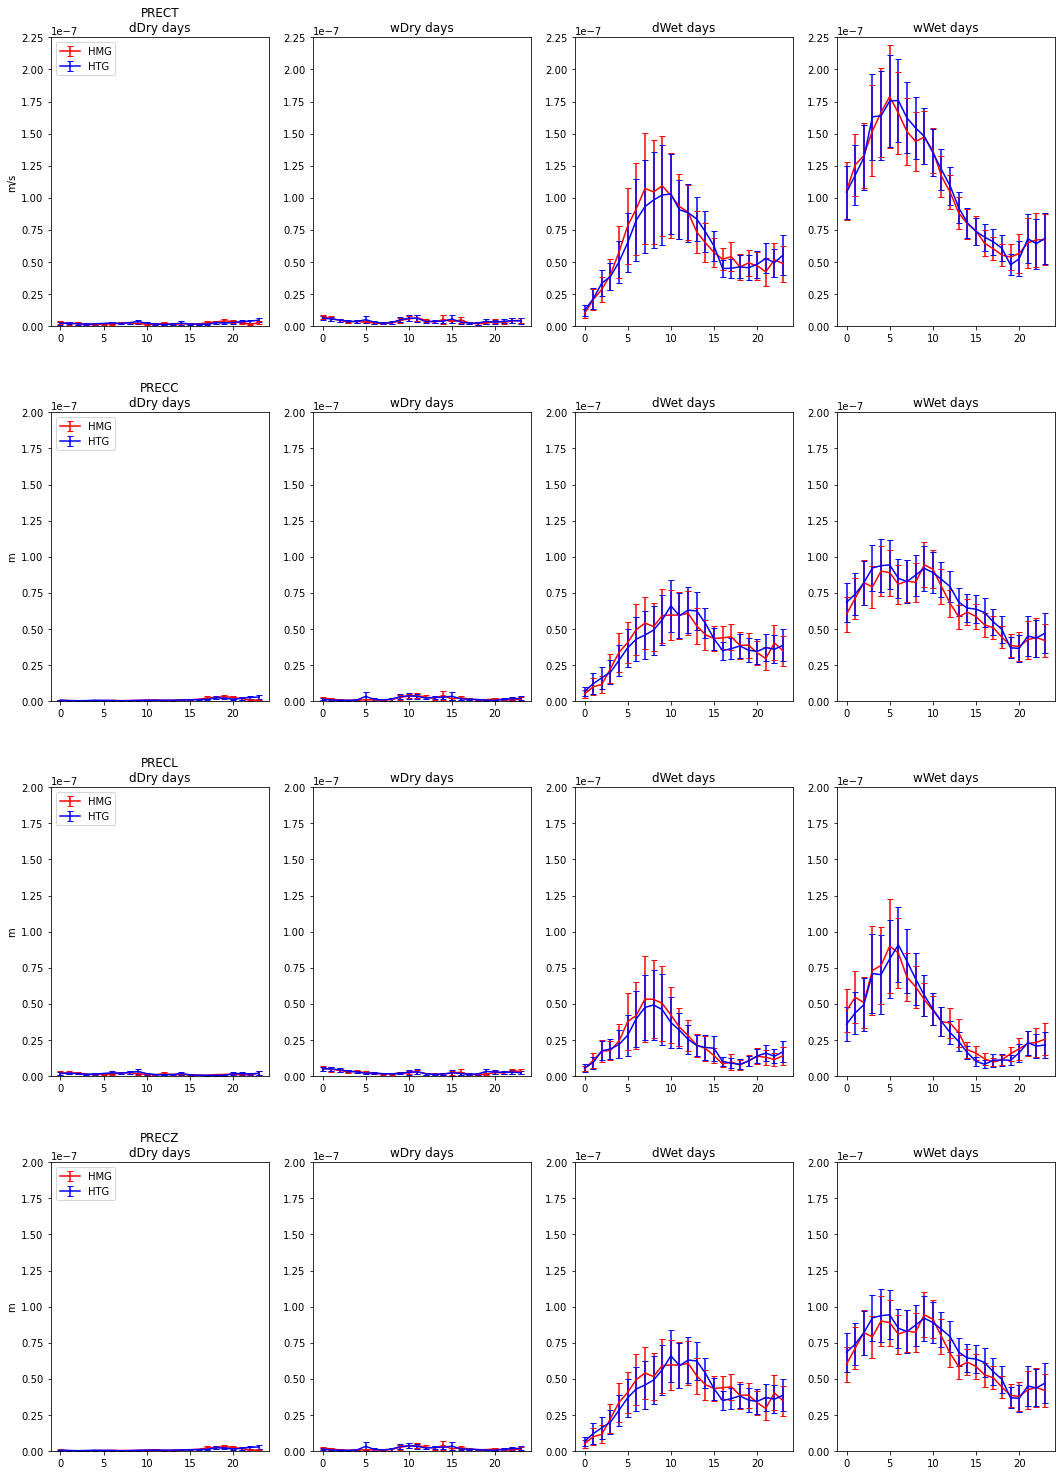

In [378]:
varSel = np.asarray(['PRECT','PRECC','PRECL','PRECZ'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,26))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2.25e-7, 2e-7, 2e-7, 2e-7])
yMin = np.asarray([ 0.0,  0.0,  0, 0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4






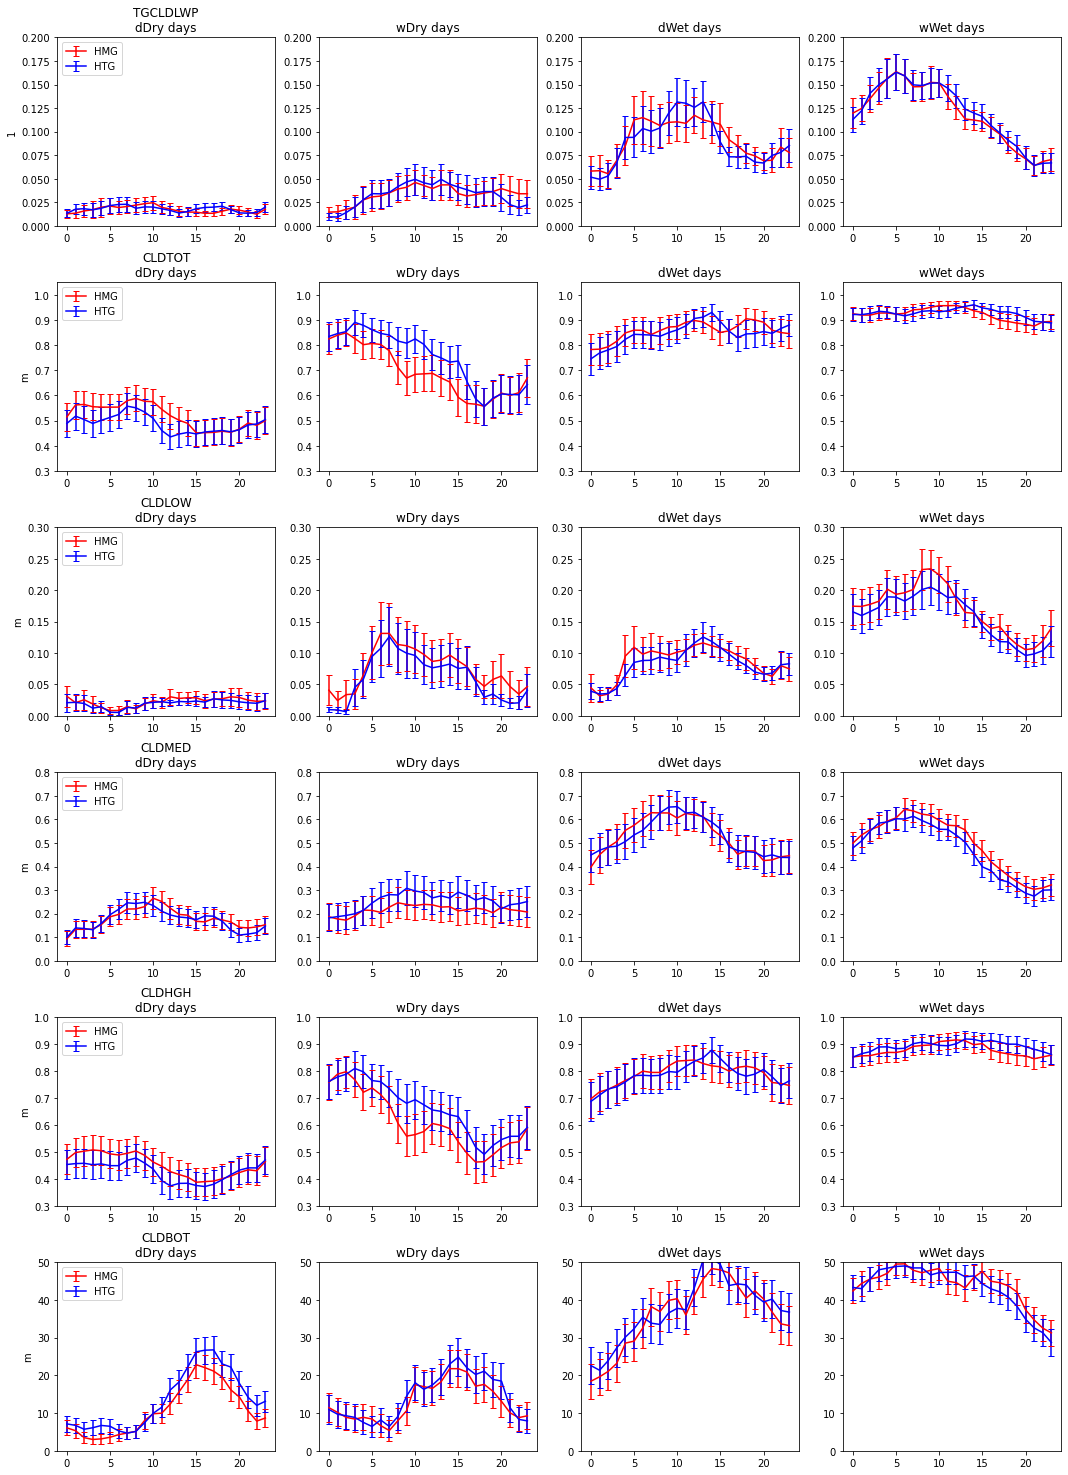

In [453]:
varSel = np.asarray(['TGCLDLWP','CLDTOT','CLDLOW','CLDMED','CLDHGH','CLDBOT'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,26))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([0.20, 1.05, 0.3, 0.8,   1, 50])
yMin = np.asarray([ 0.0,  0.3,   0,   0, 0.3,  0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4





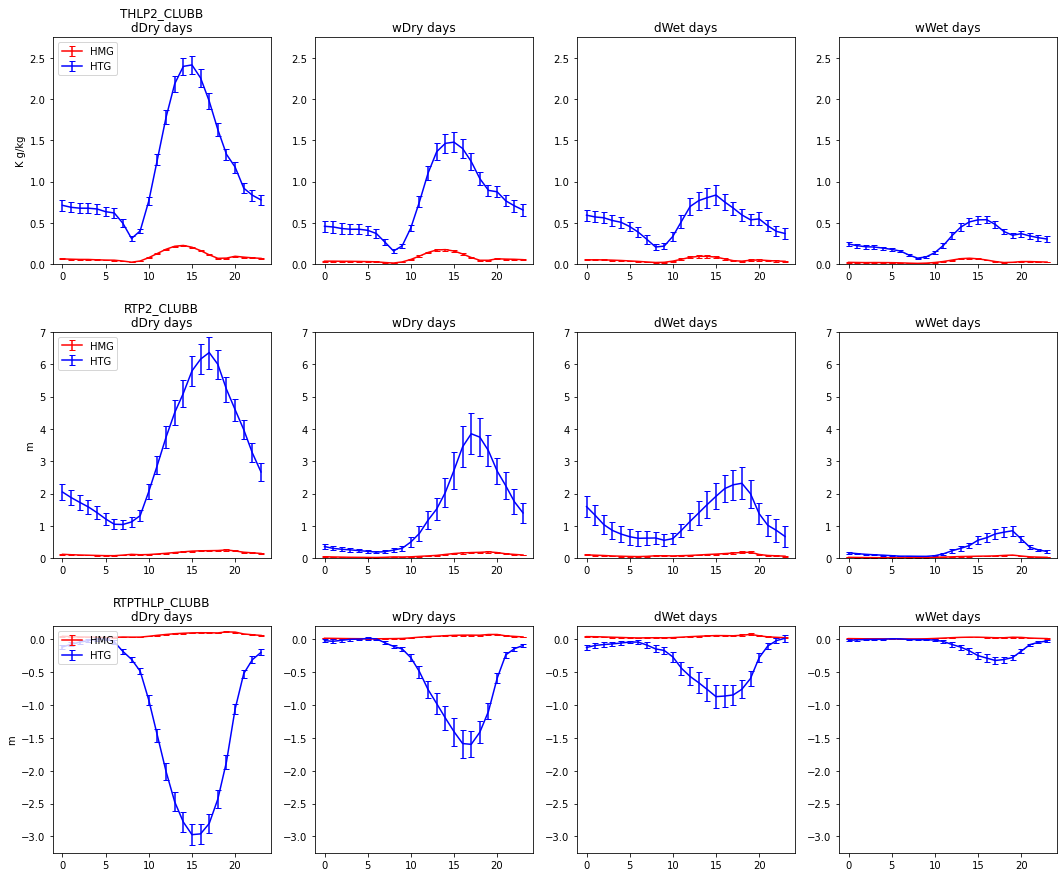

In [411]:
varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2.75, 7.0,  0.2])
yMin = np.asarray([0.0, 0.0, -3.25])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
#     ax2 = axs[iPlot+0].twinx()
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4





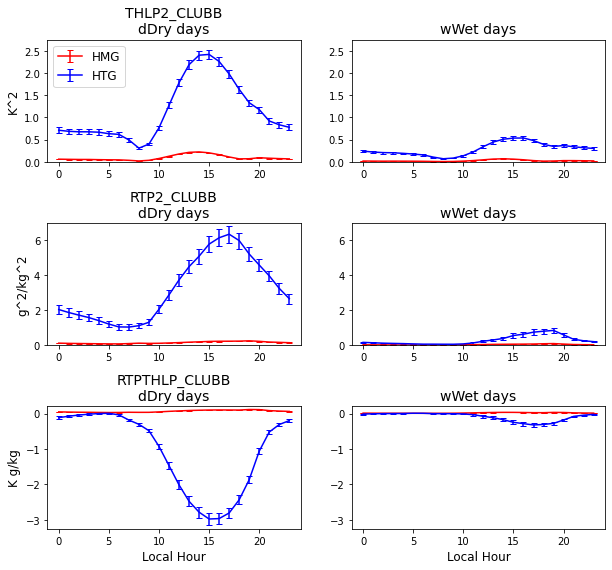

In [407]:
## Fig for manuscript 

varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2.75, 7.0,  0.2])
yMin = np.asarray([0.0, 0.0, -3.25])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2






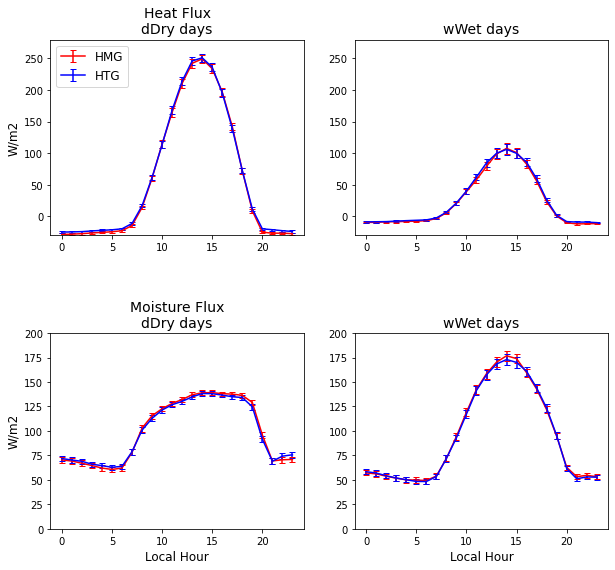

In [66]:
## Fig for manuscript 

varSel = np.asarray(['WPTHLP_CLUBB','WPRTP_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([280, 200])
yMin = np.asarray([-30.0, 0.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


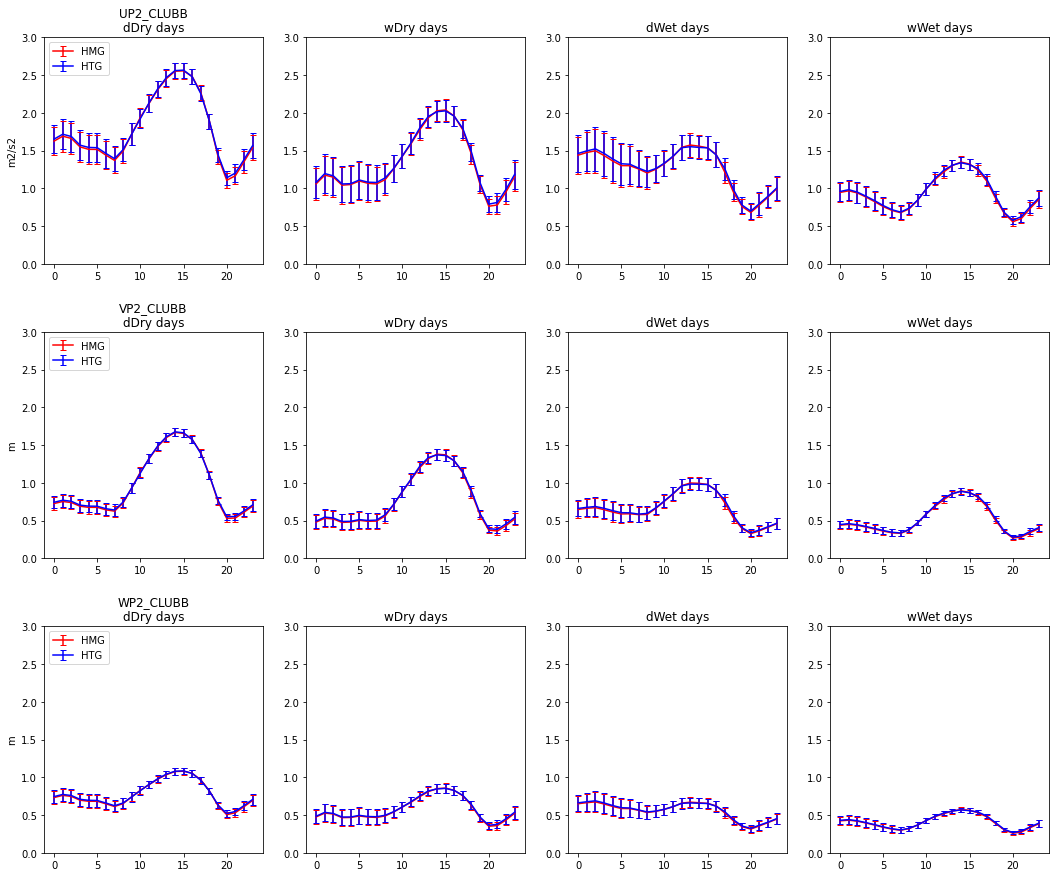

In [103]:
varSel = np.asarray(['UP2_CLUBB','VP2_CLUBB','WP2_CLUBB'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([3, 3,  3])
yMin = np.asarray([0.0, 0.0, 0.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].errorbar(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].errorbar(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+2].errorbar(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+3].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+3].set_title('\nwWet days')    

    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4






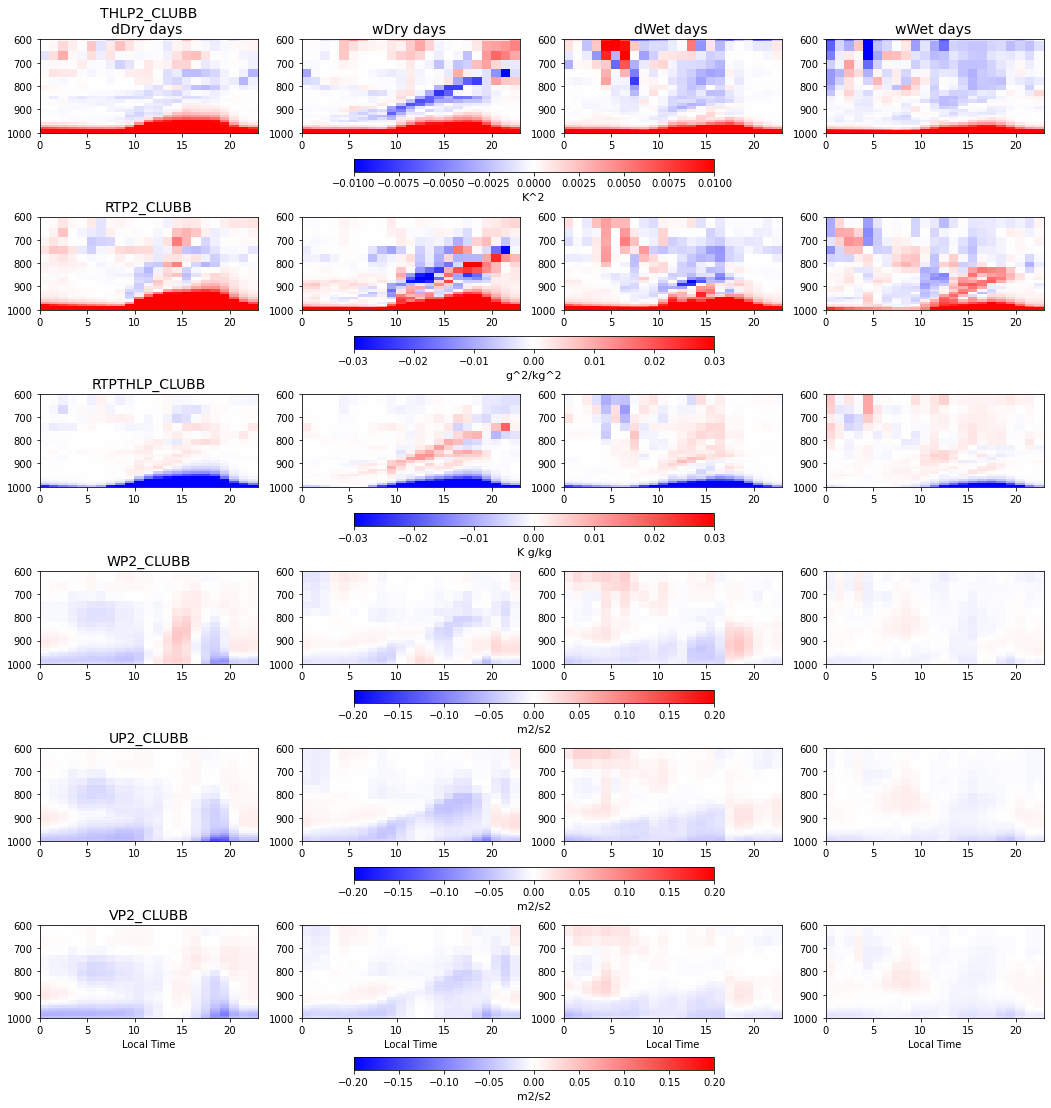

In [104]:
fig,axs = plt.subplots(6,4, figsize=(18,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 0.03, 0.03, 0.2, 0.2, 0.2])
yLim = 600

iPlot = 0
for iVar in range(6): 
        
    ## dD days 
    diffVar = np.squeeze(hourlyMean_dDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_dDry_HMG.hour.values, hourlyMean_dDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## wD days 
    diffVar = np.squeeze(hourlyMean_wDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_wDry_HMG.hour.values, hourlyMean_wDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.04, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    
    ## dW days 
    diffVar = np.squeeze(hourlyMean_dWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_dWet_HMG.hour.values, hourlyMean_dWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].invert_yaxis()
    axs[iPlot+2].set_ylim([1000, yLim])   
    
    ## wW days 
    diffVar = np.squeeze(hourlyMean_wWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+3].pcolormesh(hourlyMean_wWet_HMG.hour.values, hourlyMean_wWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+3].invert_yaxis()
    axs[iPlot+3].set_ylim([1000, yLim])   
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title(ATM_varNames[iVar]+'\ndDry days ',fontsize=14)
        axs[iPlot+1].set_title('wDry days ',fontsize=14)
        axs[iPlot+2].set_title('dWet days ',fontsize=14)
        axs[iPlot+3].set_title('wWet days ',fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
        axs[iPlot+3].set_xlabel('Local Time')
    
    iPlot = iPlot+4
    

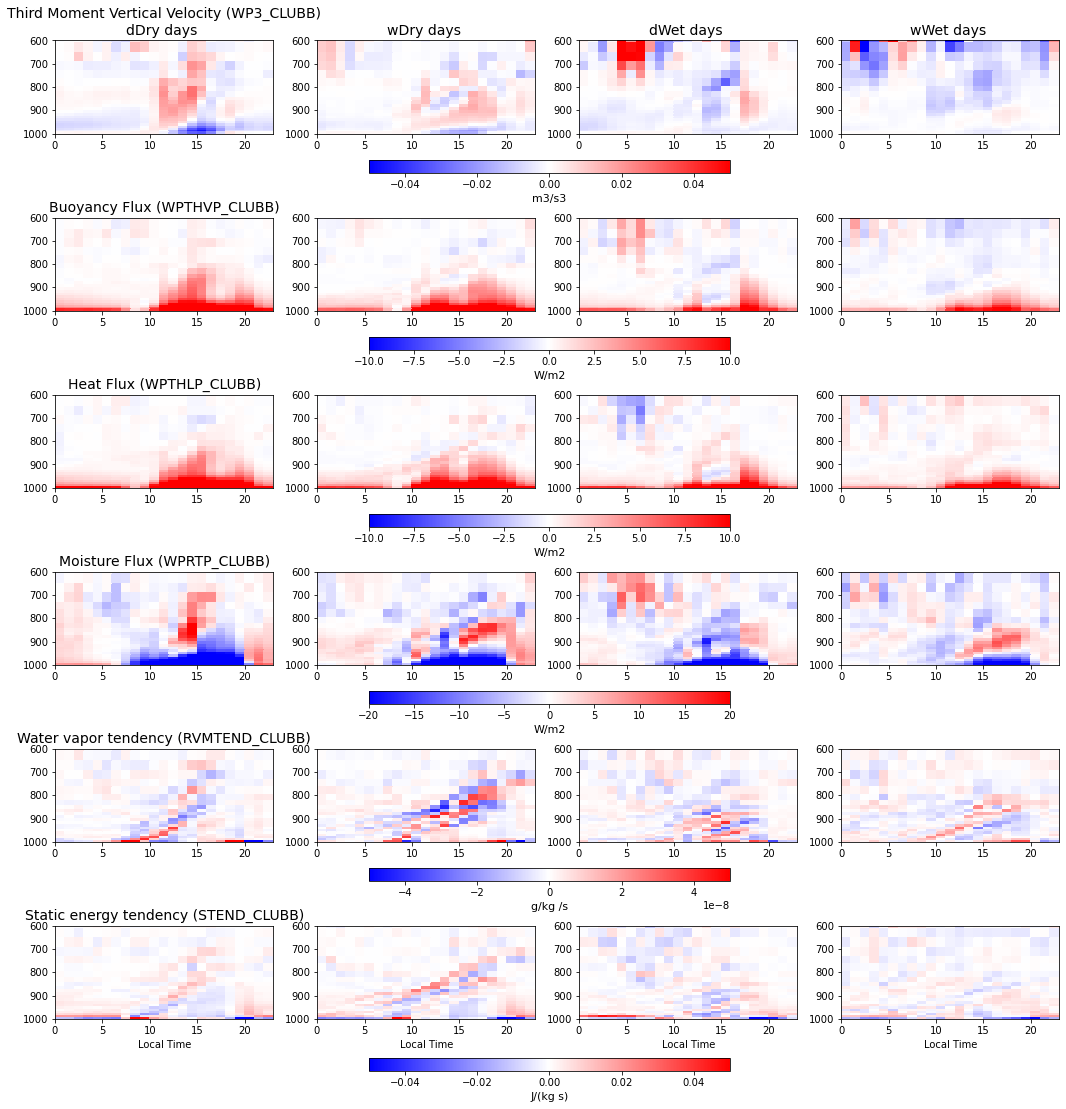

In [105]:
fig,axs = plt.subplots(6,4, figsize=(18,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.05, 10, 10, 20, 5e-8, 5e-2])
yLim = 600

iPlot = 0
for iVar in range(6): 
        
    ## dD days 
    diffVar = np.squeeze(hourlyMean_dDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_dDry_HMG.hour.values, hourlyMean_dDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## wD days 
    diffVar = np.squeeze(hourlyMean_wDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_wDry_HMG.hour.values, hourlyMean_wDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.04, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    
    ## dW days 
    diffVar = np.squeeze(hourlyMean_dWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_dWet_HMG.hour.values, hourlyMean_dWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].invert_yaxis()
    axs[iPlot+2].set_ylim([1000, yLim])   
    
    ## wW days 
    diffVar = np.squeeze(hourlyMean_wWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+3].pcolormesh(hourlyMean_wWet_HMG.hour.values, hourlyMean_wWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+3].invert_yaxis()
    axs[iPlot+3].set_ylim([1000, yLim])   
    
    axs[iPlot].set_title(HTGcamDS_all[ATM_varNames[iVar]].long_name+' ('+ATM_varNames[iVar]+')',fontsize=14)

    if iVar==0:
        axs[iPlot].set_title(HTGcamDS_all[ATM_varNames[iVar]].long_name+' ('+ATM_varNames[iVar]+')'+'\ndDry days ',fontsize=14)
        axs[iPlot+1].set_title('wDry days ',fontsize=14)
        axs[iPlot+2].set_title('dWet days ',fontsize=14)
        axs[iPlot+3].set_title('wWet days ',fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
        axs[iPlot+3].set_xlabel('Local Time')
    
    iPlot = iPlot+4
    

Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nT')

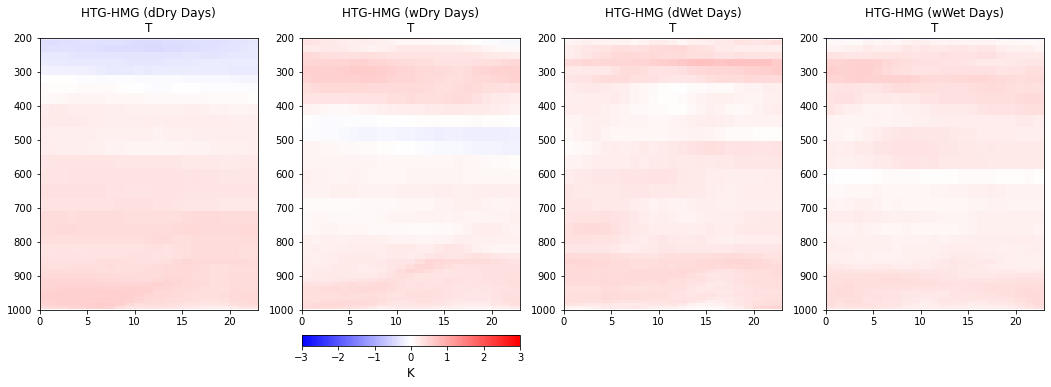

In [106]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'T' 
cMin = -3
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)


Text(0.5, 1.0, 'HTG (wWet Days)\nT')

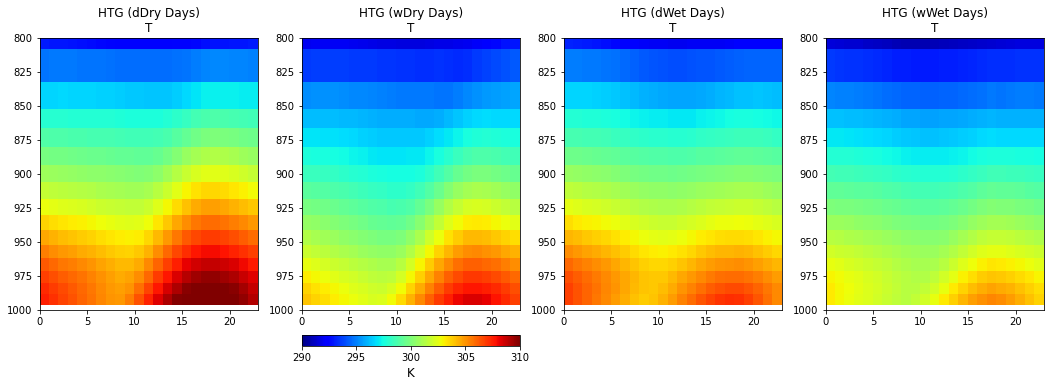

In [430]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'T' 
cMin = 290
cMax = 310 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='jet')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='jet')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='jet')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='jet')


# Consistent settings 
axs[0].set_ylim([800,1000])
axs[1].set_ylim([800,1000])
axs[2].set_ylim([800,1000])
axs[3].set_ylim([800,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG (dDry Days)\n'+varSel)
axs[1].set_title('HTG (wDry Days)\n'+varSel)
axs[2].set_title('HTG (dWet Days)\n'+varSel)
axs[3].set_title('HTG (wWet Days)\n'+varSel)



Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nQ')

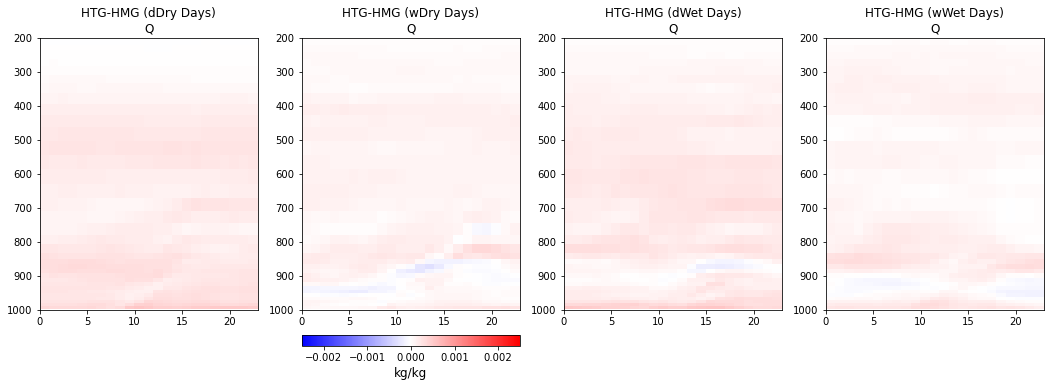

In [107]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'Q' 
cMin = -0.0025
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)



Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nU')

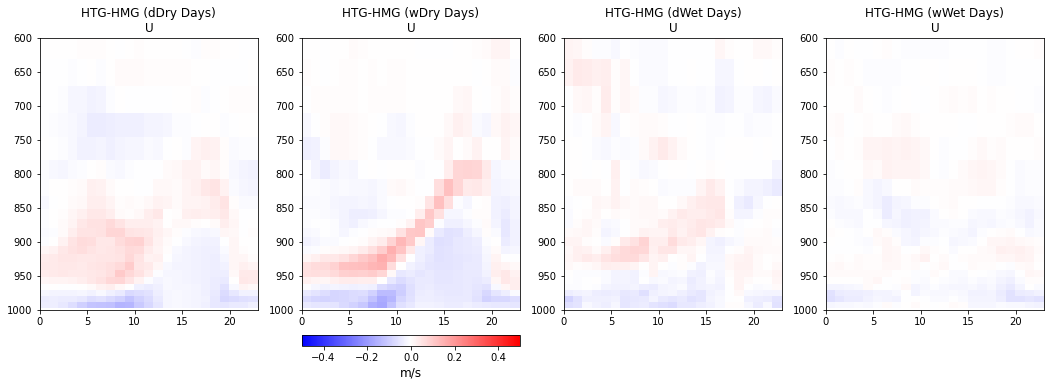

In [108]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'U' 
cMin = -0.5
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([600,1000])
axs[1].set_ylim([600,1000])
axs[2].set_ylim([600,1000])
axs[3].set_ylim([600,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)




Text(0.5, 1.0, 'HTG-HMG (wWet Days)\n')

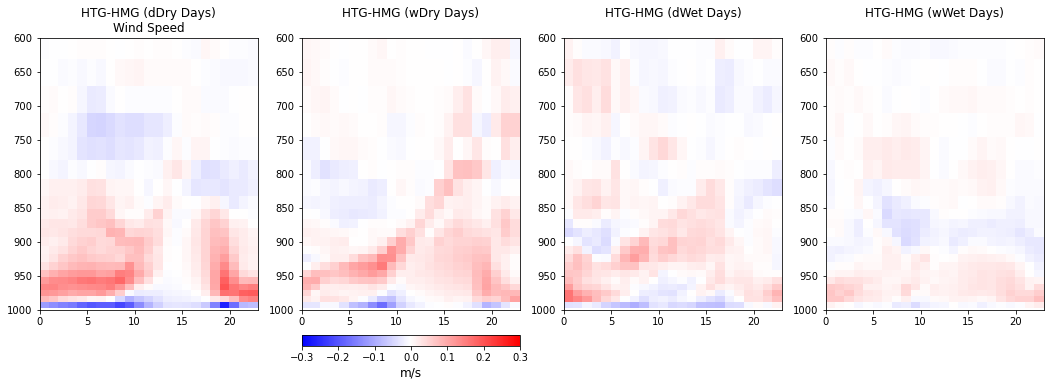

In [111]:
# Wind speed difference 
windSpeed_dDry_HTG = np.sqrt((hourlyMean_dDry_HTG['U'].values**2) + (hourlyMean_dDry_HTG['V'].values**2))
windSpeed_dDry_HMG = np.sqrt((hourlyMean_dDry_HMG['U'].values**2) + (hourlyMean_dDry_HMG['V'].values**2))

windSpeed_wDry_HTG = np.sqrt((hourlyMean_wDry_HTG['U'].values**2) + (hourlyMean_wDry_HTG['V'].values**2))
windSpeed_wDry_HMG = np.sqrt((hourlyMean_wDry_HMG['U'].values**2) + (hourlyMean_wDry_HMG['V'].values**2))

windSpeed_dWet_HTG = np.sqrt((hourlyMean_dWet_HTG['U'].values**2) + (hourlyMean_dWet_HTG['V'].values**2))
windSpeed_dWet_HMG = np.sqrt((hourlyMean_dWet_HMG['U'].values**2) + (hourlyMean_dWet_HMG['V'].values**2))

windSpeed_wWet_HTG = np.sqrt((hourlyMean_wWet_HTG['U'].values**2) + (hourlyMean_wWet_HTG['V'].values**2))
windSpeed_wWet_HMG = np.sqrt((hourlyMean_wWet_HMG['U'].values**2) + (hourlyMean_wWet_HMG['V'].values**2))

hourlyMean_dDry_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dDry_HTG))
hourlyMean_dDry_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dDry_HMG))
hourlyMean_wDry_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wDry_HTG))
hourlyMean_wDry_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wDry_HMG))
hourlyMean_dWet_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dWet_HTG))
hourlyMean_dWet_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_dWet_HMG))
hourlyMean_wWet_HTG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wWet_HTG))
hourlyMean_wWet_HMG['WindMagnitude'] = (('hour','lev'), np.squeeze(windSpeed_wWet_HMG))


fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

cMin = -0.3
cMax = -cMin 

# Define differences 
diffVar_dDry = windSpeed_dDry_HTG-windSpeed_dDry_HMG
diffVar_wDry = windSpeed_wDry_HTG-windSpeed_wDry_HMG
diffVar_dWet = windSpeed_dWet_HTG-windSpeed_dWet_HMG
diffVar_wWet = windSpeed_wWet_HTG-windSpeed_wWet_HMG

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local['U'].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([600,1000])
axs[1].set_ylim([600,1000])
axs[2].set_ylim([600,1000])
axs[3].set_ylim([600,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+'Wind Speed')
axs[1].set_title('HTG-HMG (wDry Days)\n')
axs[2].set_title('HTG-HMG (dWet Days)\n')
axs[3].set_title('HTG-HMG (wWet Days)\n')





Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCLDLIQ')

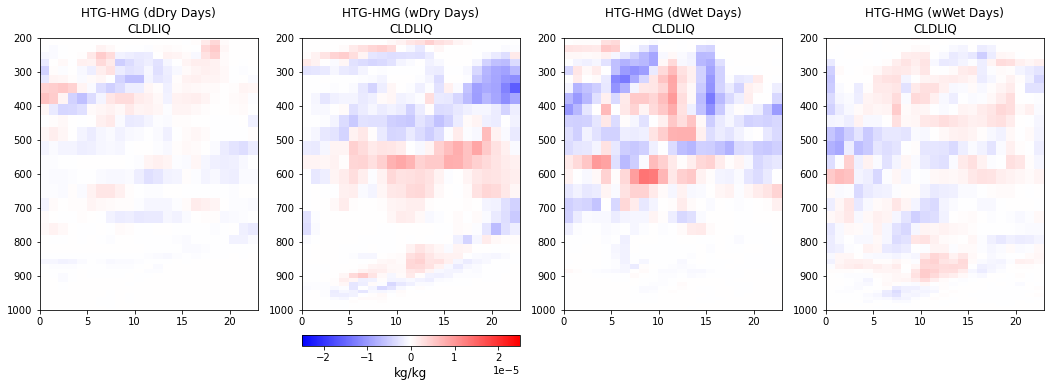

In [112]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CLDLIQ' 
cMin = -0.000025
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)




Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCLOUD')

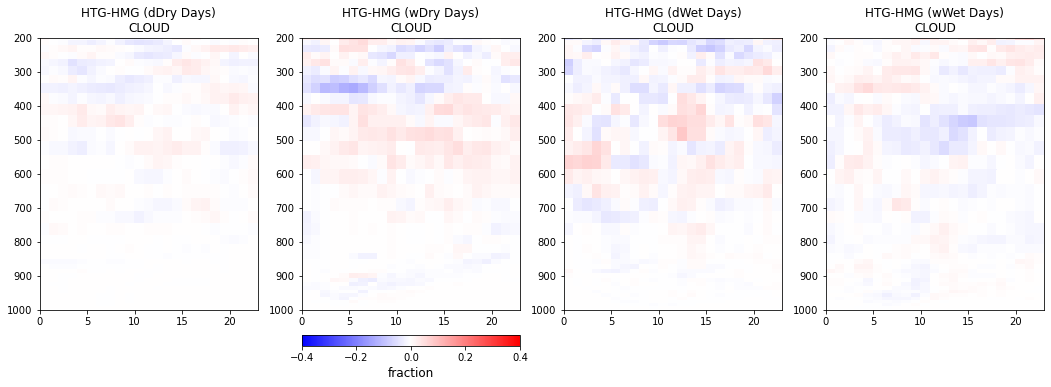

In [113]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CLOUD' 
cMin = -0.4
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)





Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCONCLD')

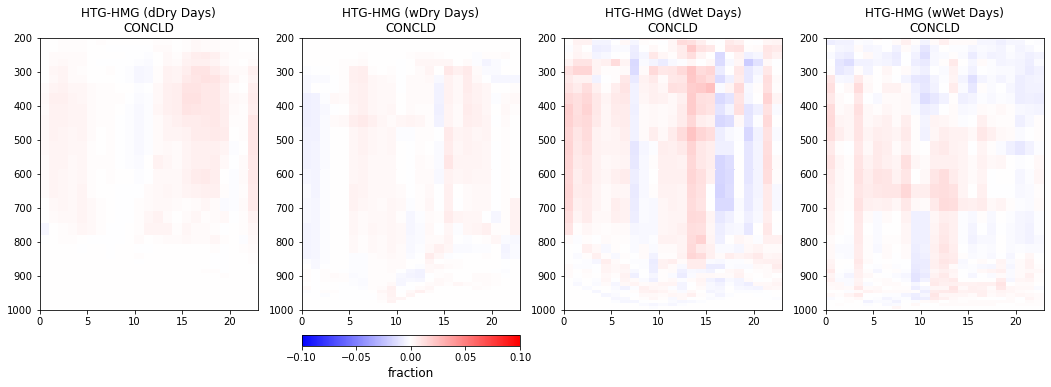

In [114]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CONCLD' 
cMin = -0.1
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)






In [38]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, varSel, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))
    


    # ------- wDry days ----------
    iTimeSel_wDryHMG = np.where((wDryDays_HMG["time.hour"].values>=startHr) & 
                                (wDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_wDryHTG = np.where((wDryDays_HTG["time.hour"].values>=startHr) & 
                                (wDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_wDryTimeSel_HMG = wDryDays_HMG.isel(time=iTimeSel_wDryHMG).mean(dim='time')
    hourlyMean_wDryTimeSel_HTG = wDryDays_HTG.isel(time=iTimeSel_wDryHTG).mean(dim='time')
    
    hourlyStd_wDryTimeSel_HMG = wDryDays_HMG.isel(time=iTimeSel_wDryHMG).std(dim='time')
    hourlyStd_wDryTimeSel_HTG = wDryDays_HTG.isel(time=iTimeSel_wDryHTG).std(dim='time')
    
    stdErr_wDry_HMG = np.squeeze(hourlyStd_wDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_wDryHMG))
    stdErr_wDry_HTG = np.squeeze(hourlyStd_wDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_wDryHTG))


    # ------- dWet days ----------
    iTimeSel_dWetHMG = np.where((dWetDays_HMG["time.hour"].values>=startHr) & 
                                (dWetDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dWetHTG = np.where((dWetDays_HTG["time.hour"].values>=startHr) & 
                                (dWetDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dWetTimeSel_HMG = dWetDays_HMG.isel(time=iTimeSel_dWetHMG).mean(dim='time')
    hourlyMean_dWetTimeSel_HTG = dWetDays_HTG.isel(time=iTimeSel_dWetHTG).mean(dim='time')
    
    hourlyStd_dWetTimeSel_HMG = dWetDays_HMG.isel(time=iTimeSel_dWetHMG).std(dim='time')
    hourlyStd_dWetTimeSel_HTG = dWetDays_HTG.isel(time=iTimeSel_dWetHTG).std(dim='time')
    
    stdErr_dWet_HMG = np.squeeze(hourlyStd_dWetTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dWetHMG))
    stdErr_dWet_HTG = np.squeeze(hourlyStd_dWetTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dWetHTG))


    # ------- wWet days ----------
    iTimeSel_wWetHMG = np.where((wWetDays_HMG["time.hour"].values>=startHr) & 
                                (wWetDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_wWetHTG = np.where((wWetDays_HTG["time.hour"].values>=startHr) & 
                                (wWetDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).mean(dim='time')
    hourlyMean_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).mean(dim='time')
    
    hourlyStd_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).std(dim='time')
    hourlyStd_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).std(dim='time')
    
    stdErr_wWet_HMG = np.squeeze(hourlyStd_wWetTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_wWetHMG))
    stdErr_wWet_HTG = np.squeeze(hourlyStd_wWetTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_wWetHTG))

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,4, figsize=(17,5))
    axs     = axs.ravel()
    
    # Select which levels array to use
    if np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.lev.values):
        levSel = 'lev'
        
    if varSel=='WindMagnitude':
        unitLabel  = HTGcamDS_local['U'].units
    elif varSel=='theta':
        unitLabel = HTGcamDS_local['T'].units
    else: 
        unitLabel  = HTGcamDS_local[varSel].units
    
    # Plot dDry days 
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dDry_HMG,
#                     fmt='r-', capsize=3, label='HMG')
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
                    hourlyMean_dDryTimeSel_HMG[levSel].values,
                    'r-',  label='HMG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
                    hourlyMean_dDryTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[0].legend()
    axs[0].set_title(varSel+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel('hPa')
    axs[0].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(hourlyMean_dDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev]):
                axs[0].plot(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_dDryTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[0].plot(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev], 
                        hourlyMean_dDryTimeSel_HTG[levSel].values[iLev], 
                        'bo')
    
    
    
    

    # Plot wDry days 
#     axs[1].errorbar(np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_wDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wDry_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[1].errorbar(np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_wDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[1].plot(np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values), 
                    hourlyMean_wDryTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[1].plot(np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values), 
                    hourlyMean_wDryTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[1].set_title(varSel+'\nwDry days')
    axs[1].set_xlabel(unitLabel)
        # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values) + (2*stdErr_wDry_HMG)
    xmin1 = np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values) - (2*stdErr_wDry_HMG)
    xmax2 = np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values) + (2*stdErr_wDry_HTG)
    xmin2 = np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values) - (2*stdErr_wDry_HTG)

    levSig = np.ones([len(hourlyMean_wDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_wDryTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_wDryTimeSel_HTG[varSel].values[iLev]):
                axs[1].plot(hourlyMean_wDryTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_wDryTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[1].plot(hourlyMean_wDryTimeSel_HTG[varSel].values[iLev], 
                            hourlyMean_wDryTimeSel_HTG[levSel].values[iLev], 
                            'bo')
            
            

    # Plot dWet days 
#     axs[2].errorbar(np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values), 
#                     hourlyMean_dWetTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dWet_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[2].errorbar(np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values), 
#                     hourlyMean_dWetTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dWet_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[2].plot(np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values), 
                    hourlyMean_dWetTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[2].plot(np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values), 
                    hourlyMean_dWetTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[2].set_title(varSel+'\ndWet days')
    axs[2].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values) + (2*stdErr_dWet_HMG)
    xmin1 = np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values) - (2*stdErr_dWet_HMG)
    xmax2 = np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values) + (2*stdErr_dWet_HTG)
    xmin2 = np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values) - (2*stdErr_dWet_HTG)

    levSig = np.ones([len(hourlyMean_dWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_dWetTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_dWetTimeSel_HTG[varSel].values[iLev]):
                axs[2].plot(hourlyMean_dWetTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_dWetTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[2].plot(hourlyMean_dWetTimeSel_HTG[varSel].values[iLev], 
                            hourlyMean_dWetTimeSel_HTG[levSel].values[iLev], 
                            'bo')
            

    # Plot wWet days 
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wWet_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wWet_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[3].plot(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
                    hourlyMean_wWetTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[3].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[3].legend()
    axs[3].set_title(varSel+'\nwWet days')
    axs[3].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) + (2*stdErr_wWet_HMG)
    xmin1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) - (2*stdErr_wWet_HMG)
    xmax2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) + (2*stdErr_wWet_HTG)
    xmin2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) - (2*stdErr_wWet_HTG)

    levSig = np.ones([len(hourlyMean_wWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            if abs(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev]):
                axs[3].plot(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev], 
                            hourlyMean_wWetTimeSel_HMG[levSel].values[iLev], 
                            'ro')
            else:
                axs[3].plot(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev], 
                            hourlyMean_wWetTimeSel_HTG[levSel].values[iLev], 
                            'bo')

    # Consistent settings across subplots 
    axs[0].set_ylim([maxLev,1000])
    axs[1].set_ylim([maxLev,1000])
    axs[2].set_ylim([maxLev,1000])
    axs[3].set_ylim([maxLev,1000])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    axs[2].set_xlim([xMin,xMax])
    axs[3].set_xlim([xMin,xMax])
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    
    return

In [39]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, varSel, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))
    

    # ------- wWet days ----------
    iTimeSel_wWetHMG = np.where((wWetDays_HMG["time.hour"].values>=startHr) & 
                                (wWetDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_wWetHTG = np.where((wWetDays_HTG["time.hour"].values>=startHr) & 
                                (wWetDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).mean(dim='time')
    hourlyMean_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).mean(dim='time')
    
    hourlyStd_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).std(dim='time')
    hourlyStd_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).std(dim='time')
    
    stdErr_wWet_HMG = np.squeeze(hourlyStd_wWetTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_wWetHMG))
    stdErr_wWet_HTG = np.squeeze(hourlyStd_wWetTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_wWetHTG))

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    axs     = axs.ravel()
    
    # Select which levels array to use
    if np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.lev.values):
        levSel = 'lev'
        
    if varSel=='WindMagnitude':
        unitLabel  = HTGcamDS_local['U'].units
        titleStr   = varSel
    elif varSel=='theta':
        unitLabel = HTGcamDS_local['T'].units
        titleStr   = varSel
    elif varSel=='Skw_W':
        unitLabel = ' '
        titleStr   = varSel
    else: 
        unitLabel  = HTGcamDS_local[varSel].units
        titleStr   = HTGcamDS_local[varSel].long_name
    
    # Plot dDry days 
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dDry_HMG,
#                     fmt='r-', capsize=3, label='HMG')
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
                    hourlyMean_dDryTimeSel_HMG[levSel].values,
                    'r-',  label='HMG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
                    hourlyMean_dDryTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[0].legend()
    axs[0].set_title(titleStr+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel('hPa')
    axs[0].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(hourlyMean_dDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
#             if abs(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev]):
            axs[0].plot(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_dDryTimeSel_HMG[levSel].values[iLev], 
                        'ro')
#             else:
            axs[0].plot(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev], 
                    hourlyMean_dDryTimeSel_HTG[levSel].values[iLev], 
                    'bo')
    
            

    # Plot wWet days 
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wWet_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wWet_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
                    hourlyMean_wWetTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG[levSel].values,
                    'b', label='HTG')
#     axs[1].legend()
    axs[1].set_title(varSel+'\nwWet days')
    axs[1].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) + (2*stdErr_wWet_HMG)
    xmin1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) - (2*stdErr_wWet_HMG)
    xmax2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) + (2*stdErr_wWet_HTG)
    xmin2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) - (2*stdErr_wWet_HTG)

    levSig = np.ones([len(hourlyMean_wWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
#             if abs(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev]):
            axs[1].plot(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HMG[levSel].values[iLev], 
                        'ro')
#             else:
            axs[1].plot(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HTG[levSel].values[iLev], 
                        'bo')

    # Consistent settings across subplots 
    axs[0].set_ylim([maxLev,1000])
    axs[1].set_ylim([maxLev,1000])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()

    
    return

Means computed over the inclusive period of 15 to 17.


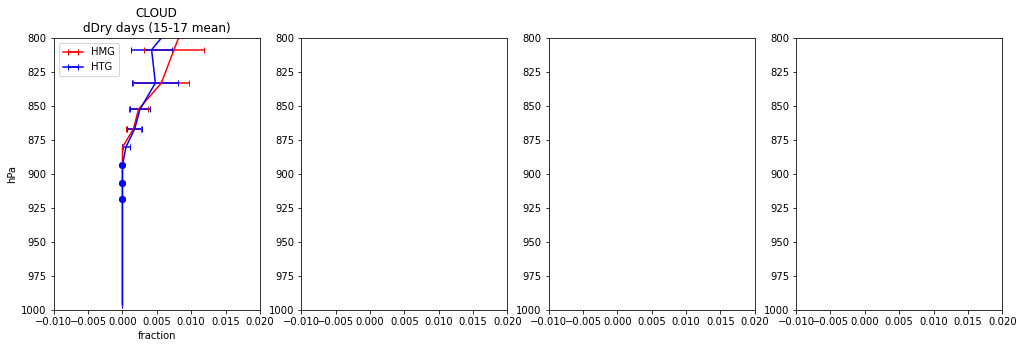

In [40]:
## First, get mean over those hours 

startHr = 15
endHr   = 17
maxLev  = 800
xMin = -0.01
xMax = 0.02
varSel  = 'CLOUD'

# ------- dDry days ----------
iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                            (dDryDays_HMG["time.hour"].values<=endHr))[0]
iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                            (dDryDays_HTG["time.hour"].values<=endHr))[0]


hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')

hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')

stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))



print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))




## Now we can figure out how to plot! 
fig,axs = plt.subplots(1,4, figsize=(17,5))
axs     = axs.ravel()

# Select which levels array to use
if np.shape(hourlyMean_dDryTimeSel_HMG[varSel].values)[0]==len(hourlyMean_dDryTimeSel_HMG.ilev.values): 
    levSel = 'ilev'
elif np.shape(hourlyMean_dDryTimeSel_HMG[varSel].values)[0]==len(hourlyMean_dDryTimeSel_HMG.lev.values):
    levSel = 'lev'

# Plot dDry days 
axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
                hourlyMean_dDryTimeSel_HMG[levSel].values,
                xerr = 2*stdErr_dDry_HMG,
                fmt='r-', capsize=3, label='HMG')
axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
                hourlyMean_dDryTimeSel_HTG[levSel].values,
                xerr = 2*stdErr_dDry_HTG,
                fmt='b', capsize=3, label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
axs[0].set_ylabel('hPa')
axs[0].set_xlabel(HTGcamDS_local[varSel].units)
# Signal significance? 
xmax1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) + (2*stdErr_dDry_HMG)
xmin1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) - (2*stdErr_dDry_HMG)
xmax2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) + (2*stdErr_dDry_HTG)
xmin2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) - (2*stdErr_dDry_HTG)

levSig = np.ones([len(hourlyMean_dDryTimeSel_HMG[levSel].values)])
for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
    if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
        levSig[iLev] = 0
    elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
        levSig[iLev] = 0

    if levSig[iLev]==1:
        axs[0].plot(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev], 
                    hourlyMean_dDryTimeSel_HMG[levSel].values[iLev], 
                    'ro')
        axs[0].plot(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev], 
                    hourlyMean_dDryTimeSel_HTG[levSel].values[iLev], 
                    'bo')


# Consistent settings across subplots 
axs[0].set_ylim([maxLev,1000])
axs[1].set_ylim([maxLev,1000])
axs[2].set_ylim([maxLev,1000])
axs[3].set_ylim([maxLev,1000])

axs[0].set_xlim([xMin,xMax])
axs[1].set_xlim([xMin,xMax])
axs[2].set_xlim([xMin,xMax])
axs[3].set_xlim([xMin,xMax])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()


In [328]:
print(' level (hPa)      levSig         HMGval   HMG+/-       HTGval  HTG+/-')
for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
    print('%7.2f %14i %15.2e %10.2e %12.2e  %6.2e' % (hourlyMean_dDryTimeSel_HMG[levSel].values[iLev],
                                       levSig[iLev],
                                       hourlyMean_dDryTimeSel_HMG[varSel].values[iLev],
                                       (2*stdErr_dDry_HMG[iLev]),
                                       hourlyMean_dDryTimeSel_HTG[varSel].values[iLev],
                                       (2*stdErr_dDry_HTG[iLev])))

 level (hPa)      levSig         HMGval   HMG+/-       HTGval  HTG+/-
   2.95              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
   4.34              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
   6.31              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
   8.88              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  12.26              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  16.46              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  21.58              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  27.17              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  32.83              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  37.60              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  41.23              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  45.15              0        0.00e+00   0.00e+00     0.00e+00  0.00e+00
  49.40              0        0.00e+00   0.00e+00     

In [41]:
## Add wind speed to underlying DS

windSpeed_dDryDays_HMG = np.sqrt((dDryDays_HMG.U.values**2.0) + (dDryDays_HMG.V.values**2.0))
windSpeed_dDryDays_HTG = np.sqrt((dDryDays_HTG.U.values**2.0) + (dDryDays_HTG.V.values**2.0))

windSpeed_wDryDays_HMG = np.sqrt((wDryDays_HMG.U.values**2.0) + (wDryDays_HMG.V.values**2.0))
windSpeed_wDryDays_HTG = np.sqrt((wDryDays_HTG.U.values**2.0) + (wDryDays_HTG.V.values**2.0))

windSpeed_dWetDays_HMG = np.sqrt((dWetDays_HMG.U.values**2.0) + (dWetDays_HMG.V.values**2.0))
windSpeed_dWetDays_HTG = np.sqrt((dWetDays_HTG.U.values**2.0) + (dWetDays_HTG.V.values**2.0))

windSpeed_wWetDays_HMG = np.sqrt((wWetDays_HMG.U.values**2.0) + (wWetDays_HMG.V.values**2.0))
windSpeed_wWetDays_HTG = np.sqrt((wWetDays_HTG.U.values**2.0) + (wWetDays_HTG.V.values**2.0))


dDryDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HMG))
dDryDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HTG))

wDryDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wDryDays_HMG))
wDryDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wDryDays_HTG))

dWetDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dWetDays_HMG))
dWetDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dWetDays_HTG))

wWetDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HMG))
wWetDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HTG))



In [42]:
startHr = 14
endHr   = 17
# startHr = 12
# endHr   = 17
maxLev  = 800

Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


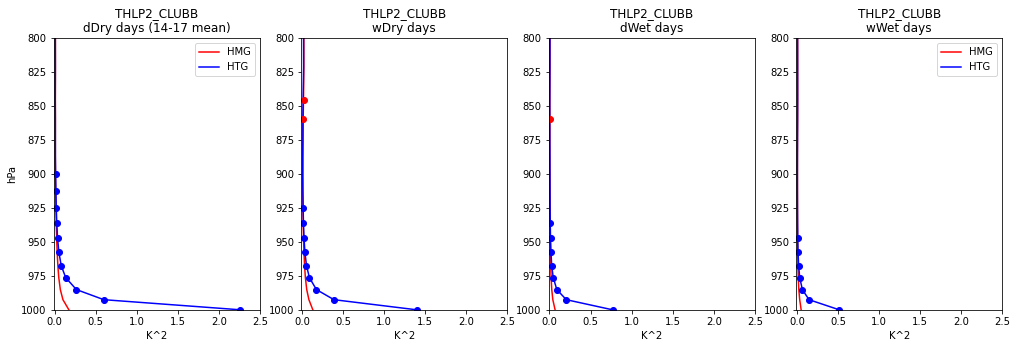

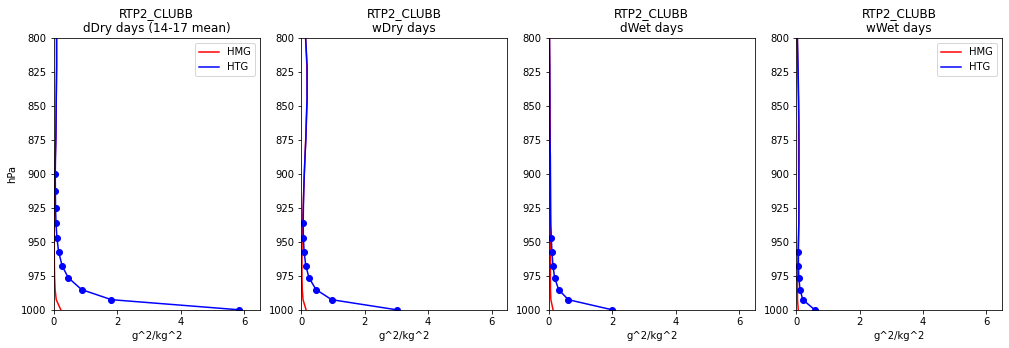

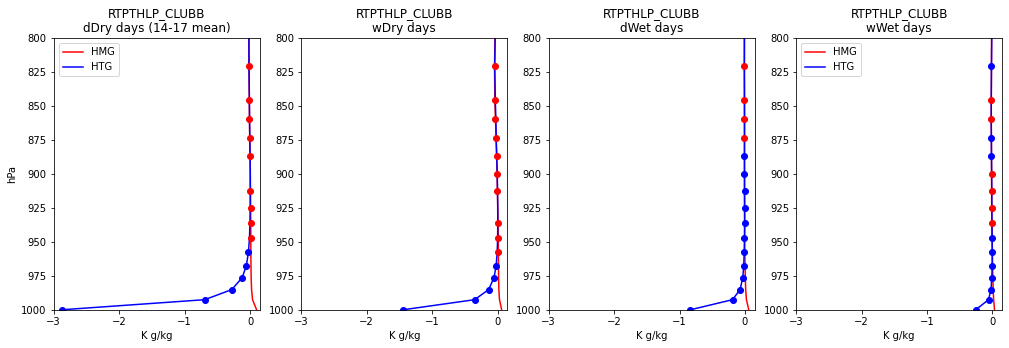

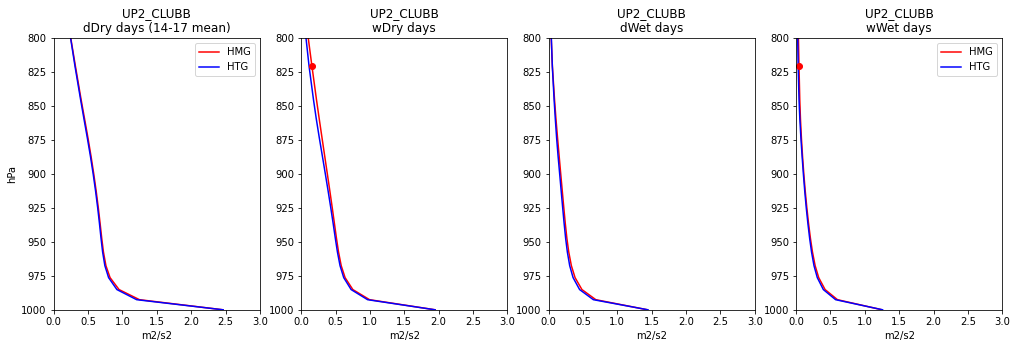

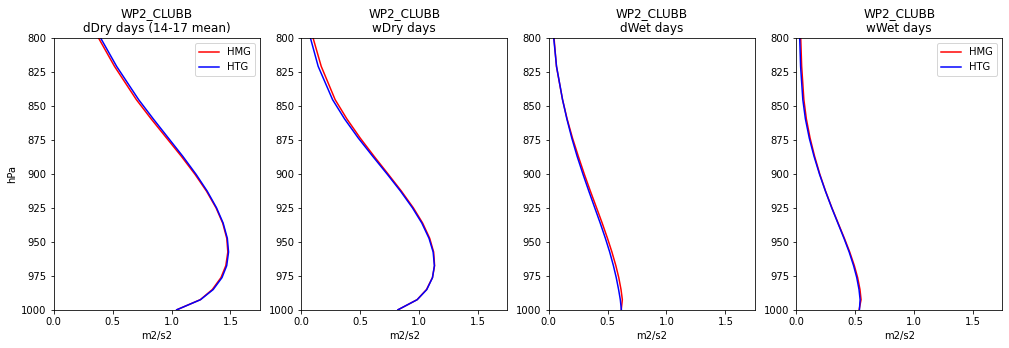

In [43]:

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'THLP2_CLUBB', maxLev, 
#                            -0.01, 0.6)  # 8-10a
                             -0.01, 2.5)  # 3-5p

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'RTP2_CLUBB', maxLev,
#                            0.0, 1.75)
                             0.0, 6.5)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'RTPTHLP_CLUBB', maxLev,
#                            -0.75, 0.15)
                             -3.00, 0.15)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'UP2_CLUBB', maxLev,
#                            0.0, 2.0)
                             0.0, 3.0)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'WP2_CLUBB', maxLev,
#                            0.0, 0.8)
                             0.0, 1.75)



Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


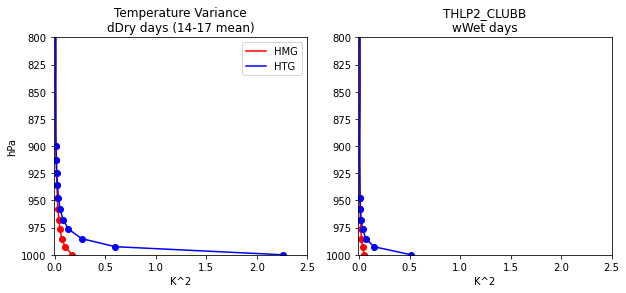

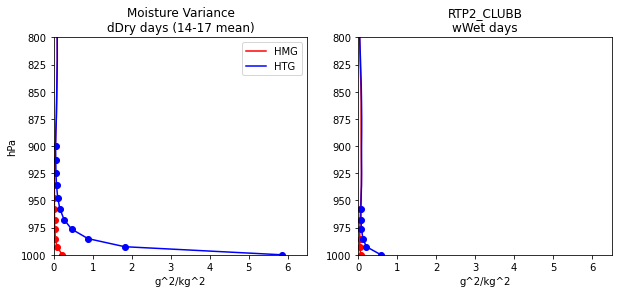

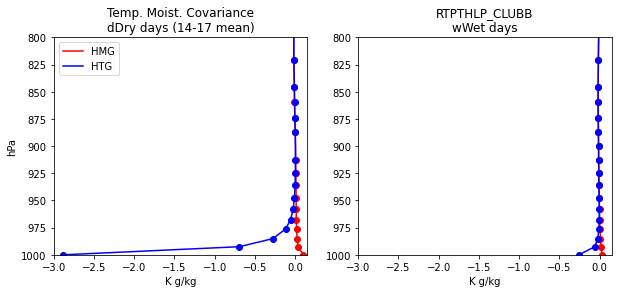

In [85]:
# startHr = 15
# endHr   = 17
startHr = 14
endHr   = 17
maxLev  = 800

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'THLP2_CLUBB', maxLev, 
#                            -0.01, 0.6)  # 8-10a
                             -0.01, 2.5)  # 3-5p

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'RTP2_CLUBB', maxLev,
#                            0.0, 1.75)
                             0.0, 6.5)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'RTPTHLP_CLUBB', maxLev,
#                            -0.75, 0.15)
                             -3.00, 0.15)



Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.


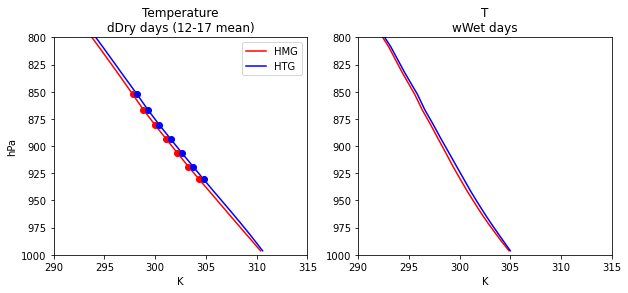

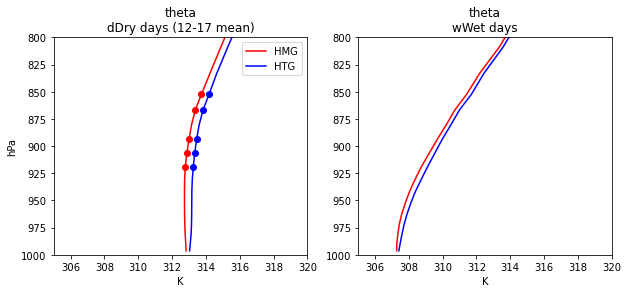

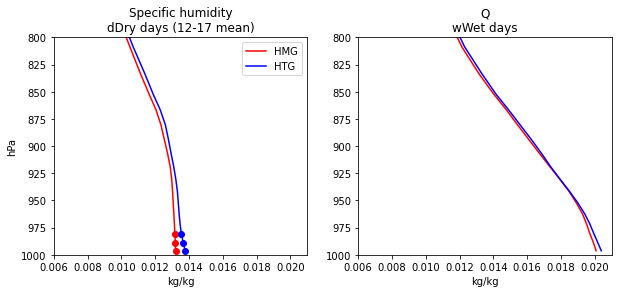

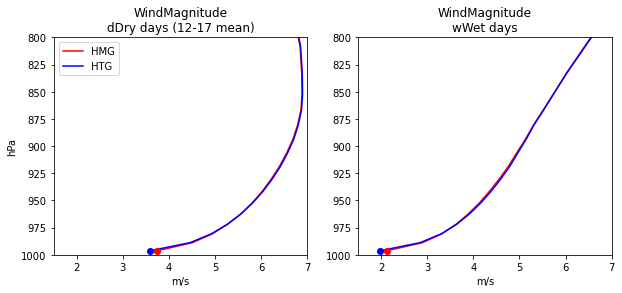

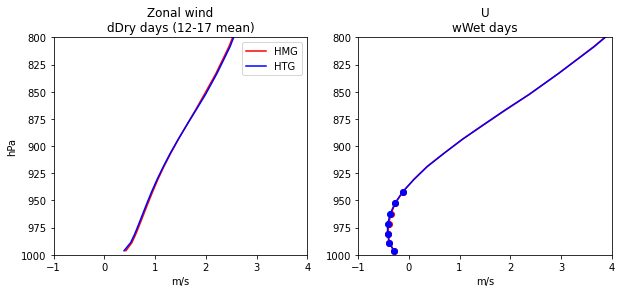

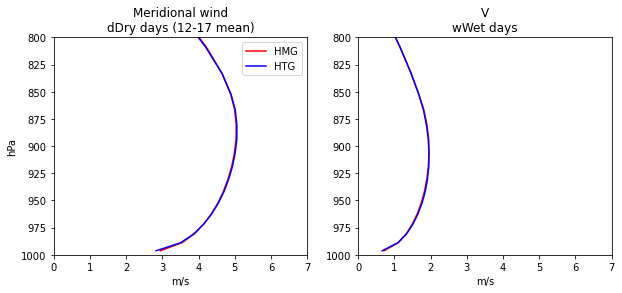

In [45]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'T', maxLev,
#                            280, 310)
                           290, 315)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'theta', maxLev,
#                            280, 310)
                           305, 320)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'Q', maxLev,
#                            0.006, 0.022)
                           0.006, 0.021)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WindMagnitude', maxLev,
#                            0.006, 0.022)
                           1.5, 7)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'U', maxLev,
#                            0.006, 0.022)
                           -1, 4)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'V', maxLev,
#                            0.006, 0.022)
                           0, 7)


Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.


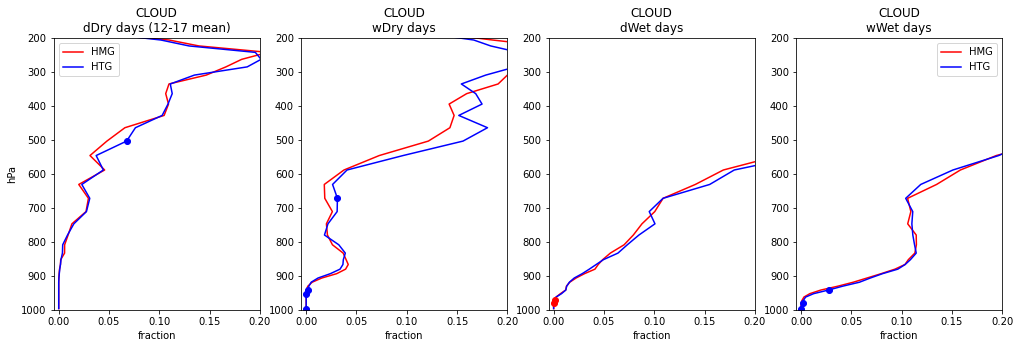

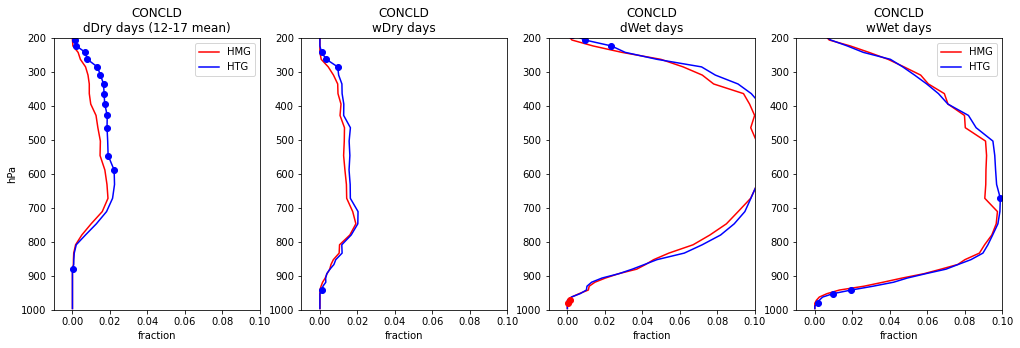

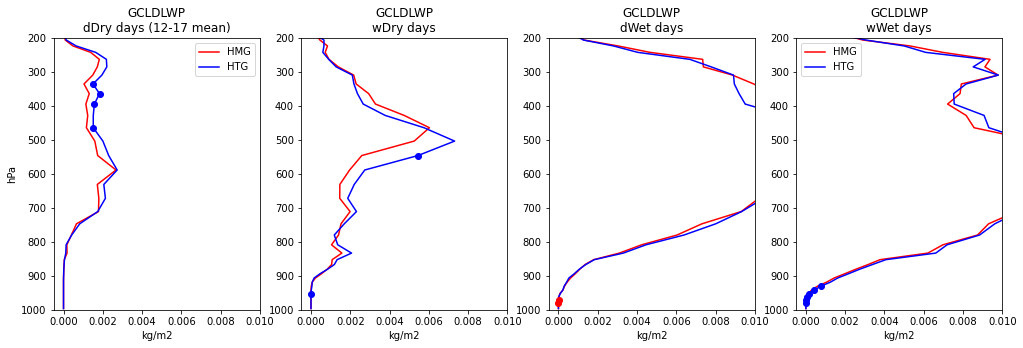

In [92]:
plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'CLOUD', 200,
#                            -0.01, 0.3)
                           -0.005, 0.2)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'CONCLD', 200,
                           -0.01, 0.1)

plotProfiles_WithErrBar_timeOfDayMean(startHr, endHr, 'GCLDLWP', 200,
                           -0.0005, 0.010)


Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.


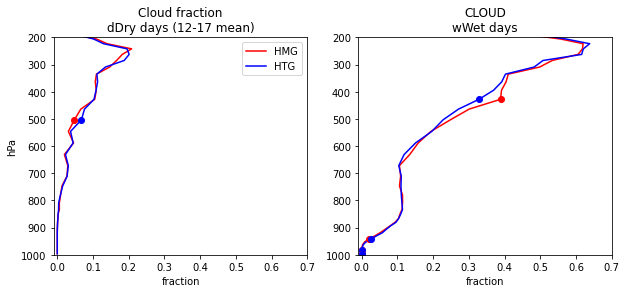

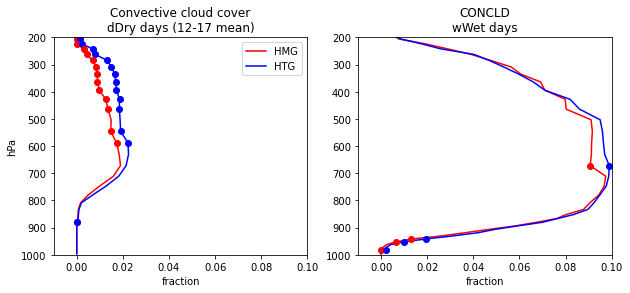

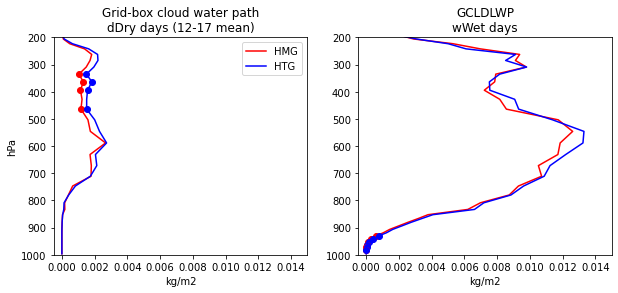

In [46]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'CLOUD', 200,
#                            -0.01, 0.3)
                           -0.01, 0.7)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'CONCLD', 200,
                           -0.01, 0.1)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'GCLDLWP', 200,
                           -0.0005, 0.015)



Means computed over the inclusive period of 12 to 17.
Means computed over the inclusive period of 12 to 17.


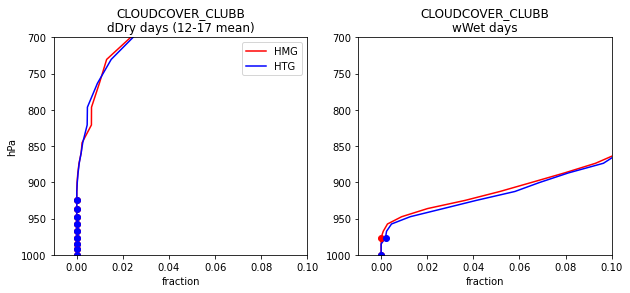

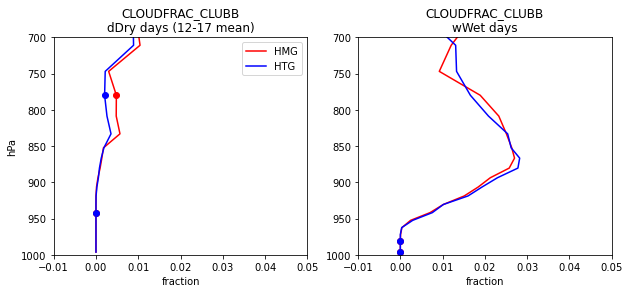

In [94]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'CLOUDCOVER_CLUBB', 700,
                           -0.01, 0.1) 
# To zoom in on dry day increase in HTG cloudcover_clubb: -0.00001, 0.00001)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'CLOUDFRAC_CLUBB', 700,
                           -0.01, 0.05)



Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


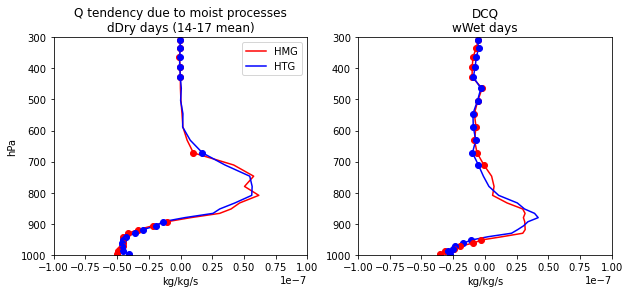

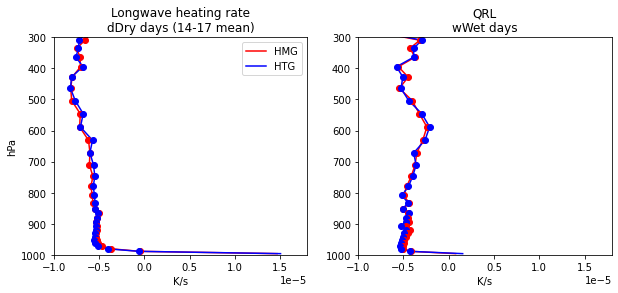

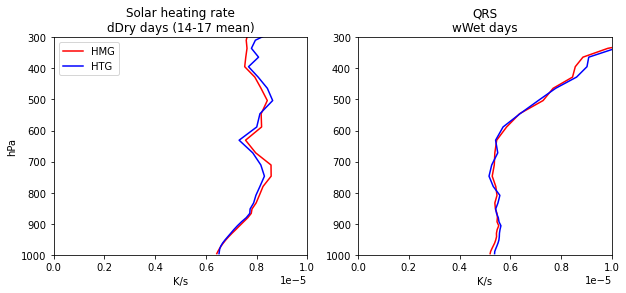

In [101]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'DCQ', 300,
                           -0.1e-6, 0.1e-6) 

# plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'DTCOND', 800,
#                            0, 15e-5) 

# plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'DTV', 800,
#                            -1e-8, 1e-8) 

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'QRL', 300,
                           -1e-5, 1.8e-5) 

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'QRS', 300,
                           0, 1e-5) 


Means computed over the inclusive period of 12 to 17.


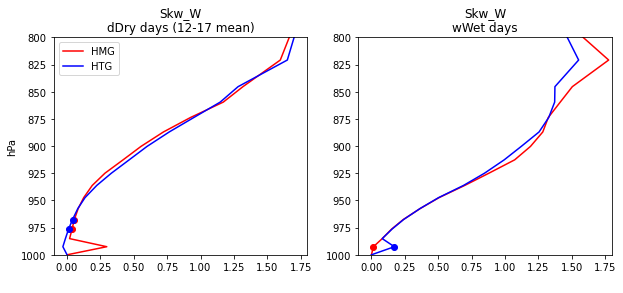

In [48]:

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'Skw_W', maxLev,
#                            -0.02, 0.1)
                           -0.1, 1.8)


Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


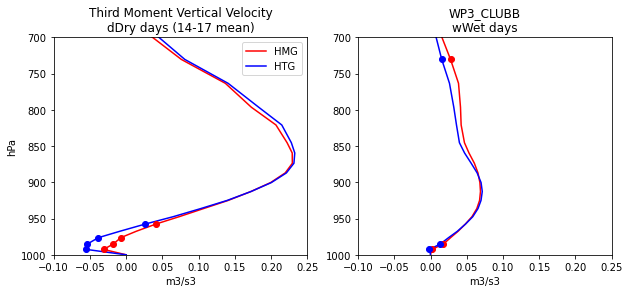

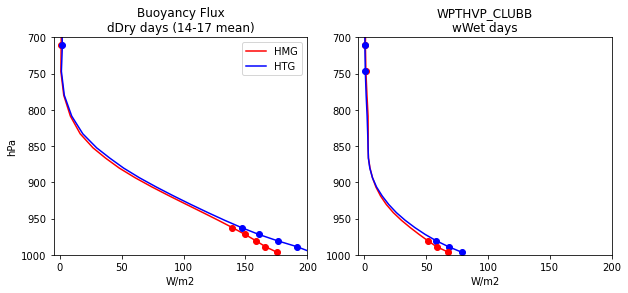

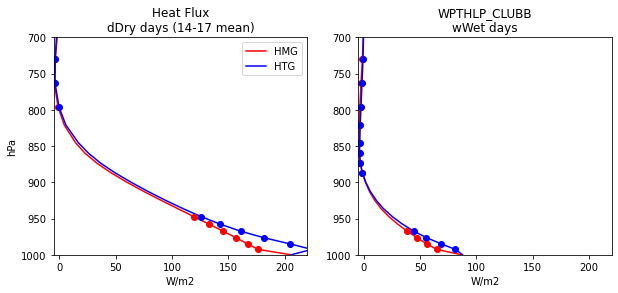

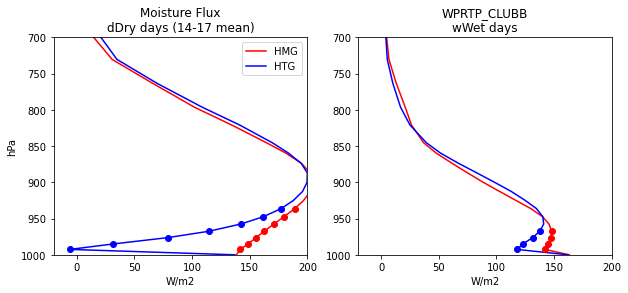

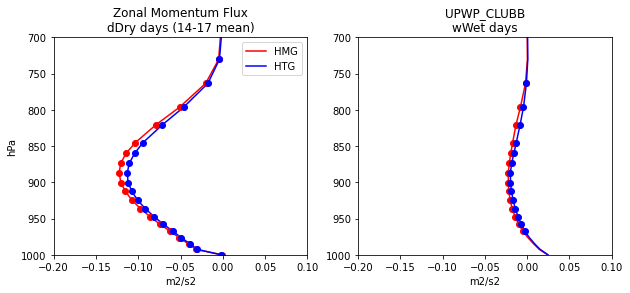

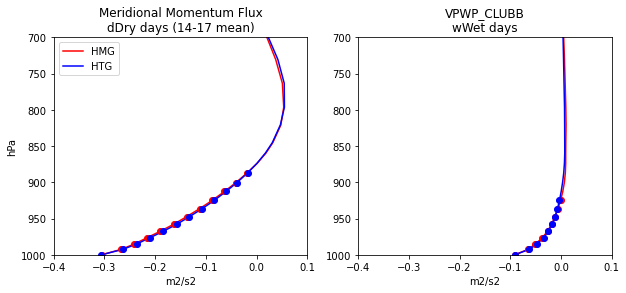

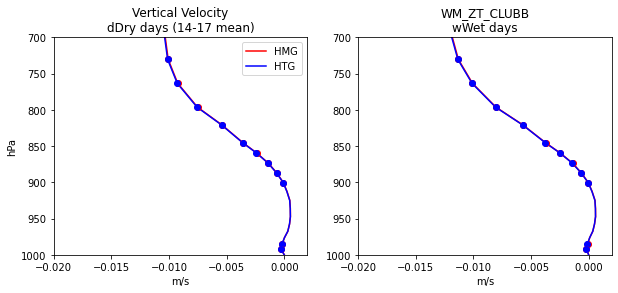

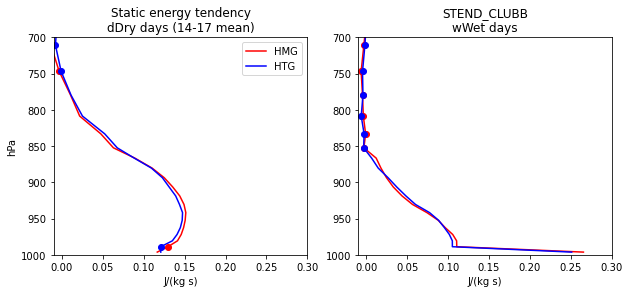

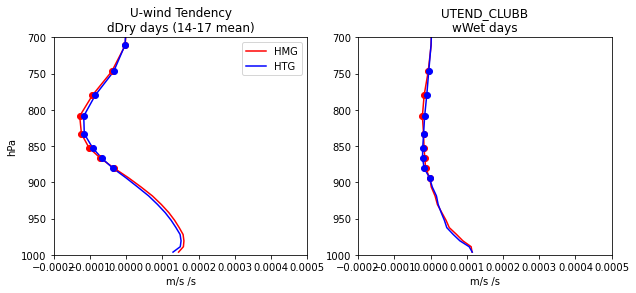

In [93]:
maxLev = 700

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WP3_CLUBB', maxLev,
#                            -0.02, 0.1)
                           -0.1, 0.25)


plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPTHVP_CLUBB', maxLev,
#                            -5, 60)
                           -5, 200)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPTHLP_CLUBB', maxLev,
#                            -5, 80)
                           -5, 220)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPRTP_CLUBB', maxLev,
#                            -10, 120)
                            -20, 200)       

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'UPWP_CLUBB', maxLev,
#                            0.0, 2.0)
                             -0.2, 0.1)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'VPWP_CLUBB', maxLev,
#                            0.0, 2.0)
                             -0.4, 0.1)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WM_ZT_CLUBB', maxLev,
#                            0.0, 2.0)
                             -0.02, 0.002)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'STEND_CLUBB', maxLev,
                            -0.01, 0.3)   


plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'UTEND_CLUBB', maxLev,
                            -0.2e-3, 0.5e-3)   
  


Means computed over the inclusive period of 14 to 17.


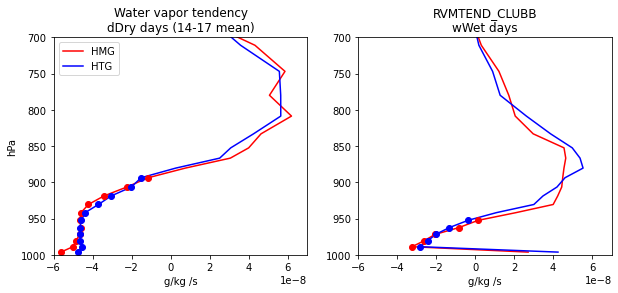

In [90]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'RVMTEND_CLUBB', maxLev,
                            -0.6e-7, 0.7e-7) 

Means computed over the inclusive period of 14 to 17.
Means computed over the inclusive period of 14 to 17.


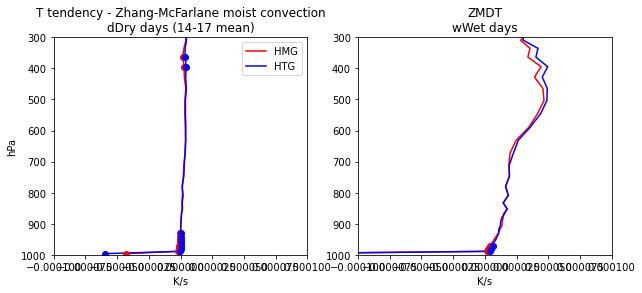

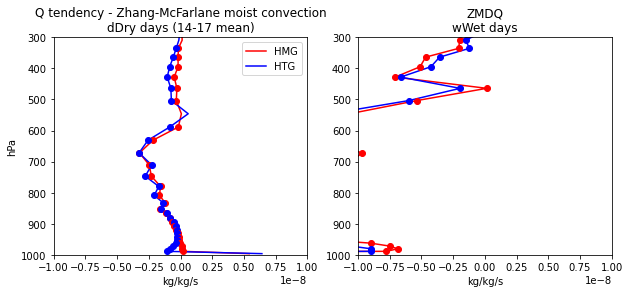

In [100]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'ZMDT', 300,
                            -1e-4, 1e-4) 

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'ZMDQ', 300,
                            -1e-8, 1e-8) 

Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


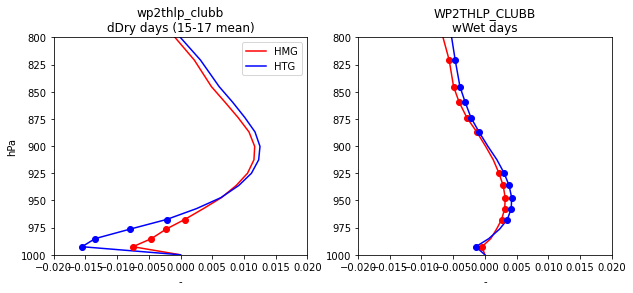

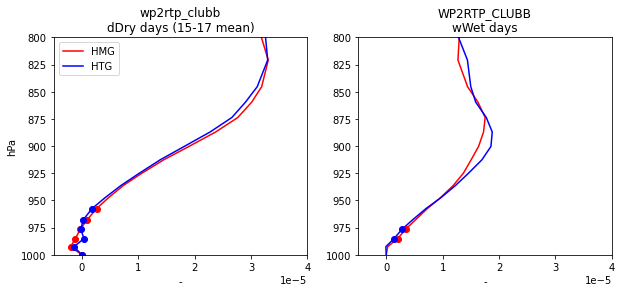

In [66]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(15, 17, 'WP2THLP_CLUBB', maxLev,
#                            -5, 80)
                           -2e-2, 2e-2)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(15, 17, 'WP2RTP_CLUBB', maxLev,
#                            -10, 120)
                            -0.5e-5, 4e-5) 

Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


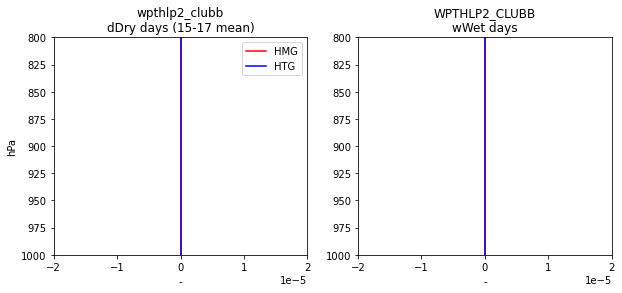

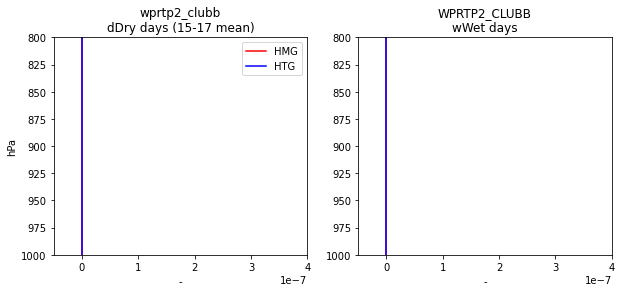

In [56]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPTHLP2_CLUBB', maxLev,
#                            -5, 80)
                           -2e-5, 2e-5)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPRTP2_CLUBB', maxLev,
#                            -10, 120)
                            -0.5e-7, 4e-7) 

Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.
Means computed over the inclusive period of 15 to 17.


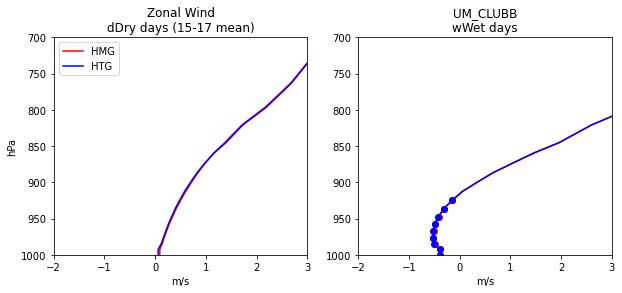

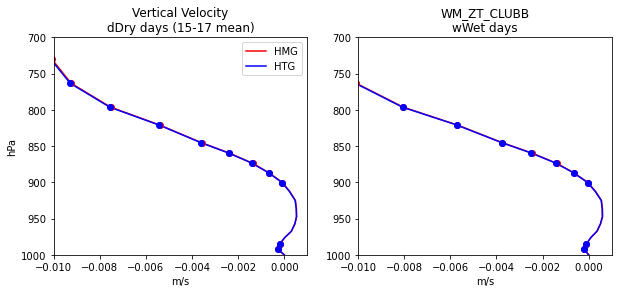

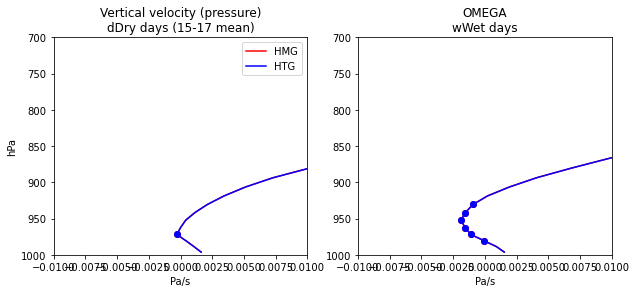

In [54]:

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(15,17, 'UM_CLUBB', maxLev,
#                            0.0, 2.0)
                             -2, 3)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(15,17, 'WM_ZT_CLUBB', maxLev,
#                            0.0, 2.0)
                             -0.01, 0.001)


plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(15,17, 'OMEGA', maxLev,
#                            0.0, 2.0)
                             -0.01, 0.01)

Means computed over the inclusive period of 14 to 17.


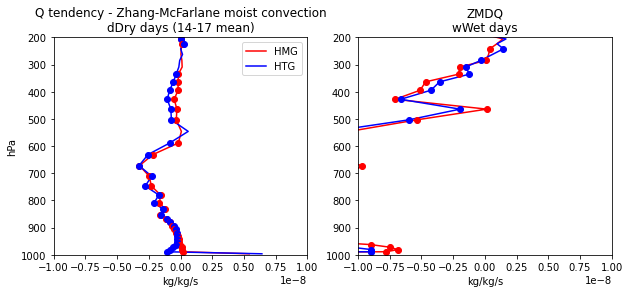

In [83]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(14,17, 'ZMDQ', 200,
#                            0.0, 2.0)
                             -1e-8, 1e-8)

Means computed over the inclusive period of 15 to 17.


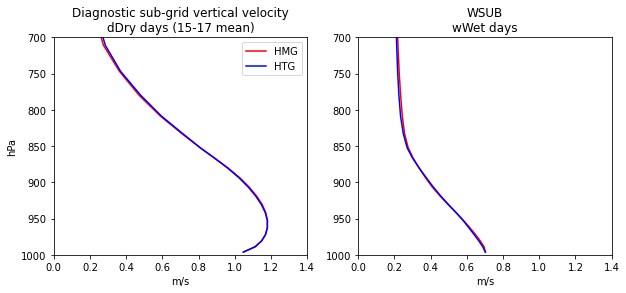

In [76]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(15,17, 'WSUB', maxLev,
#                            0.0, 2.0)
                             0.0, 1.4)

### What if we want some length of period with all dry or all wet days?

In [263]:
# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1

print('Number of total days in record:   %i' % (len(HMGcamDS_localDailySum.year_month_day.values)) )


iSelDryDays = np.where((HMGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff)&
                       (HTGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff))[0]
iSelWetDays = np.where((HMGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff) &
                       (HTGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff))[0]

print('Number of dry days (< %.3f):     %i' % (prectCutoff, len(iSelDryDays)))
print('Number of wet days (>= %.3f):    %i' % (prectCutoff, len(iSelWetDays)))


dayClass = np.full([len(HMGcamDS_localDailySum.year_month_day.values)], 'Mismatch')
dayClass[iSelDryDays] = 'Dry'
dayClass[iSelWetDays] = 'Wet'



Number of total days in record:   352
Number of dry days (< 1.000):     161
Number of wet days (>= 1.000):    167


In [269]:
numSequence = 3
len(np.unique(dayClass[0:0+numSequence]))
    

1

In [278]:
dayClass

array(['Dry', 'Dry', 'Dry', 'Dry', 'Dry', 'Dry', 'Dry', 'Dry', 'Dry',
       'Dry', 'Wet', 'Wet', 'Wet', 'Wet', 'Wet', 'Wet', 'Wet', 'Mismatch',
       'Mismatch', 'Dry', 'Dry', 'Dry', 'Dry', 'Dry', 'Mismatch', 'Dry',
       'Dry', 'Dry', 'Dry', 'Dry', 'Wet', 'Wet', 'Wet', 'Wet', 'Wet',
       'Wet', 'Wet', 'Wet', 'Wet', 'Dry', 'Dry', 'Dry', 'Dry', 'Dry',
       'Dry', 'Dry', 'Dry', 'Dry', 'Wet', 'Wet', 'Wet', 'Wet', 'Dry',
       'Dry', 'Dry', 'Dry', 'Dry', 'Mismatch', 'Wet', 'Wet', 'Mismatch',
       'Mismatch', 'Dry', 'Wet', 'Wet', 'Dry', 'Dry', 'Dry', 'Wet', 'Wet',
       'Dry', 'Dry', 'Dry', 'Wet', 'Dry', 'Dry', 'Wet', 'Wet', 'Wet',
       'Dry', 'Wet', 'Wet', 'Wet', 'Wet', 'Dry', 'Wet', 'Wet', 'Wet',
       'Wet', 'Wet', 'Mismatch', 'Dry', 'Dry', 'Mismatch', 'Dry', 'Dry',
       'Wet', 'Mismatch', 'Mismatch', 'Wet', 'Wet', 'Wet', 'Dry', 'Dry',
       'Mismatch', 'Wet', 'Wet', 'Dry', 'Dry', 'Dry', 'Wet', 'Wet', 'Dry',
       'Wet', 'Wet', 'Dry', 'Dry', 'Wet', 'Wet', 'Wet', 'Wet', 

In [286]:
numSequence = 3
iDays    = 0
dayCount = 0

dayClassWindow = dayClass[dayCount:dayCount+numSequence]

iWet = np.where(dayClass[dayCount::] == 'Wet')[0]
len(np.arange(iDays, iWet[0]))

10

In [296]:

numSequence = 3
startDay_drySpell    = []
startDay_wetSpell    = []
length_drySpell      = []
length_wetSpell      = []

dayCount = int(0)
for iDays in range(25):
    # Get dry/wet days in window of choice
    dayClassWindow = dayClass[dayCount:dayCount+numSequence]
    print(dayClassWindow)
    
    # If all days are in the same precip classification...
    if len(np.unique(dayClassWindow))==1:
        # If all those days are dry...
        if np.unique(dayClassWindow)=='Dry':
            startDay_drySpell = np.append(startDay_drySpell, HMGcamDS_localDailySum.year_month_day.values[dayCount])
            
            iWet = np.where(dayClass[dayCount::] == 'Wet')[0]
            length_drySpell = np.append(length_drySpell, len(np.arange(dayCount, iWet[0])))
            
            dayCount = (dayCount+length_drySpell[-1]).astype(int)
            
        elif np.unique(dayClassWindow)=='Wet':
            startDay_wetSpell = np.append(startDay_wetSpell, HMGcamDS_localDailySum.year_month_day.values[dayCount])
            
            iDry = np.where(dayClass[dayCount::] == 'Dry')[0]
            length_wetSpell = np.append(length_wetSpell, len(np.arange(dayCount, iDry[0])))
            
            dayCount = (dayCount+length_wetSpell[-1]).astype(int)
    else: 
        dayCount = (dayCount+1).astype(int)
        
    
    print(HMGcamDS_localDailySum.year_month_day.values[dayCount], '   ', dayClass[dayCount])


['Dry' 'Dry' 'Dry']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12)     Wet
['Wet' 'Wet' 'Wet']
(2015, 6, 12) 

In [293]:
length_drySpell

array([10.])

In [294]:
length_wetSpell

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])